In [1]:

import pandas as pd 
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import StratifiedKFold,  GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklift.models import SoloModel, TwoModels, ClassTransformation, ClassTransformationReg
import matplotlib.pyplot as plt
import numpy as np
import swifter
from tqdm import tqdm
from statsmodels.stats.weightstats  import CompareMeans
import gc
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)
from sklift.viz import  plot_qini_curve, plot_uplift_curve
pd.options.display.max_columns = None



# Object For Preprocessing

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
class PrepocessingDataSetLetu():
    def __init__(self,  cat_vars = ['lftm_type','SEGMENT_N'
                                ,	'SUB_EMAIL'
                                , 'Тип карты'	
                                , 'Канал регистрации'
                                , 'NewComer'] 
                ,  for_norm = ['last_order_days',	'AMOUNT'
                                ,	'ORDERS'
                                ,	'AOV'	
                                ,'LTV_1M'
                                , 'AO_per_month'
                                , 'GET_Bonus'
                                ,	'USE_Bonus'
                                ,	'NON_SPEND_BONUS'
                                ,	'BASE_GET_Bonus'
                                ,	'BASE_USE_Bonus'
                                ,	'Express_GET_Bonus'
                                ,	'Express_USE_Bonus'
                                ,	'Camp_GET_Bonus'
                                ,	'REG_GET_Bonus'	
                                , 'Camp_BASE_GET_Bonus'
                                ,	'REG_BASE_GET_Bonus'
                                , 'AVG_USE_BONUS'
                                ,	'DISC_AMOUNT'
                                ,	'DISC_ORDERS'
                                , 'BASE_AVG_USE_BONUS'
                                ,	'BASE_DISC_AMOUNT'
                                ,	'BASE_DISC_ORDERS'
                                , 'Express_AVG_USE_BONUS',	'Express_DISC_AMOUNT',	'Express_DISC_ORDERS'
                                ,'min_days_between', 'max_days_between', 'avg_days_between']
                , age = 'AGE'
               
            ):
            self.cat_vars = cat_vars
            self.for_norm = for_norm
            self.age = age
            self.scaler = None#StandardScaler()
            self.ohe = None#OneHotEncoder()
            self.ohe_solomodel = None#OneHotEncoder()
            self.med = None


    def remove_colls(self, colls):
        for c in colls:
            if c in self.for_norm:
                self.for_norm.remove(c)
            if c in self.cat_vars:
                self.cat_vars.remove(c)



    def fit(self, df):
        Y_var = df[['target','treat']]
        X_var = df.drop(['target','treat'], axis = 1)
        self.ohe = OneHotEncoder()
        self.scaler = StandardScaler()
        self.ohe_solomodel = OneHotEncoder()
        self.ohe.fit(X_var[self.cat_vars].values)
        self.med = X_var[self.age].median()
        self.scaler.fit(X_var[self.for_norm].values)
        self.ohe_solomodel.fit(Y_var.treat.values.reshape(-1, 1))
        del X_var, Y_var


    def preprocessing_data(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values                                            
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()
                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var  


    
    def preprocessing_data_solomodel(self, df):
                        Y_var = df[['target','treat']]
                        X_var = df.drop(['target','treat'], axis = 1)
                        dataset = pd.DataFrame()
                        
                        ## Categorical to Vec
                        if(self.ohe is None):
                            self.ohe = OneHotEncoder()
                            res = self.ohe.fit_transform(X_var[self.cat_vars].values).toarray()
                        else:
                            res = self.ohe.transform(X_var[self.cat_vars].values).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.cat_vars, axis =1)                    
                       #dataset.head()

                        ## Numeric preprocessing
                        if(self.med is None):
                            self.med = X_var[self.age].median()

                        res =  X_var[self.age].apply(lambda x: x if((x >= 16) and (x <= 90)) else self.med).fillna(self.med)
                        res = (res / 100).values    
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)                                            
                        X_var = X_var.drop([self.age], axis =1).fillna(0)                  

                        if(self.scaler is None):
                            self.scaler = StandardScaler()
                            res = self.scaler.fit_transform(X_var[self.for_norm].values)
                        else:
                            res = self.scaler.transform(X_var[self.for_norm].values)

                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)
                        X_var = X_var.drop(self.for_norm, axis =1)      
                        dataset = pd.concat([dataset
                                        , pd.DataFrame(X_var.values)] , axis = 1)
                        del X_var   
                        gc.collect()


                        if(self.ohe_solomodel is None):
                            self.ohe_solomodel = OneHotEncoder()
                            res = self.ohe_solomodel.fit_transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        else:
                            res = self.ohe_solomodel.transform(Y_var.treat.values.reshape(-1, 1)).toarray()
                        
                        dataset = pd.concat([dataset, pd.DataFrame(res)], axis = 1)

                        cols = ['var_'+str(i) for i in range(dataset.shape[1])]
                        dataset.columns = cols
                        dataset.index = df.index
                        return dataset, Y_var

In [3]:
def get_metrics(target, treat, uplift, k):
    return uplift_at_k(target, uplift, treat, strategy='overall', k=k) , uplift_at_k(target, uplift, treat, strategy='by_group', k=k) , qini_auc_score(target, uplift, treat), uplift_auc_score(target, uplift, treat)


def get_report(target, treat, uplift, plot_path = '', k =0.3):
    """
    Return:
        * uplift_at_k_overall
        * plift_at_k_group
        * qini_score
        * uplift_score

        Print qini, uplift plots
    """
    uplift_overall, uplift_group, qini_score, uplift_score = get_metrics(target, treat, uplift, k)                   
    print(f'UpLift at 30%: overall - {round(uplift_overall, 6)}, grouped - {round(uplift_group, 6)}.\nQini AUC Score: {round(qini_score, 6)}; UpLift AUC Score: {round(uplift_score, 6)}')

    fig, ax = plt.subplots(1, 2, figsize = (30, 10))
    ax[0].set_title('Qini Curve')
    ax[1].set_title('UpLift Curve')
    plot_qini_curve(target , uplift, treatment=treat, ax = ax[0], perfect=False)
    gc.collect()
    plot_uplift_curve(target , uplift, treatment=treat, ax = ax[1], perfect=False)
    gc.collect()
    gc.collect()
    gc.collect()
    plt.savefig(f"Plots/Base model Split.png")
    return uplift_overall, uplift_group, qini_score, uplift_score

# Compare means, vars

In [4]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')
df_subm = pd.read_csv(r'uplift_subm_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                #     , dtype = {'NPL':str
                #             , 'SEGMENT_N':str}
                , index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'], axis = 1)#.set_index('NPL')



df.index.name = None
df_subm.index.name = None

C:\Users\Kirill\AppData\Local\Temp\ipykernel_8720\364234166.py:7: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df_subm = pd.read_csv(r'uplift_subm_dataset.zip'


In [5]:
df['Тип карты'].value_counts()

Как карточное платежное средство    599242
Без возможности оплаты              345177
Name: Тип карты, dtype: int64

In [6]:
df['SUB_EMAIL'] = df['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df['lftm_type'] = df['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df['Тип карты'] = df['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df['Канал регистрации'] = df['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

df_subm['SUB_EMAIL'] = df_subm['SUB_EMAIL'].swifter.apply(lambda x: 1 if x == 'Да' else 0)
df_subm['lftm_type'] = df_subm['lftm_type'].swifter.apply(lambda x: 1 if x =='NewComer' else 0)
df_subm['Тип карты'] = df_subm['Тип карты'].swifter.apply(lambda x: 1 if x == 'Как карточное платежное средство' else 0)
df_subm['Канал регистрации'] = df_subm['Канал регистрации'].swifter.apply(lambda x: 1 if x =='Розница' else 0)

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/944419 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/975814 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/975814 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/975814 [00:00<?, ?it/s]

c:\Users\Kirill\.conda\envs\automl\lib\site-packages\swifter\swifter.py:87: UserWarning: This pandas object has duplicate indices, and swifter may not be able to improve performance. Consider resetting the indices with `df.reset_index(drop=True)`.
  warnings.warn(


Pandas Apply:   0%|          | 0/975814 [00:00<?, ?it/s]

In [7]:
display(df.describe())
display(df_subm.describe())

SEGMENT_N      SUB_EMAIL         target          treat  \
count  944419.000000  944419.000000  944419.000000  944419.000000   
mean        2.101340       0.541043       0.067608       0.501118   
std         1.811272       0.498313       0.251072       0.499999   
min        -1.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         1.000000       1.000000       0.000000       1.000000   
75%         4.000000       1.000000       0.000000       1.000000   
max         8.000000       1.000000       1.000000       1.000000   

           lftm_type       NewComer      Тип карты  Канал регистрации  \
count  944419.000000  944419.000000  944419.000000      944419.000000   
mean        0.994313       0.365956       0.634509           0.545221   
std         0.075198       0.481698       0.481568           0.497951   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       0.000000           0.000000   
50%         1.000000       0.000000       1.000000           1.000000   
75%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

                 AGE         AMOUNT         ORDERS            AOV  \
count  453581.000000  755894.000000  942040.000000  755894.000000   
mean       36.602012    3857.211624       1.331795    2564.268335   
std        13.860691    5523.302219       1.384443    3130.889447   
min      -132.000000       0.000000       0.000000       0.000000   
25%        28.000000     796.000000       1.000000     602.500000   
50%        36.000000    2104.400000       1.000000    1435.000000   
75%        44.000000    5061.000000       2.000000    3486.743750   
max       122.000000  333545.200000     123.000000  152911.550000   

       last_order_days         LTV_1M   AO_per_month      GET_Bonus  \
count    764793.000000  755894.000000  942040.000000  942031.000000   
mean         46.448744     964.302906       0.332949     666.323852   
std          30.587820    1380.825555       0.346111     349.988680   
min           1.000000       0.000000       0.000000    -500.000000   
25%          20.000000     199.000000       0.250000     390.000000   
50%          42.000000     526.100000       0.250000     543.000000   
75%          70.000000    1265.250000       0.500000     845.000000   
max         123.000000   83386.300000      30.750000   22523.000000   

           USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
count  335859.000000    335850.000000   757301.000000    92859.000000   
mean      461.600683       322.106664       50.441065       92.826251   
std       298.936065       286.448374      110.279730      205.242753   
min         1.000000     -5800.000000        0.000000        0.560000   
25%       300.000000        53.000000        9.000000       11.000000   
50%       500.000000       309.000000       23.000000       32.000000   
75%       502.000000       509.000000       54.000000       77.000000   
max     22446.000000      5302.000000    12449.000000    11751.000000   

       Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
count      939045.000000      322894.000000    12904.000000  755894.000000   
mean          627.764011         453.439801      331.176767      39.801239   
std           331.404296         256.732358      355.647582      55.816217   
min          -500.000000           1.000000        0.000000       0.000000   
25%           300.000000         300.000000      144.000000       9.000000   
50%           500.000000         500.000000      218.000000      22.000000   
75%           800.000000         500.000000      465.000000      52.000000   
max         22446.000000       22446.000000     9664.000000    3349.000000   

       Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus        AVG_DIS  AVG_USE_BONUS  \
count         12904.000000  

SEGMENT_N      SUB_EMAIL         target          treat  \
count  975814.000000  975814.000000  975814.000000  975814.000000   
mean        2.137063       0.585779       0.067814       0.533520   
std         1.930569       0.492587       0.251427       0.498875   
min        -1.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       0.000000       0.000000   
50%         3.000000       1.000000       0.000000       1.000000   
75%         4.000000       1.000000       0.000000       1.000000   
max         8.000000       1.000000       1.000000       1.000000   

           lftm_type       NewComer      Тип карты  Канал регистрации  \
count  975814.000000  975814.000000  975814.000000      975814.000000   
mean        0.876021       0.460481       0.673748           0.466333   
std         0.329557       0.498436       0.468841           0.498865   
min         0.000000       0.000000       0.000000           0.000000   
25%         1.000000       0.000000       0.000000           0.000000   
50%         1.000000       0.000000       1.000000           0.000000   
75%         1.000000       1.000000       1.000000           1.000000   
max         1.000000       1.000000       1.000000           1.000000   

                 AGE         AMOUNT         ORDERS            AOV  \
count  458817.000000  692036.000000  909557.000000  692036.000000   
mean       36.813858    3788.302758       1.274158    2523.472744   
std        14.008915    5334.372480       1.365341    3023.743919   
min      -132.000000       0.000000       0.000000       0.000000   
25%        28.000000     786.750000       1.000000     599.000000   
50%        36.000000    2152.975000       1.000000    1478.000000   
75%        45.000000    5016.850000       2.000000    3432.687500   
max       122.000000  763185.000000      99.000000  119321.450000   

       last_order_days        LTV_1M   AO_per_month      GET_Bonus  \
count    701588.000000  692036.00000  909557.000000  909181.000000   
mean         48.760540     947.07569       0.318539     497.063034   
std          27.161038    1333.59312       0.341335     352.967969   
min           1.000000       0.00000       0.000000   -1500.000000   
25%          27.000000     196.68750       0.250000     302.000000   
50%          42.000000     538.24375       0.250000     333.000000   
75%          67.000000    1254.21250       0.500000     637.000000   
max         122.000000  190796.25000      24.750000   16005.000000   

           USE_Bonus  NON_SPEND_BONUS  BASE_GET_Bonus  BASE_USE_Bonus  \
count  374683.000000    374307.000000   693706.000000   115517.000000   
mean      383.246683       181.355438       48.357684       79.081620   
std       289.493702       321.954232      104.887807      177.622533   
min         0.040000     -3000.000000     -173.000000        0.040000   
25%       300.000000        13.000000        9.000000       12.000000   
50%       300.000000        79.000000       23.000000       33.000000   
75%       479.000000       324.000000       53.000000       73.000000   
max     13346.000000      4770.920000    13741.000000    10976.000000   

       Express_GET_Bonus  Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
count      829732.000000      344619.000000    14592.000000  692034.000000   
mean          504.228174         390.172177      310.005551      39.104496   
std           324.317487         256.222851      303.318192      53.861142   
min         -1500.000000           1.000000        0.000000       0.000000   
25%           300.000000         300.000000      159.000000       9.000000   
50%           300.000000         300.000000      231.000000      23.000000   
75%           600.000000         500.000000      376.000000      51.000000   
max         14602.000000       13343.000000     8851.000000    7640.000000   

       Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus        AVG_DIS  AVG_USE_BONUS  \
count         14592.000000       6920

In [8]:
def ttest_means(x_mean = .0, y_mean = .0, x_std = 1.0, y_std = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import t
    S = np.sqrt(((n1 - 1) * x_std**2 +  (n2 - 1) * y_std**2) - 2)
    T = (x_mean - y_mean) / (S * np.sqrt(1 / n1 + 1 / n2))
    rv = t(df = n1 + n2 - 2)
    return rv.sf(np.abs(T)) * 2, T


def chi_vars(x_var = 1.0, y_var = 1.0, n1 = 2, n2 = 1):
    from scipy.stats import f
    F = x_var/y_var #calculate F test statistic 
    dfn = n1-1 #define degrees of freedom numerator 
    dfd = n2-1 #define degrees of freedom denominator 
    p = 1- f.cdf(F, dfn, dfd) #find p-value of F test statistic 
    return p, F   


In [9]:
colls = df.columns.tolist()
res = {}
stats = {}
for coll in colls:
    p_m, T = ttest_means(df[coll].mean()
                        , df_subm[coll].mean()
                        , df[coll].std()
                        , df_subm[coll].std()
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    p_v, F = chi_vars(np.var(df[coll].values, ddof= 1)
                        , np.var(df_subm[coll].values, ddof = 1)
                        , df[coll].dropna().shape[0]
                        , df_subm[coll].dropna().shape[0])
    res[coll] = {'p_means':p_m
                    , 'p_vars':p_v}
    stats[coll] = (T, F, df[coll].mean()
                        , df_subm[coll].mean()
                        , df[coll].std()
                        , df_subm[coll].std()
                        , df[coll].dropna().shape[0] + df_subm[coll].dropna().shape[0] - 2 
                        , np.var(df[coll].values, ddof= 1)
                        , np.var(df_subm[coll].values, ddof = 1))

In [10]:
res

{'SEGMENT_N': {'p_means': 0.9923915331748452, 'p_vars': 1.0},
 'SUB_EMAIL': {'p_means': 0.9639922405966268,
  'p_vars': 1.1102230246251565e-16},
 'target': {'p_means': 0.9996722374527444, 'p_vars': 0.9169837033642617},
 'treat': {'p_means': 0.9741252137368006, 'p_vars': 0.013757031078302395},
 'lftm_type': {'p_means': 0.8059795563032751, 'p_vars': 1.0},
 'NewComer': {'p_means': 0.9232129657773535, 'p_vars': 1.0},
 'Тип карты': {'p_means': 0.9670670483199961,
  'p_vars': 1.1102230246251565e-16},
 'Канал регистрации': {'p_means': 0.9369303885480859,
  'p_vars': 0.9638569855167074},
 'AGE': {'p_means': 0.9939354222744089, 'p_vars': nan},
 'AMOUNT': {'p_means': 0.994945779160403, 'p_vars': nan},
 'ORDERS': {'p_means': 0.9832820691688704, 'p_vars': nan},
 'AOV': {'p_means': 0.9947213058526675, 'p_vars': nan},
 'last_order_days': {'p_means': 0.9682341414319748, 'p_vars': nan},
 'LTV_1M': {'p_means': 0.9949457791603982, 'p_vars': nan},
 'AO_per_month': {'p_means': 0.9832819975539957, 'p_vars'

In [11]:
# stats

In [12]:
# res_sort = sorted(res.items(), key = lambda x: x[1])
# res_sort

In [13]:
colls_to_drop = [k for k,v in res.items() if (v['p_means'] <= 0.05) or (v['p_vars'] <= 0.05)]
if 'treat' in  colls_to_drop:
    colls_to_drop.remove('treat')

if 'target' in  colls_to_drop:
    colls_to_drop.remove('target')
colls_to_drop

['SUB_EMAIL', 'Тип карты']

# Базовая модель

In [14]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
display(df.head())
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 


SEGMENT_N  target  treat lftm_type  NewComer Канал регистрации  \
7727314307         3       0      0  NewComer         1           Розница   
7721696179         2       0      0  NewComer         0             Ecomm   
7727261180        -1       0      0  NewComer         1             Ecomm   
7725642339         1       0      1  NewComer         0             Ecomm   
7720389215         1       0      1  NewComer         0           Розница   

             AGE  AMOUNT  ORDERS     AOV  last_order_days  LTV_1M  \
7727314307   NaN  3403.4     2.0  1701.7             50.0  850.85   
7721696179  51.0     NaN     0.0     NaN              NaN     NaN   
7727261180  32.0     NaN     4.0     NaN              8.0     NaN   
7725642339   NaN   959.2     1.0   959.2             68.0  239.80   
7720389215   NaN  1603.0     1.0  1603.0            105.0  400.75   

            AO_per_month  GET_Bonus  USE_Bonus  NON_SPEND_BONUS  \
7727314307          0.50      536.0      502.0             34.0   
7721696179          0.00     1300.0        NaN              NaN   
7727261180          1.00     4000.0     2500.0           1500.0   
7725642339          0.25      510.0        NaN              NaN   
7720389215          0.25      517.0        NaN              NaN   

            BASE_GET_Bonus  BASE_USE_Bonus  Express_GET_Bonus  \
7727314307            36.0             2.0              500.0   
7721696179             NaN             NaN             1300.0   
7727261180             NaN             NaN             4000.0   
7725642339            10.0             NaN              500.0   
7720389215            17.0             NaN              500.0   

            Express_USE_Bonus  Camp_GET_Bonus  REG_GET_Bonus  \
7727314307              500.0             NaN           36.0   
7721696179                NaN             NaN            NaN   
7727261180             2500.0             NaN            NaN   
7725642339                NaN             NaN           10.0   
7720389215                NaN             NaN           17.0   

            Camp_BASE_GET_Bonus  REG_BASE_GET_Bonus   AVG_DIS  AVG_USE_BONUS  \
7727314307                  NaN                36.0  0.133248          502.0   
7721696179                  NaN                 NaN       NaN            NaN   
7727261180                  NaN                 NaN  0.999200         1250.0   
7725642339                  NaN                10.0       NaN            NaN   
7720389215                  NaN                17.0       NaN            NaN   

            DISC_AMOUNT  DISC_ORDERS  BASE_AVG_DIS  BASE_AVG_USE_BONUS  \
7727314307       3265.4          1.0      0.000612                 2.0   
7721696179          NaN          NaN           NaN                 NaN   
7727261180          NaN          2.0           NaN                 NaN   
7725642339          NaN          NaN           NaN                 NaN   
7720389215          NaN          NaN           NaN                 NaN   

            BASE_DISC_AMOUNT  BASE_DISC_ORDERS  Express_AVG_DIS  \
7727314307            3265.4               1.0         0.132788   
7721696179               NaN               NaN              NaN   
7727261180               NaN               NaN         0.999200   
7725642339               NaN               NaN              NaN   
7720389215               NaN               NaN              NaN   

            Express_AVG_USE_BONUS  Express_DISC_AMOUNT  Express_DISC_ORDERS  \
7727314307                  500.0               3265.4                  1.0   
7721696179                    NaN                  NaN                  NaN   
7727261180                 1250.0                  NaN                  2.0   
7725642339                    NaN                  NaN                  NaN   
7720389215                    NaN                  NaN                  NaN   

            min_days_between  max_days_between  avg_days_between  
7727314307              -5.0              -5.0              -5.0  
7721696179      

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

UpLift at 30%: overall - 0.008914, grouped - 0.008911.
Qini AUC Score: 0.000743; UpLift AUC Score: 0.000182


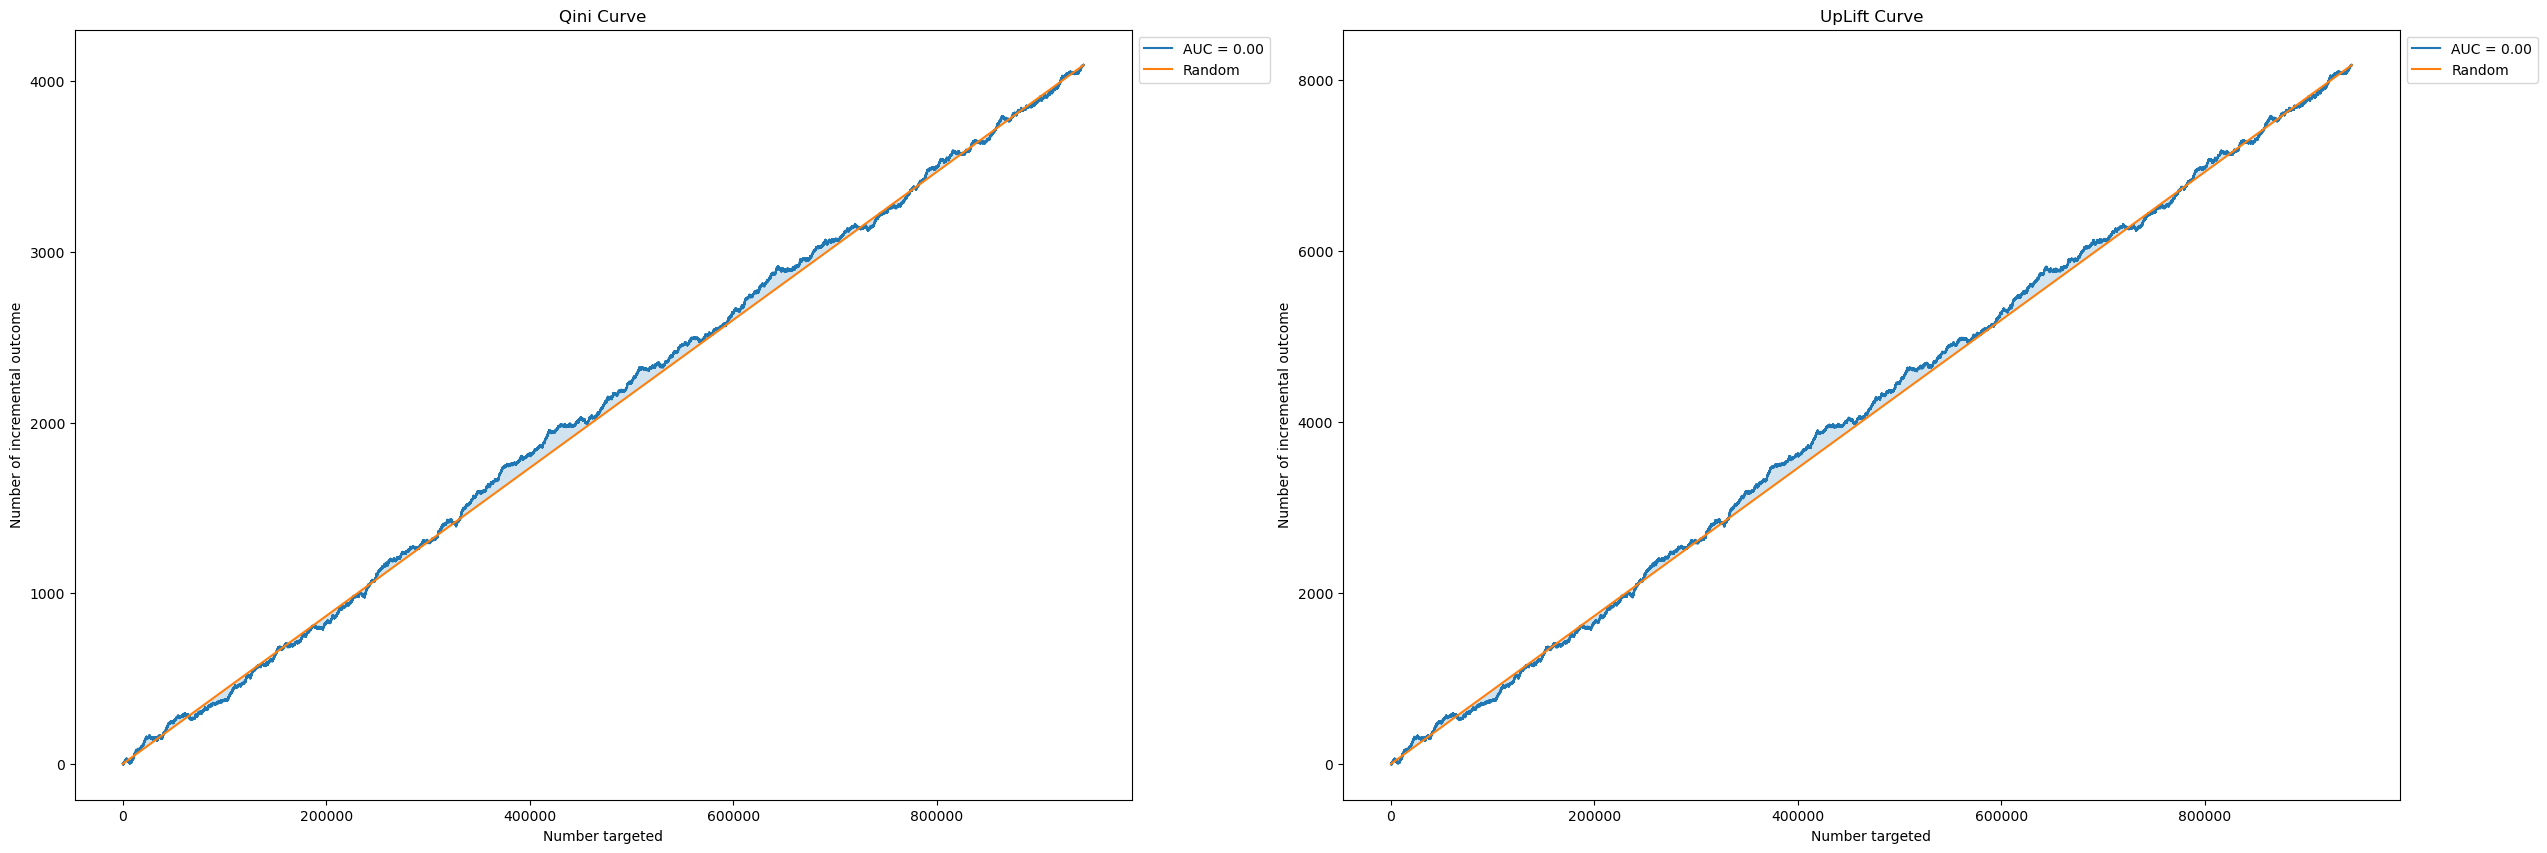

In [15]:
treat = Y_data.treat.values
y = Y_data.target.values

from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


y_pred = np.random.uniform(-1, 1, len(treat)).tolist()
gc.collect()
uplift_overall, uplift_group, qini_score, uplift_score = get_report(y, treat, y_pred, 'Plots/Base model Split.png')










In [16]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

7121

# Метод одной модели

In [17]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
# X = df.iloc[:, 0:-1].set_index('client_id')
# y = df.iloc[:, [0, -1]].set_index('client_id')
# del df
# gc.collect()
#X_data = pd.concat([X_data, pd.get_dummies(Y_data.treat)], axis= 1)
treat = Y_data.treat.values
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()

var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

0

UpLift at 30%: overall - 0.012219, grouped - 0.013349.
Qini AUC Score: 0.019052; UpLift AUC Score: 0.004679
UpLift at 30%: overall - 0.012536, grouped - 0.013219.
Qini AUC Score: 0.012473; UpLift AUC Score: 0.00303
UpLift at 30%: overall - 0.013876, grouped - 0.014652.
Qini AUC Score: 0.015131; UpLift AUC Score: 0.003749
UpLift at 30%: overall - 0.014919, grouped - 0.015406.
Qini AUC Score: 0.016613; UpLift AUC Score: 0.004094
UpLift at 30%: overall - 0.01348, grouped - 0.014269.
Qini AUC Score: 0.019175; UpLift AUC Score: 0.004771
UpLift at 30%: overall - 0.0134, grouped - 0.0142.
Qini AUC Score: 0.0165; UpLift AUC Score: 0.0041


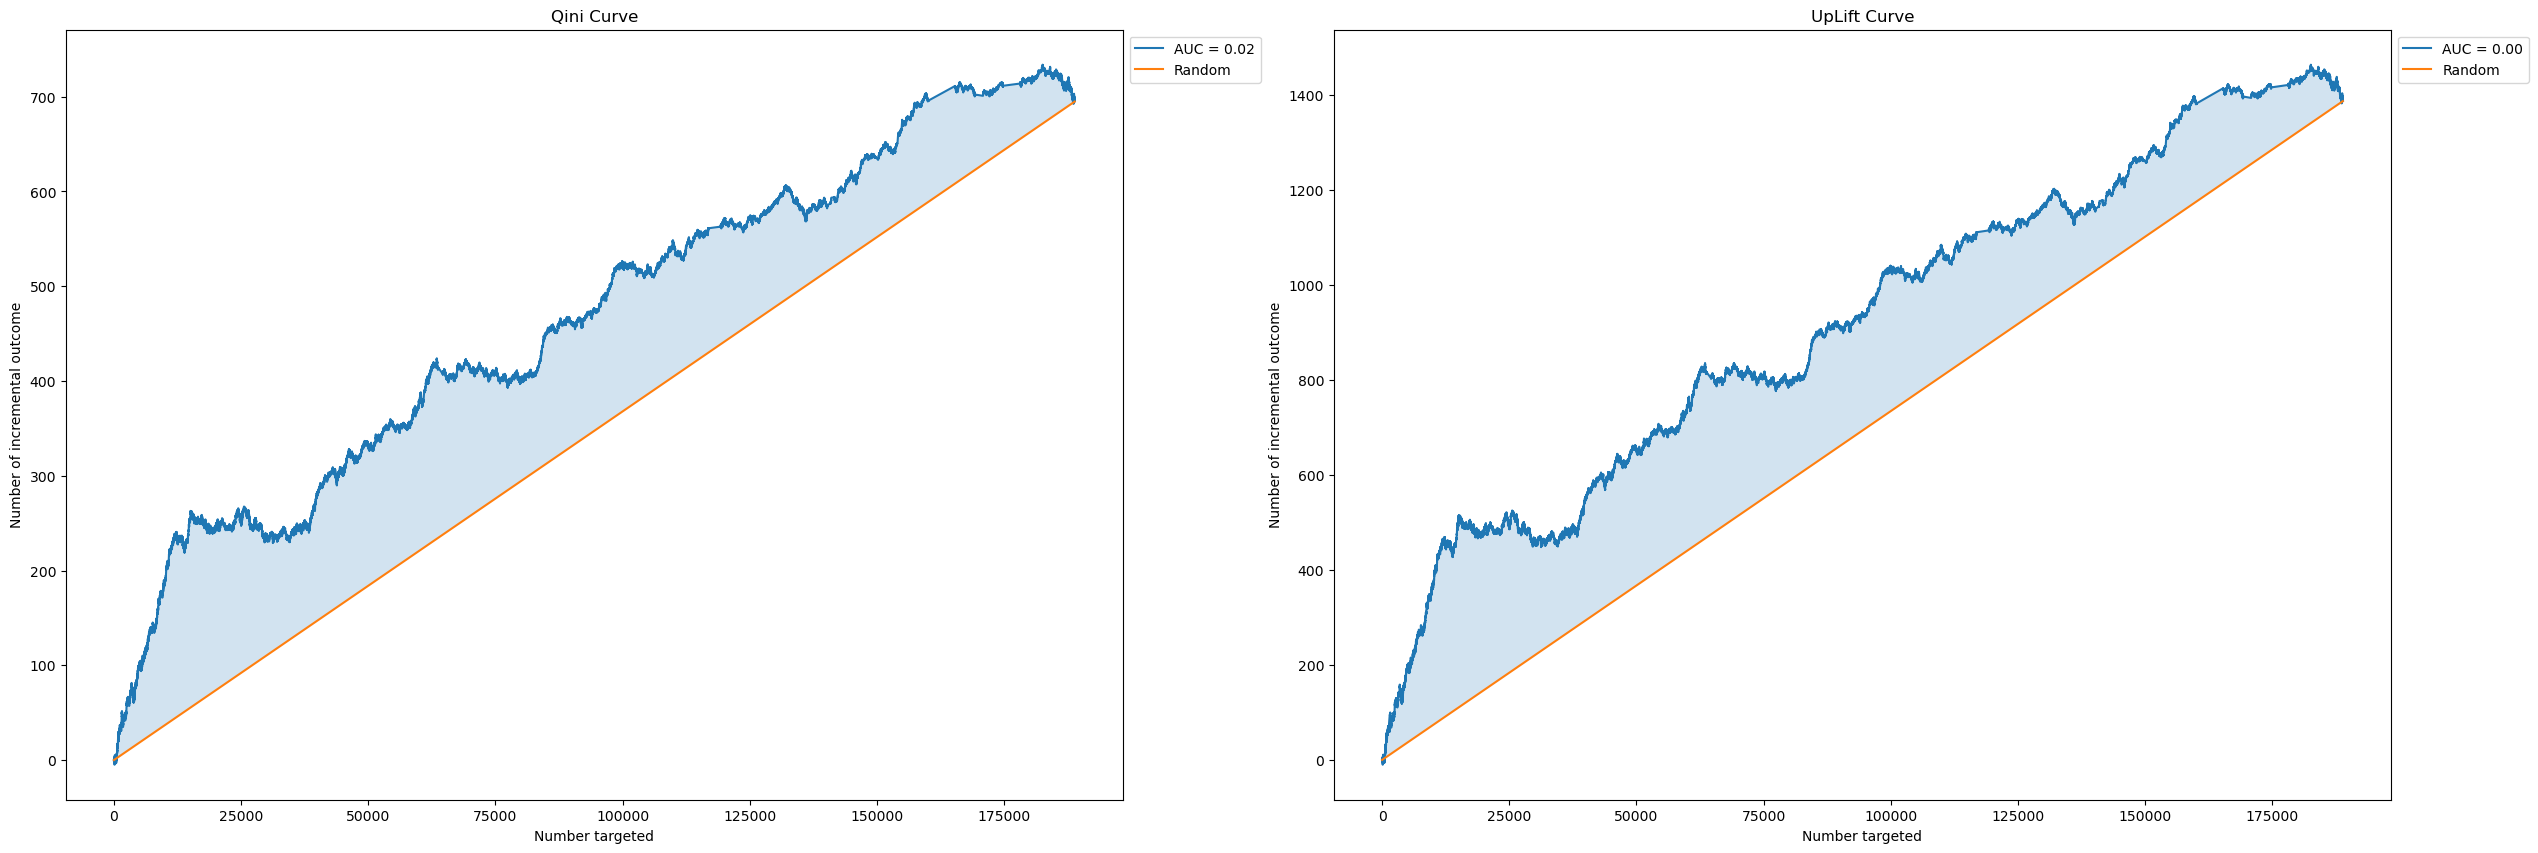

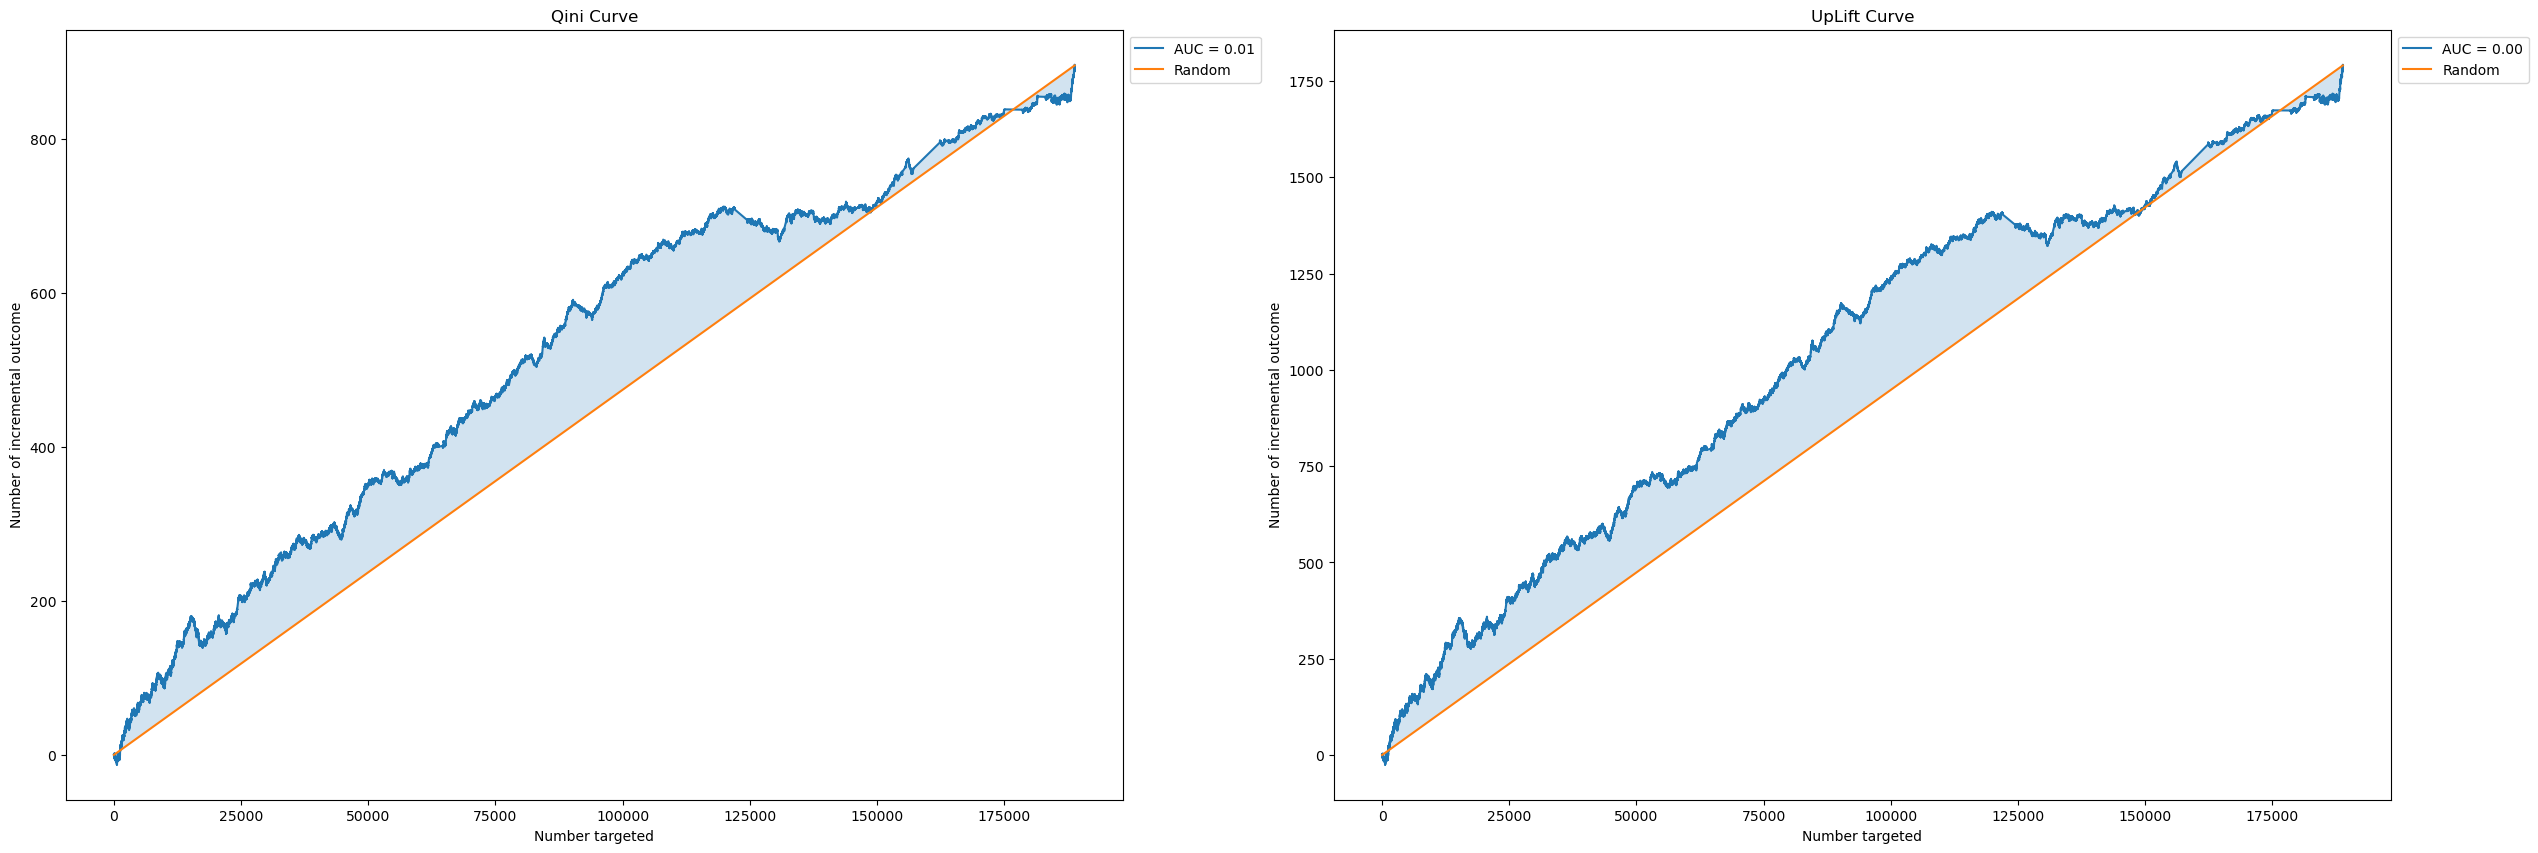

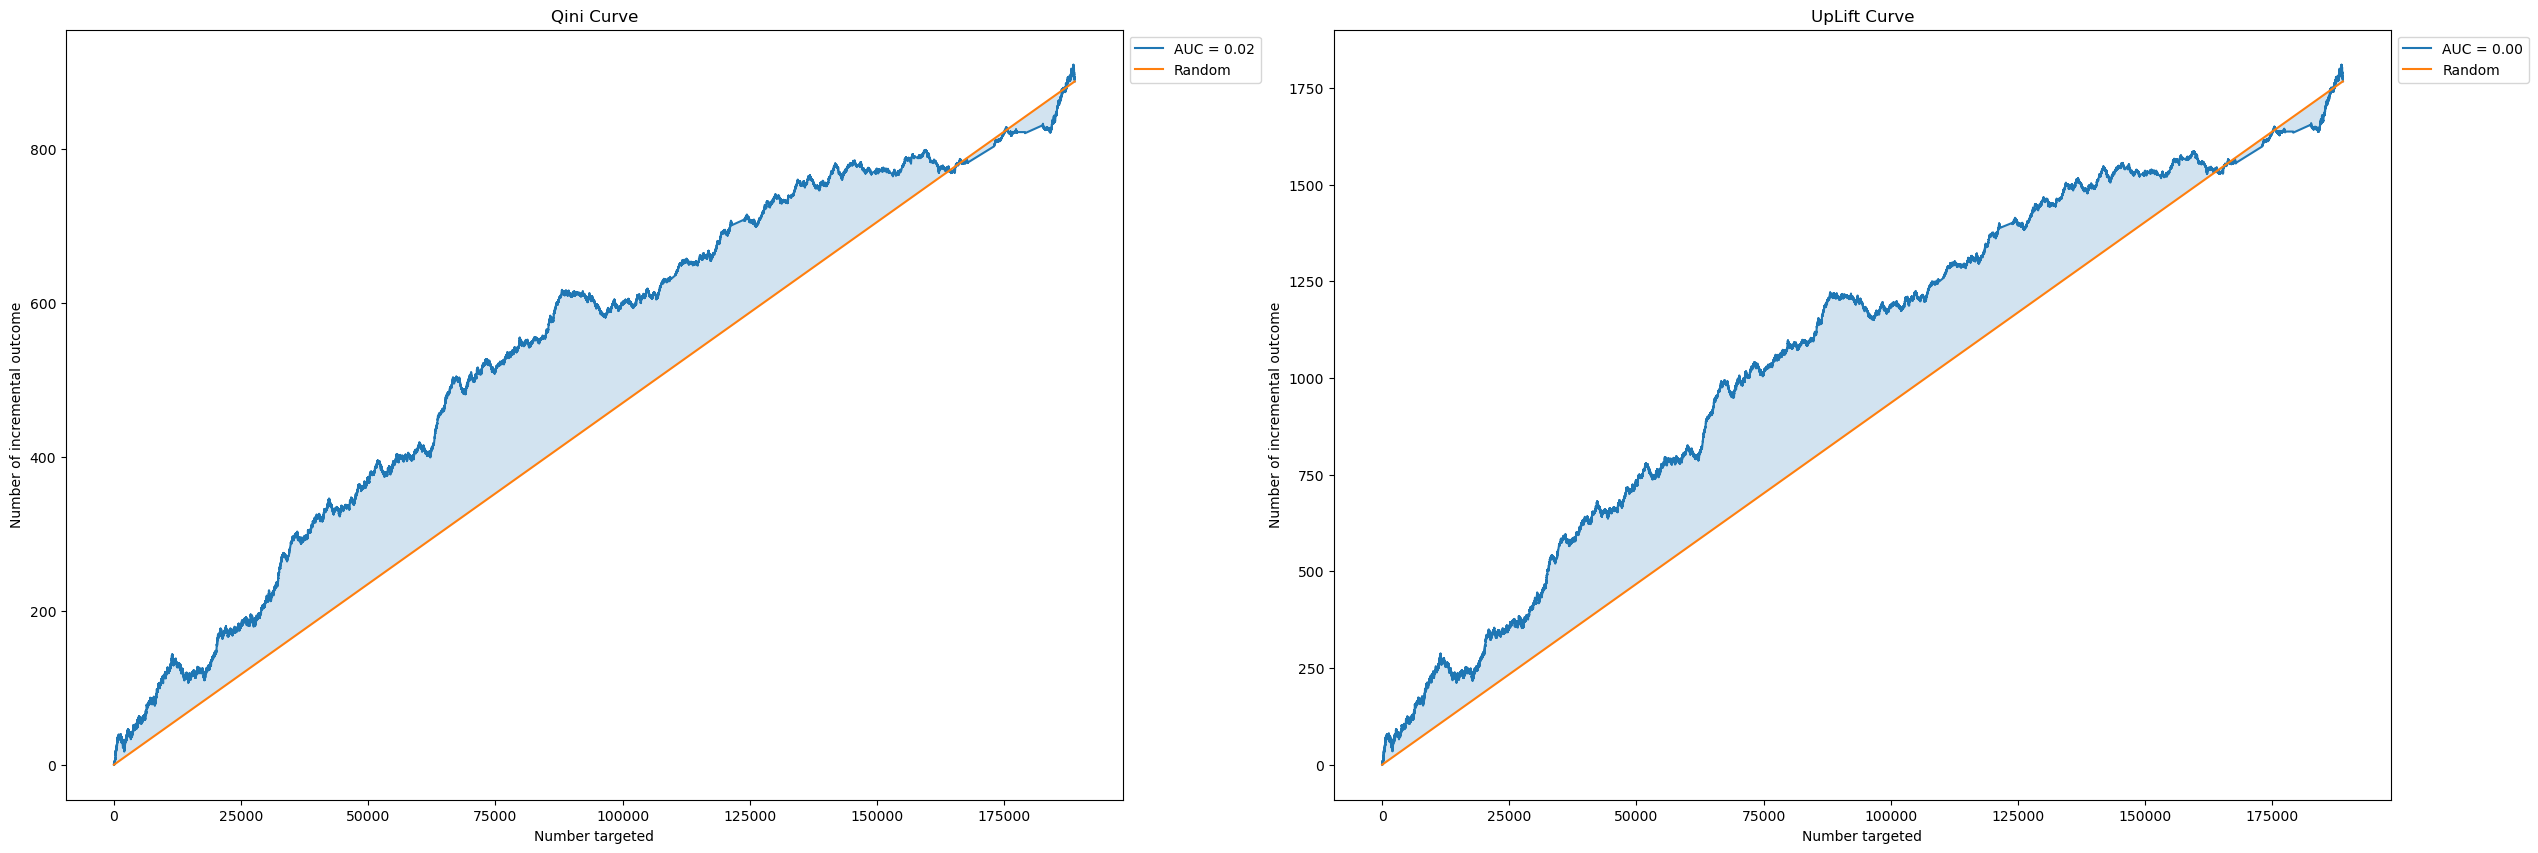

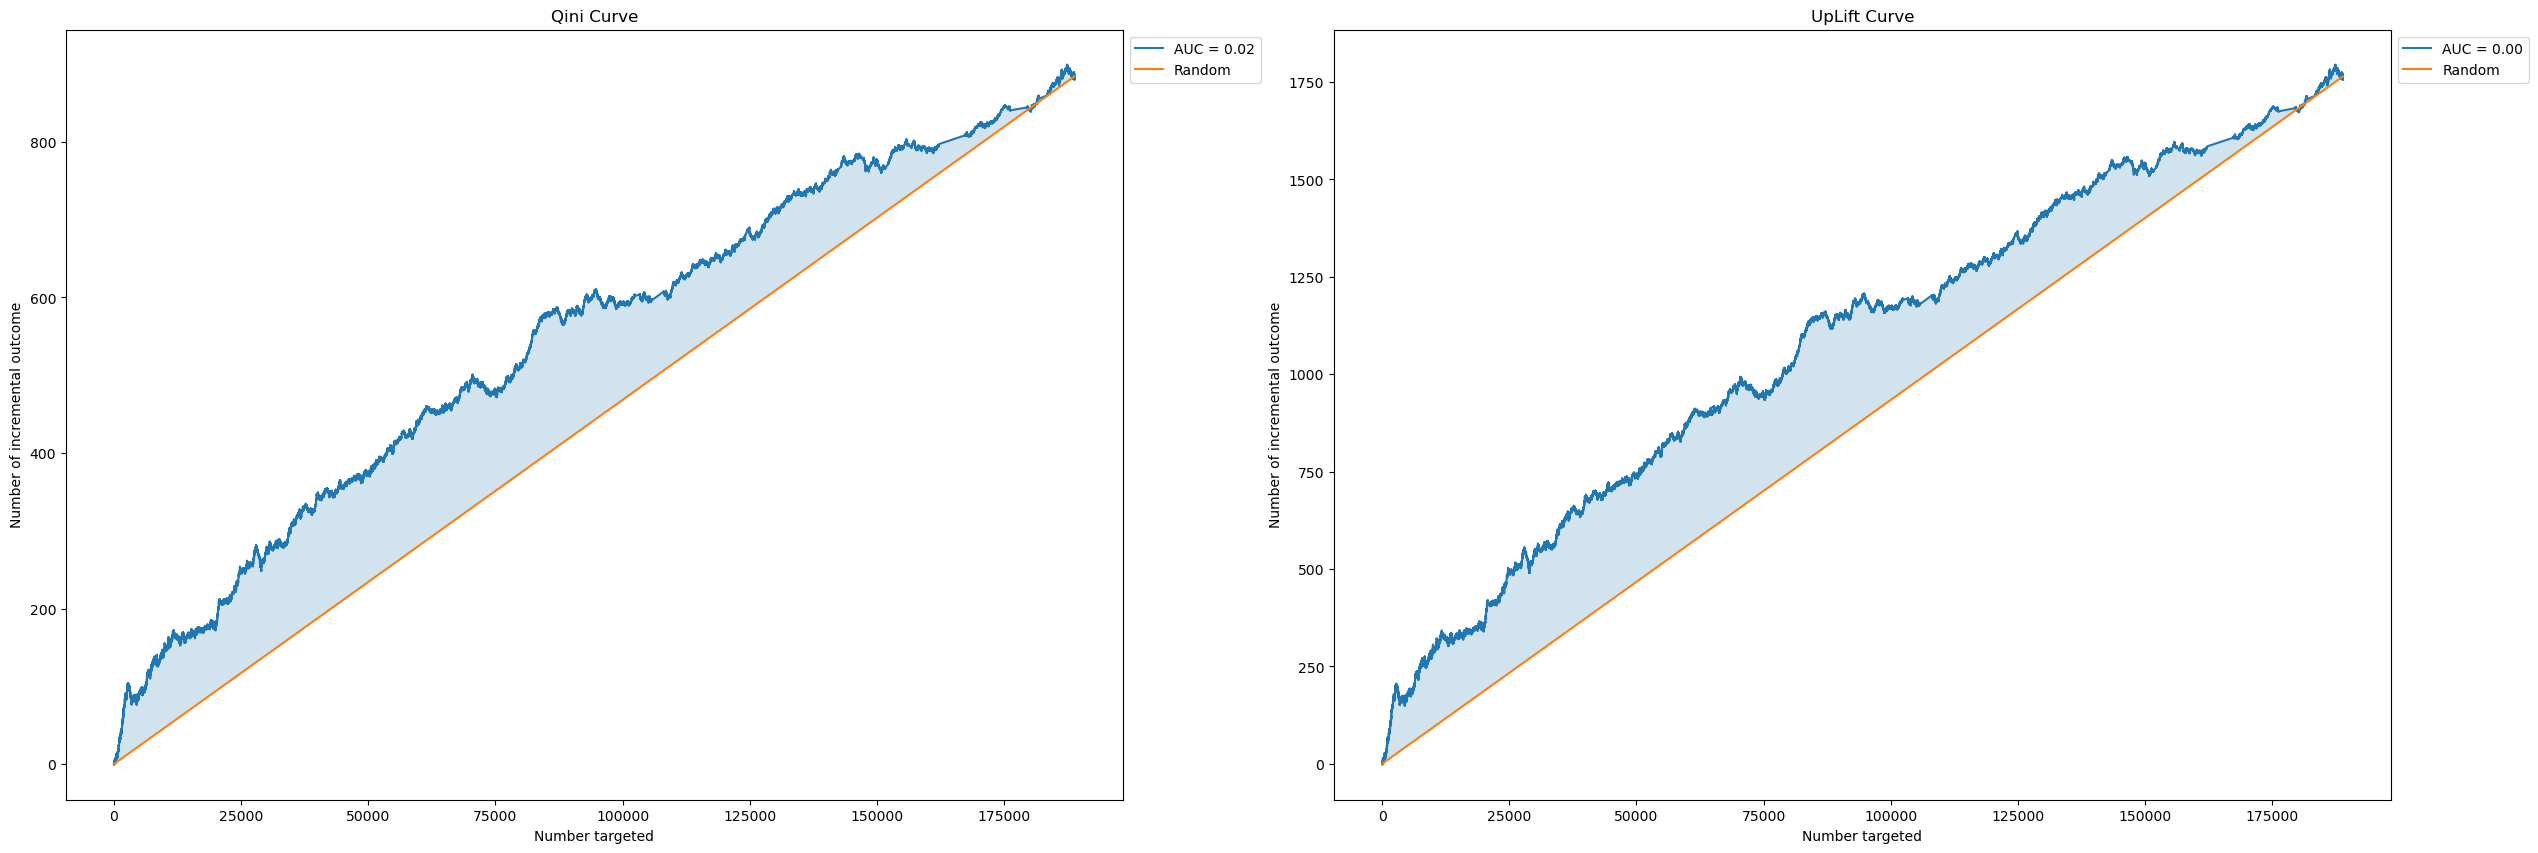

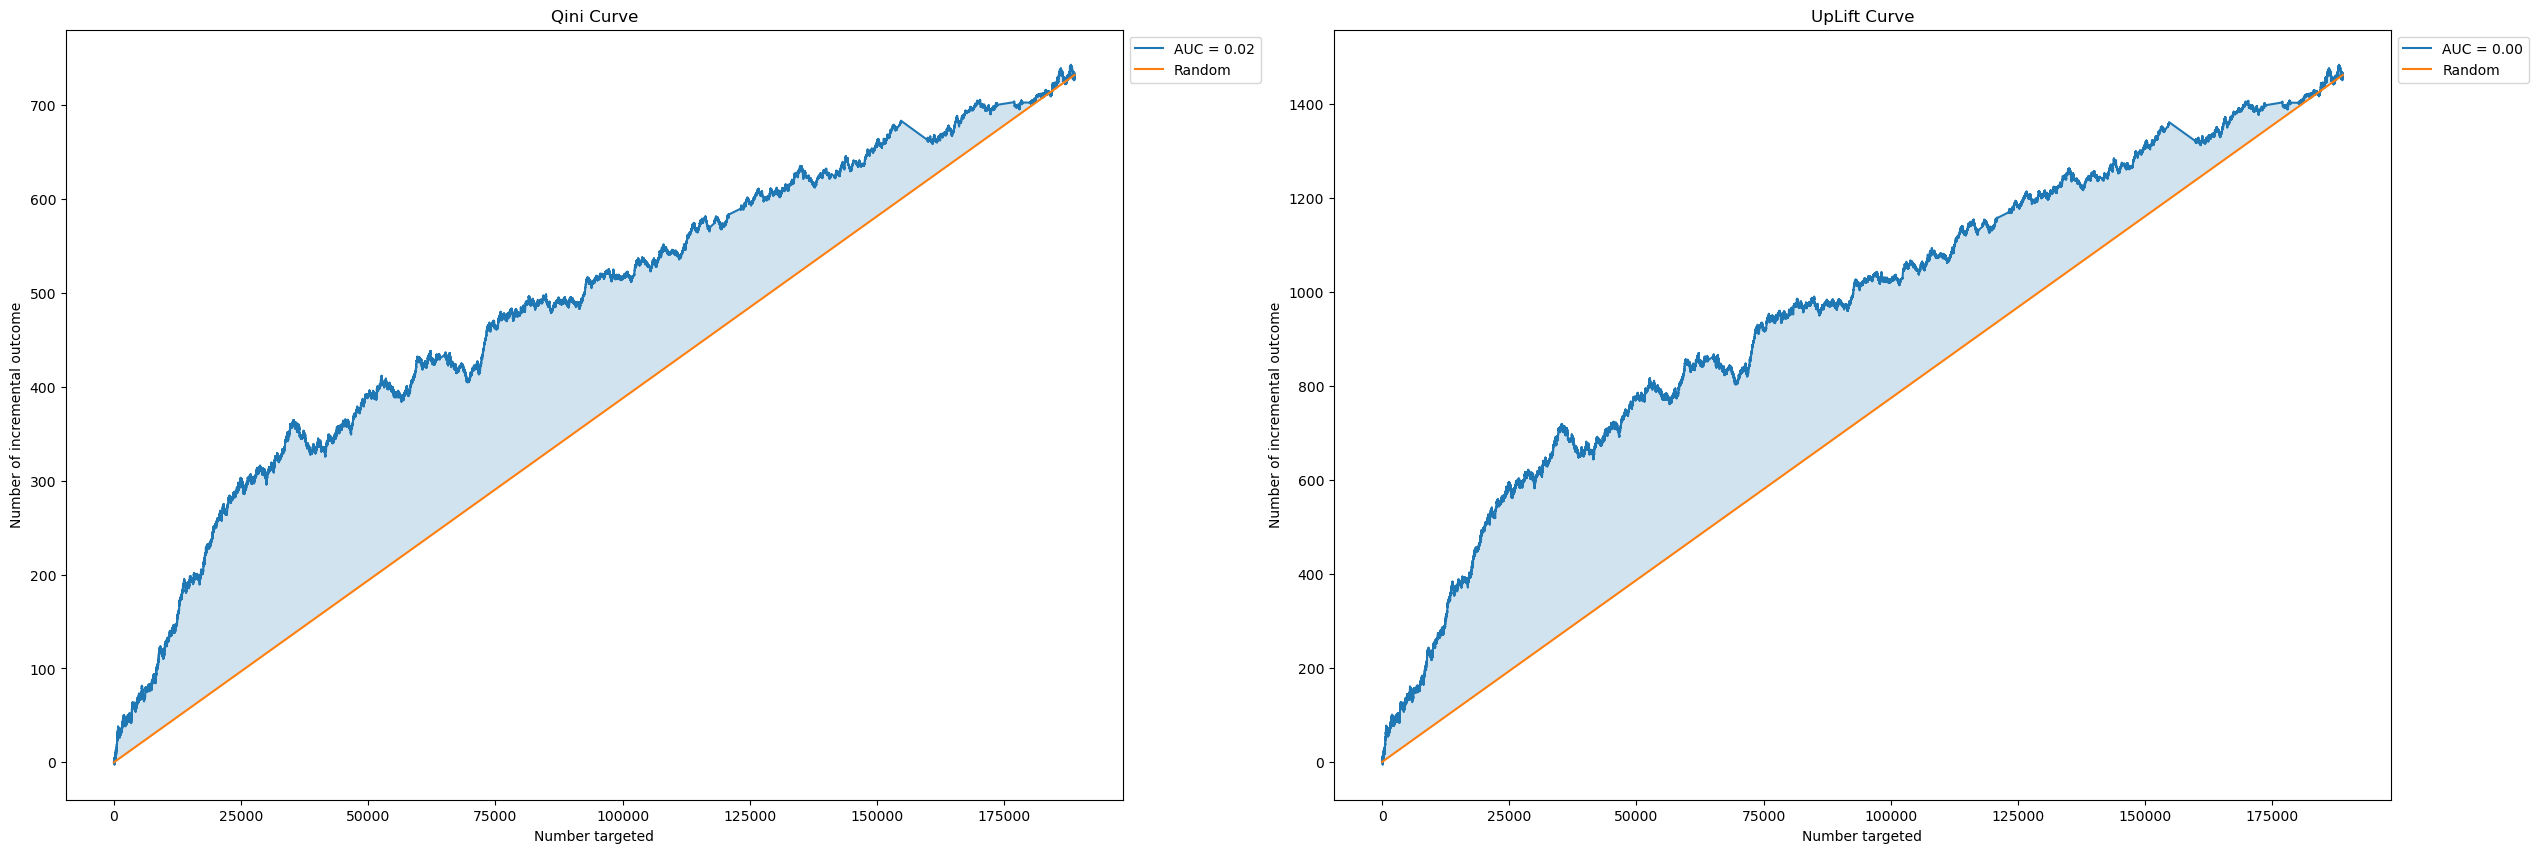

In [18]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = SoloModel(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/One model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
    
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [19]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0134, grouped - 0.0142.
Qini AUC Score: 0.0165; UpLift AUC Score: 0.0041


In [20]:
gc.collect()

40148

In [21]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

0

# Метод двух моделей

In [22]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt







var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

UpLift at 30%: overall - 0.010653, grouped - 0.011328.
Qini AUC Score: 0.008737; UpLift AUC Score: 0.002169
UpLift at 30%: overall - 0.0129, grouped - 0.013.
Qini AUC Score: 0.008886; UpLift AUC Score: 0.002214
UpLift at 30%: overall - 0.015349, grouped - 0.015201.
Qini AUC Score: 0.013812; UpLift AUC Score: 0.003538
UpLift at 30%: overall - 0.014616, grouped - 0.014818.
Qini AUC Score: 0.013936; UpLift AUC Score: 0.003521
UpLift at 30%: overall - 0.012653, grouped - 0.013329.
Qini AUC Score: 0.014731; UpLift AUC Score: 0.003697
UpLift at 30%: overall - 0.0132, grouped - 0.0135.
Qini AUC Score: 0.012; UpLift AUC Score: 0.003


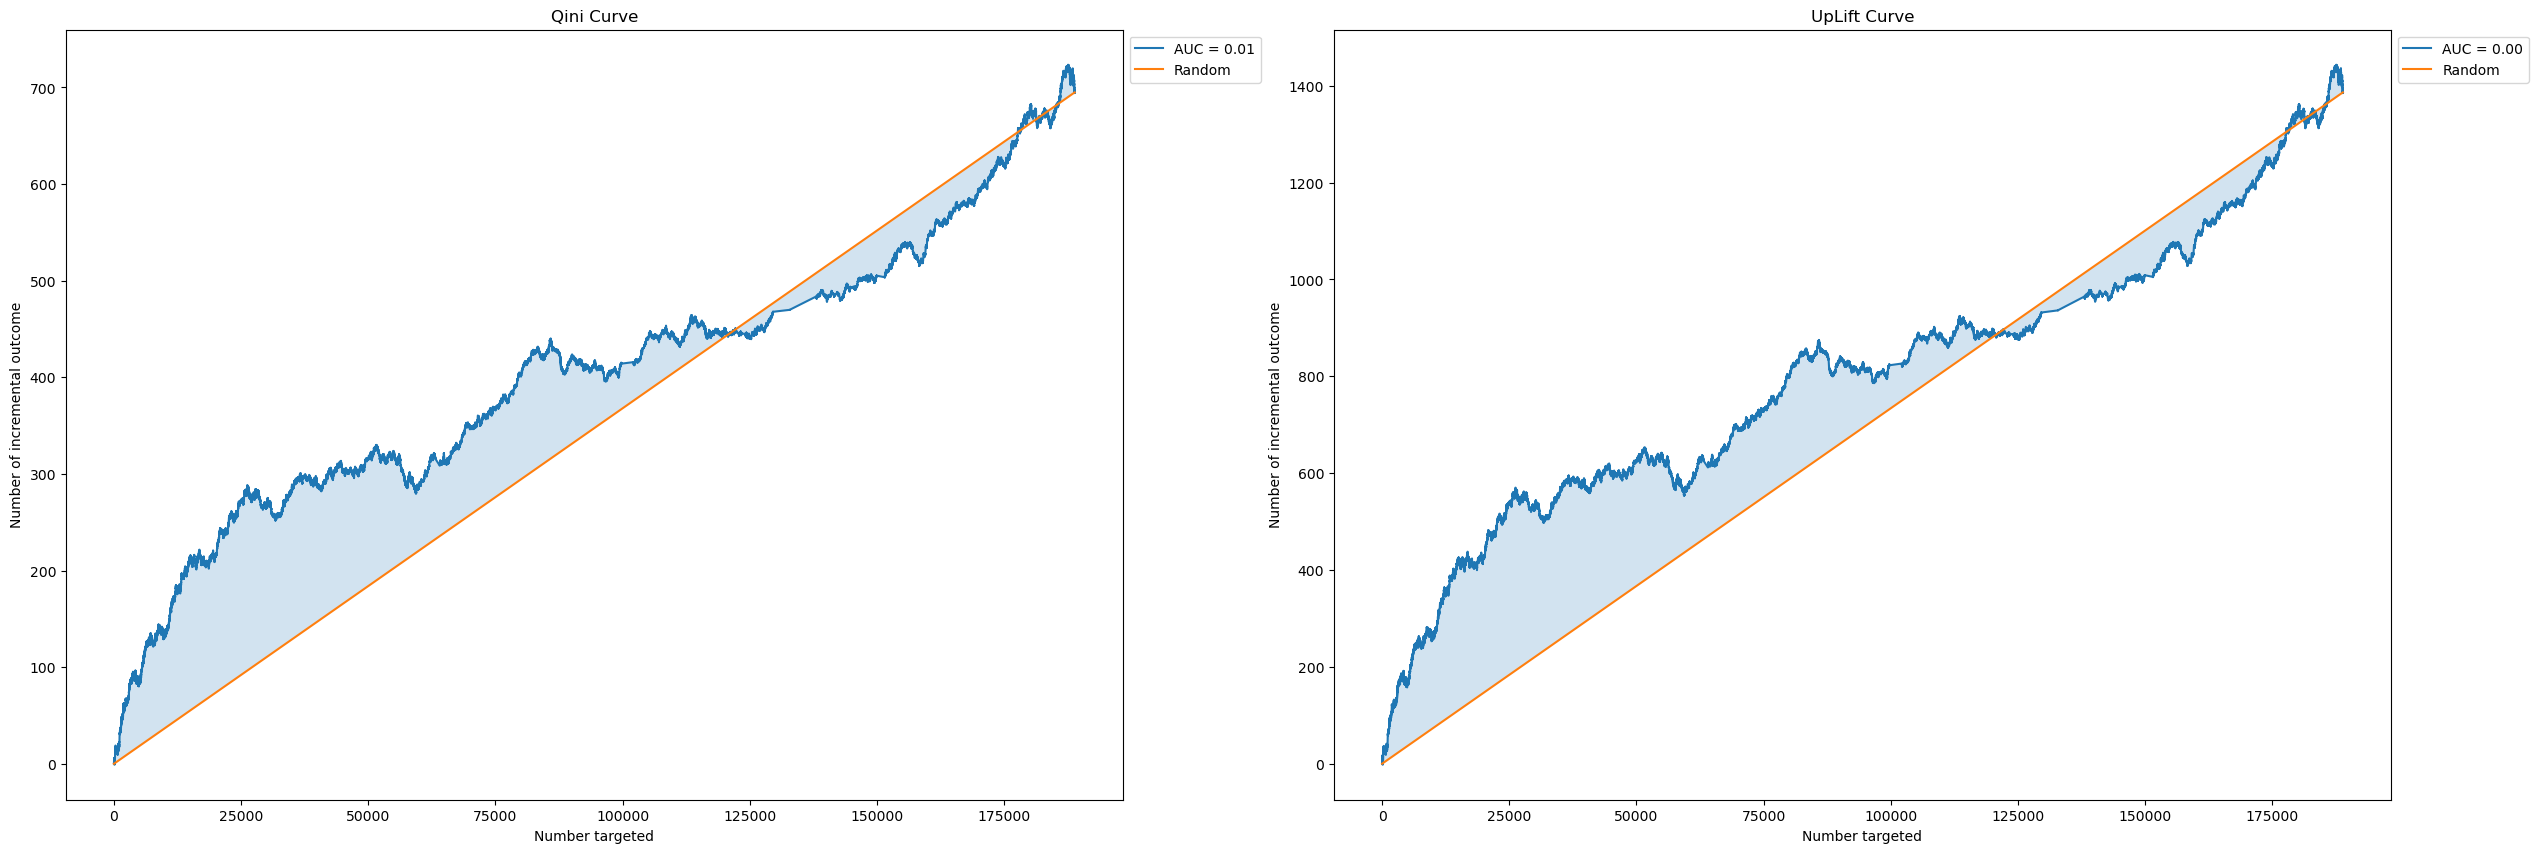

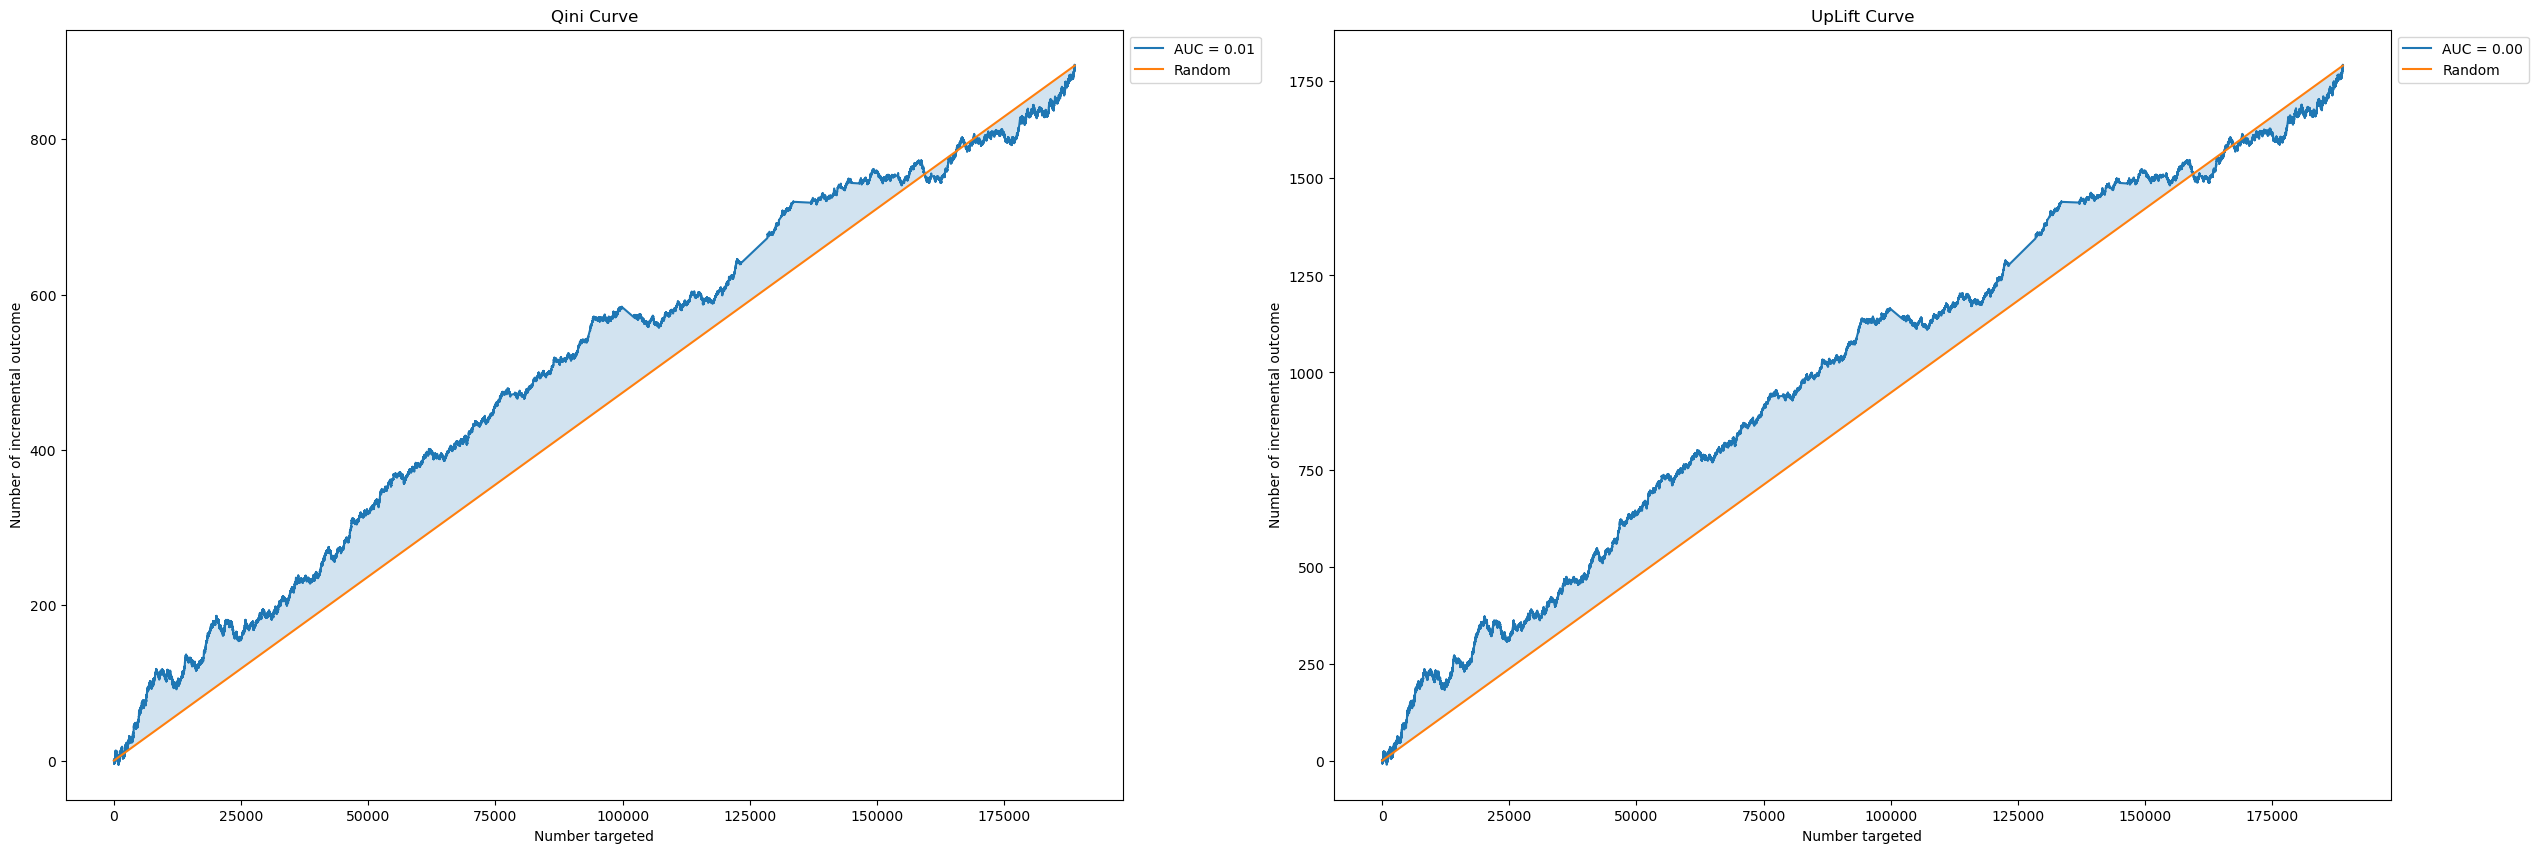

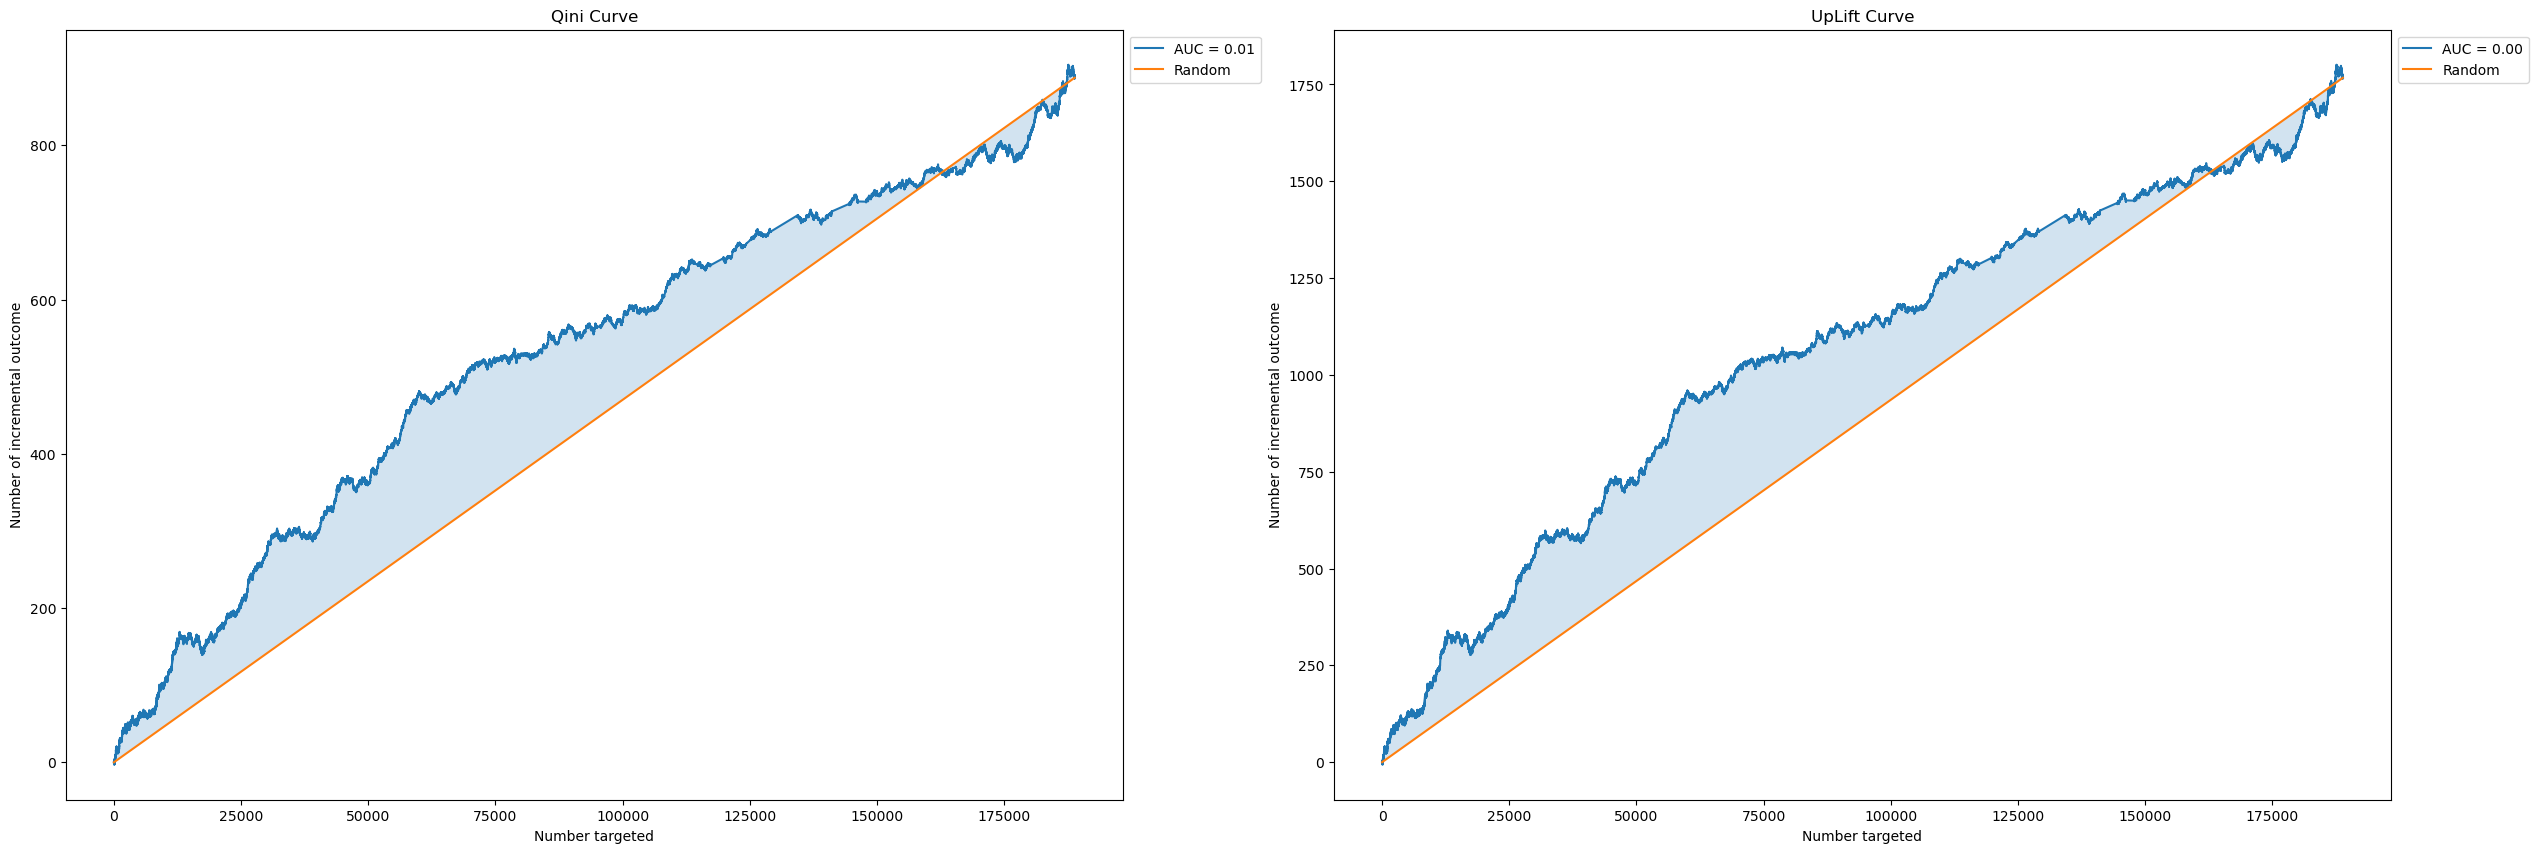

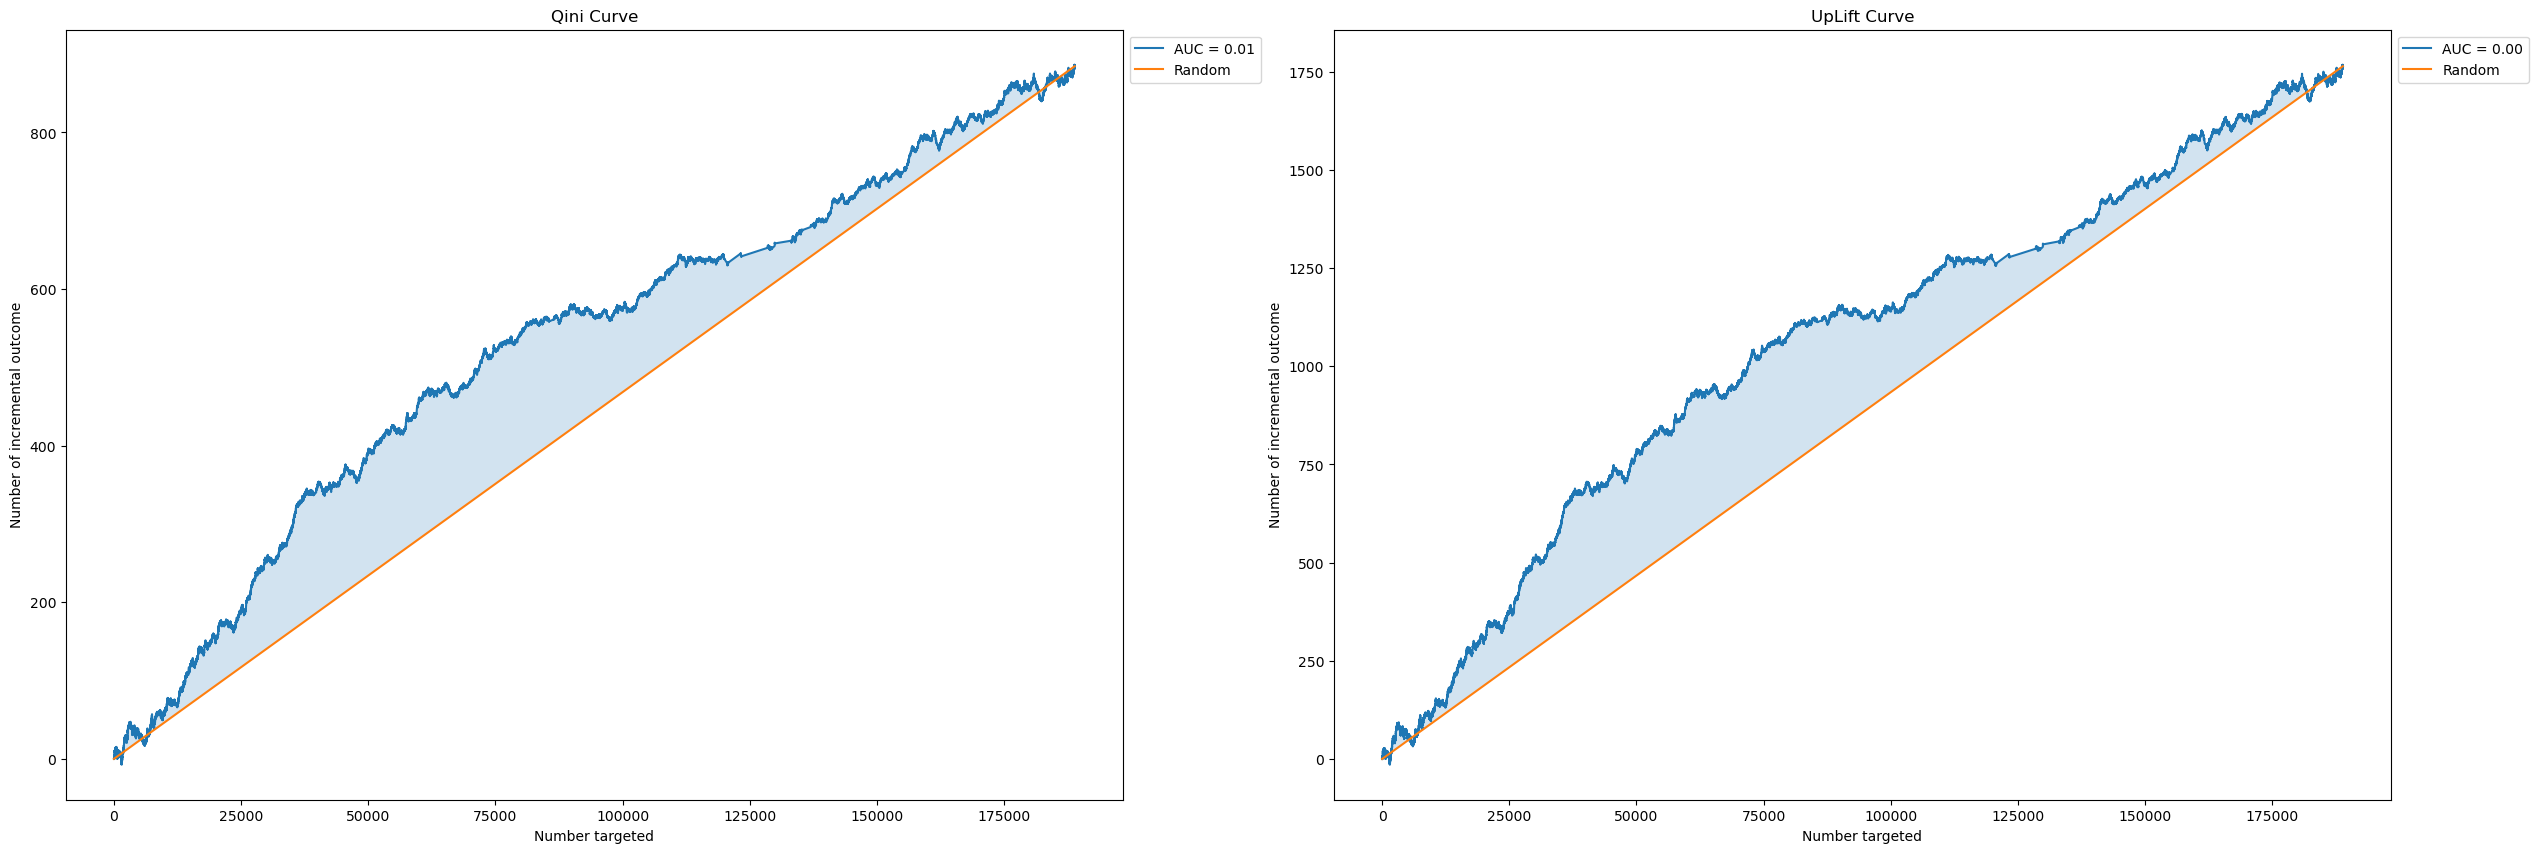

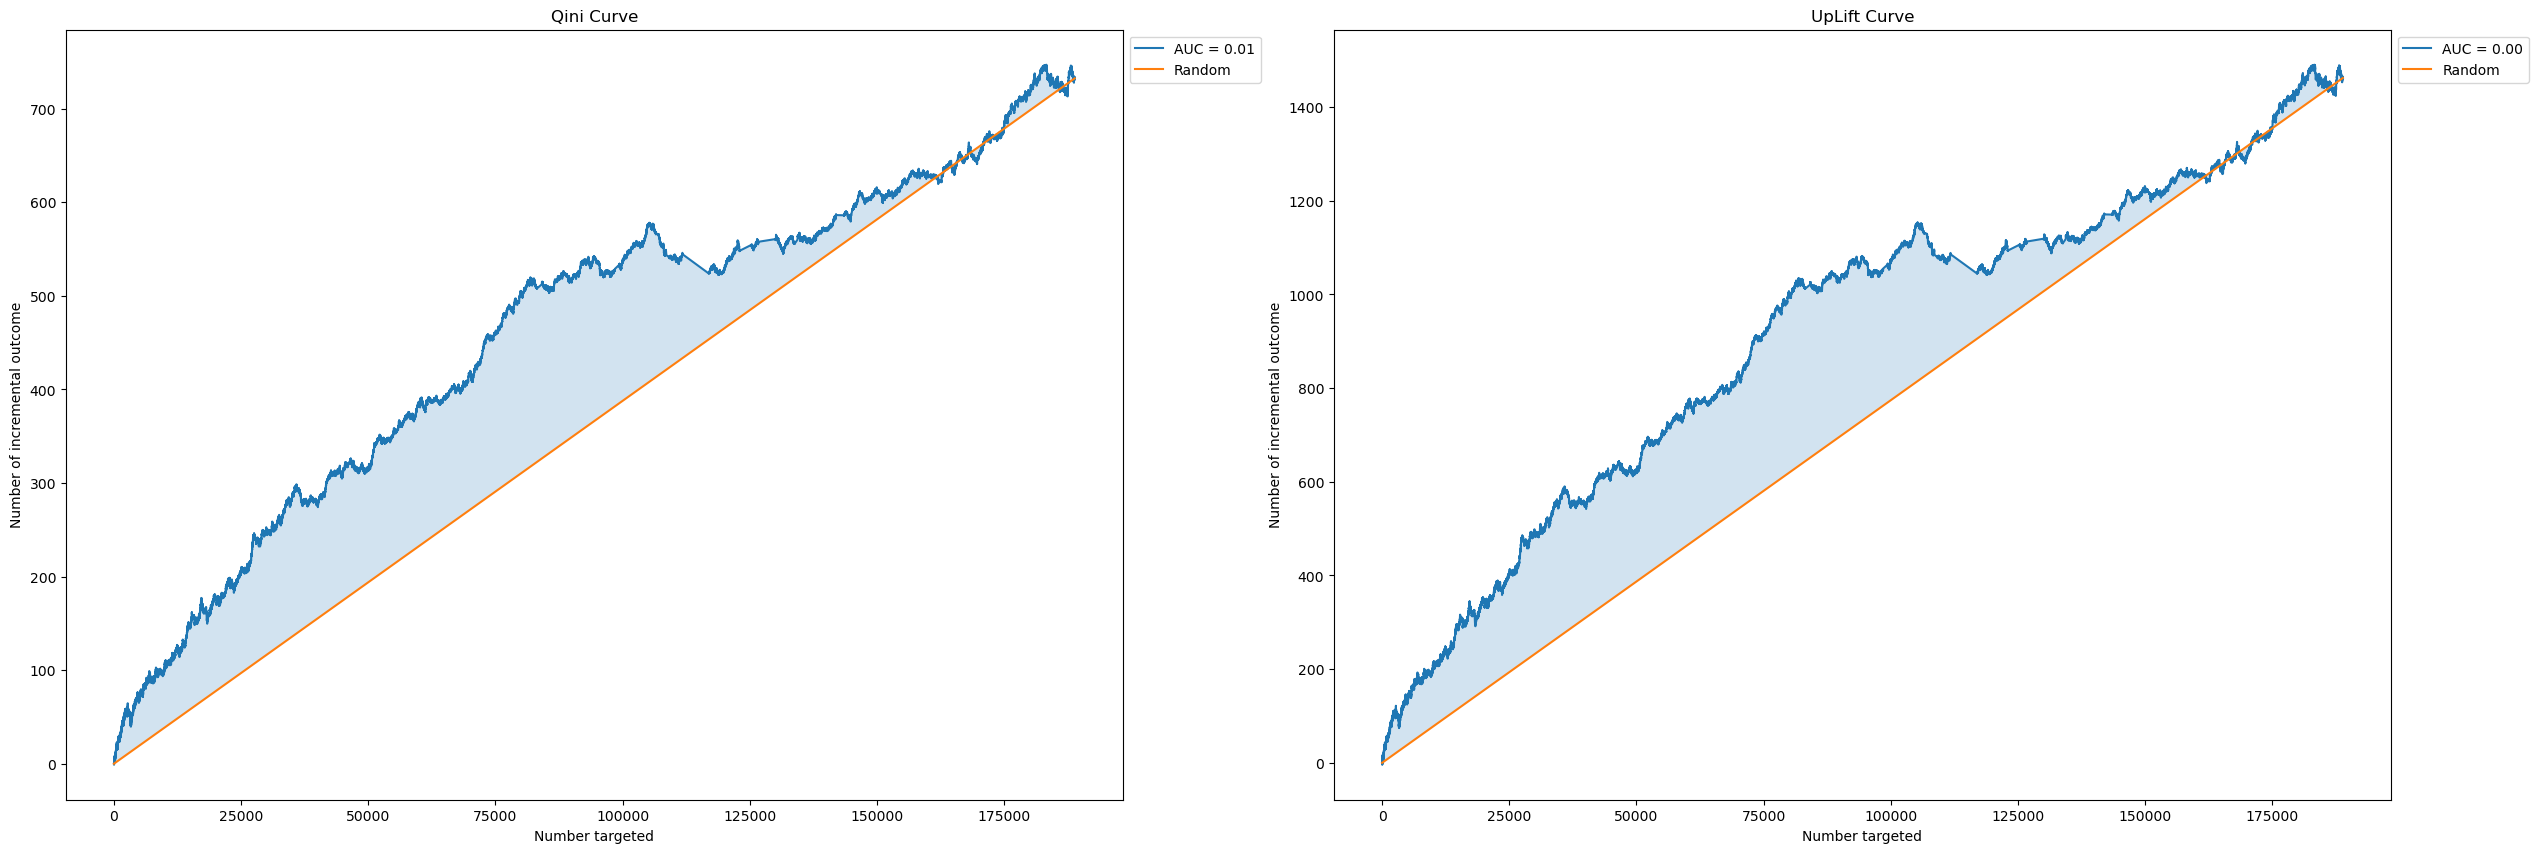

In [23]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf0 = CatBoostClassifier(verbose = 0)
      catboost_clf1 = CatBoostClassifier(verbose = 0)
      clf = TwoModels(estimator_ctrl= catboost_clf0, estimator_trmnt=catboost_clf1)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del catboost_clf0
      del catboost_clf1
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Two models Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1



uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [24]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0132, grouped - 0.0135.
Qini AUC Score: 0.012; UpLift AUC Score: 0.003


In [25]:
del X_data
del Y_data
del treat
del y
gc.collect()

40148

# Метод трансформации класса (Классификация)

In [26]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


UpLift at 30%: overall - 0.009808, grouped - 0.009104.
Qini AUC Score: 0.00334; UpLift AUC Score: 0.001015
UpLift at 30%: overall - 0.012497, grouped - 0.011755.
Qini AUC Score: 0.002603; UpLift AUC Score: 0.000912
UpLift at 30%: overall - 0.009391, grouped - 0.008799.
Qini AUC Score: 0.002275; UpLift AUC Score: 0.000761
UpLift at 30%: overall - 0.012043, grouped - 0.00993.
Qini AUC Score: 0.010311; UpLift AUC Score: 0.002824
UpLift at 30%: overall - 0.010851, grouped - 0.009034.
Qini AUC Score: 0.009011; UpLift AUC Score: 0.002426
UpLift at 30%: overall - 0.0109, grouped - 0.0097.
Qini AUC Score: 0.0055; UpLift AUC Score: 0.0016


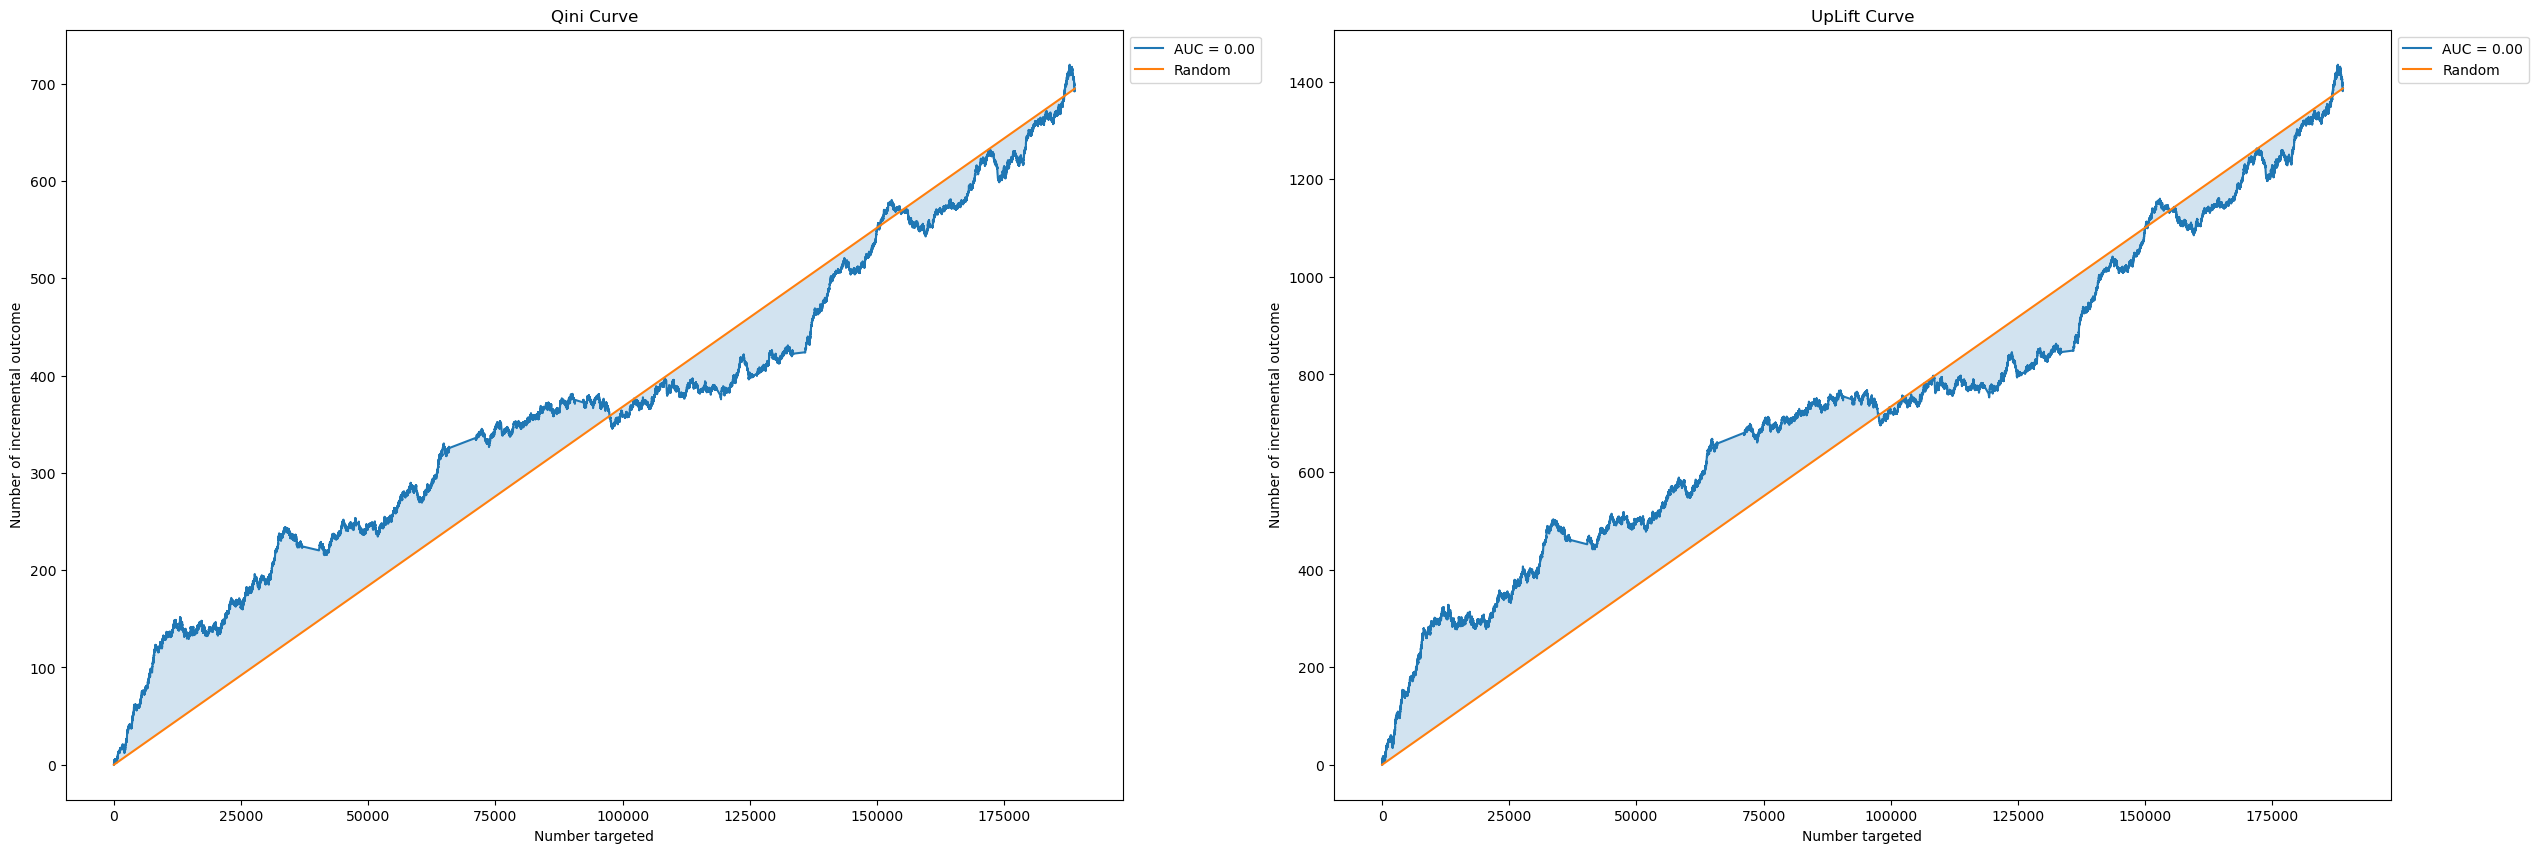

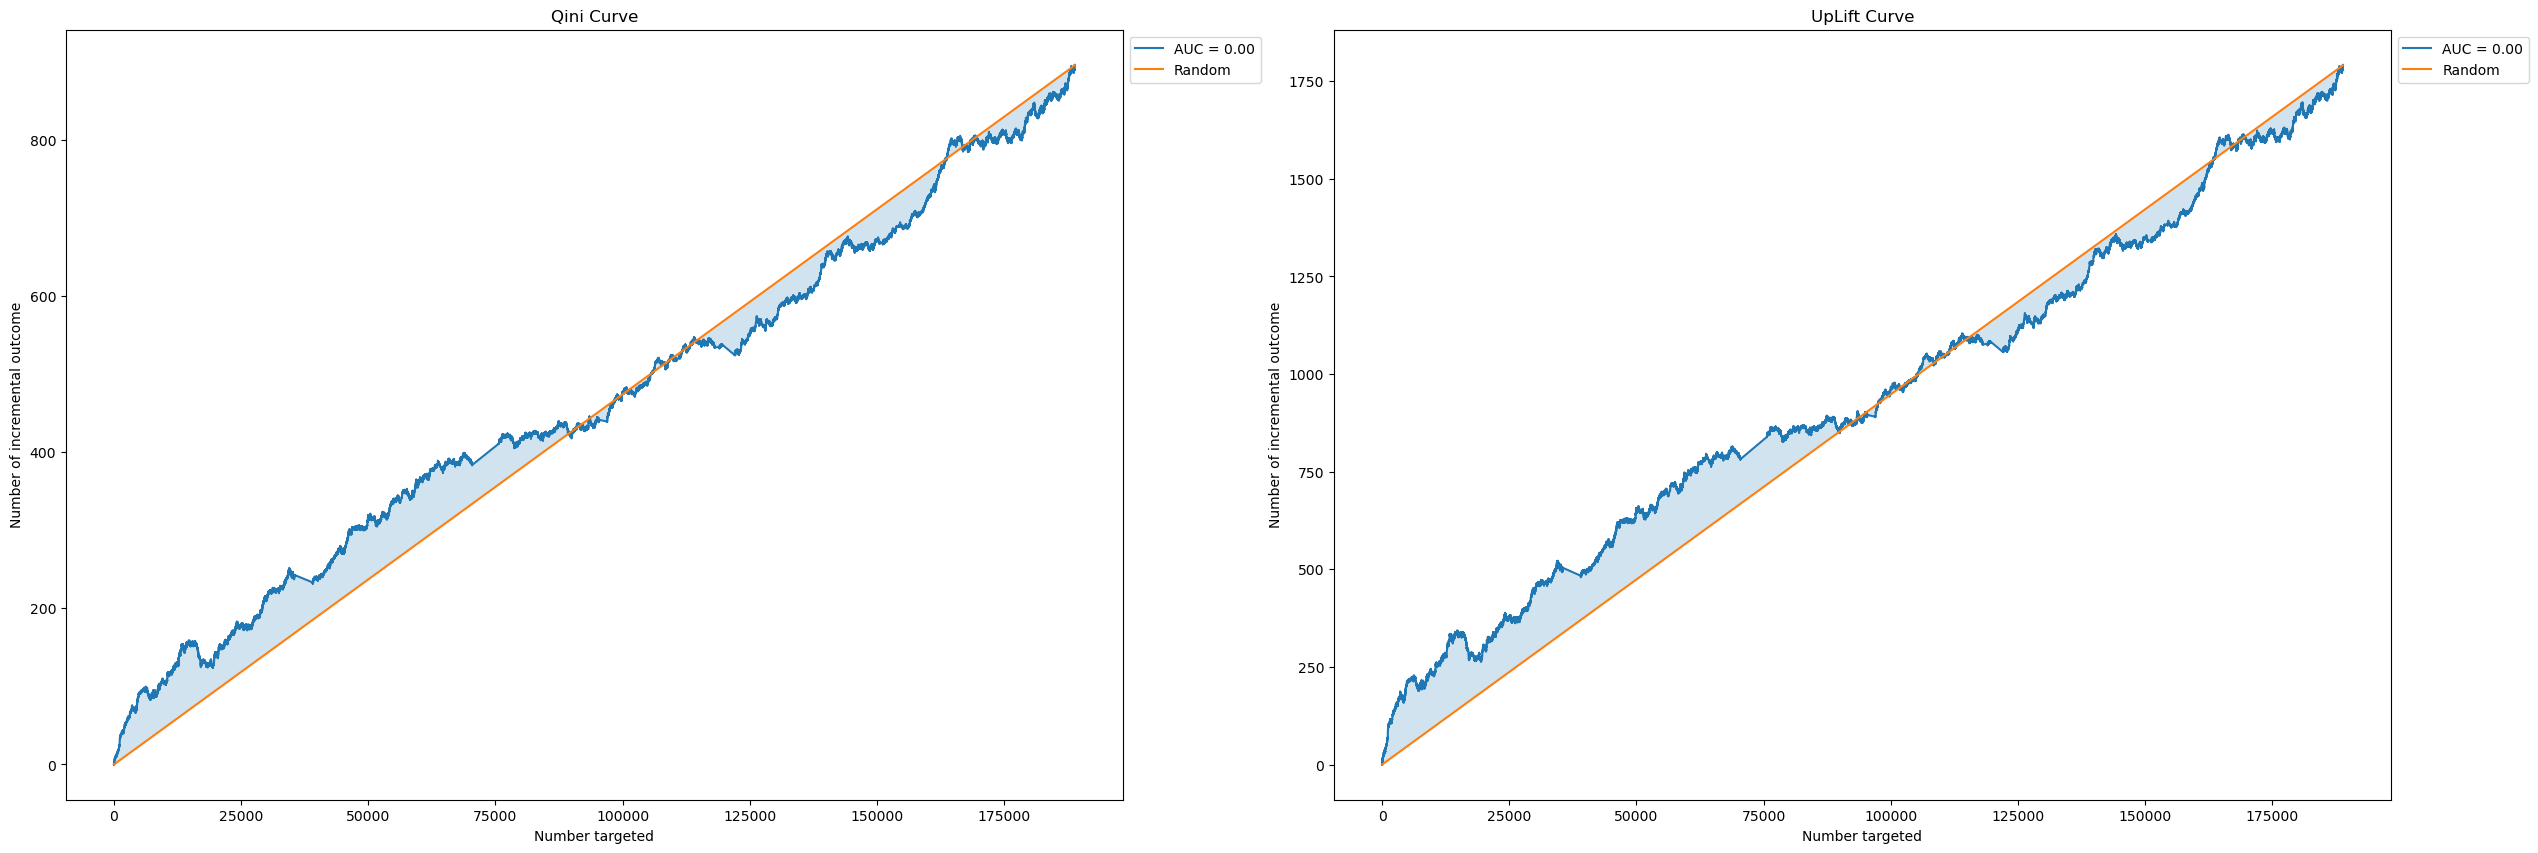

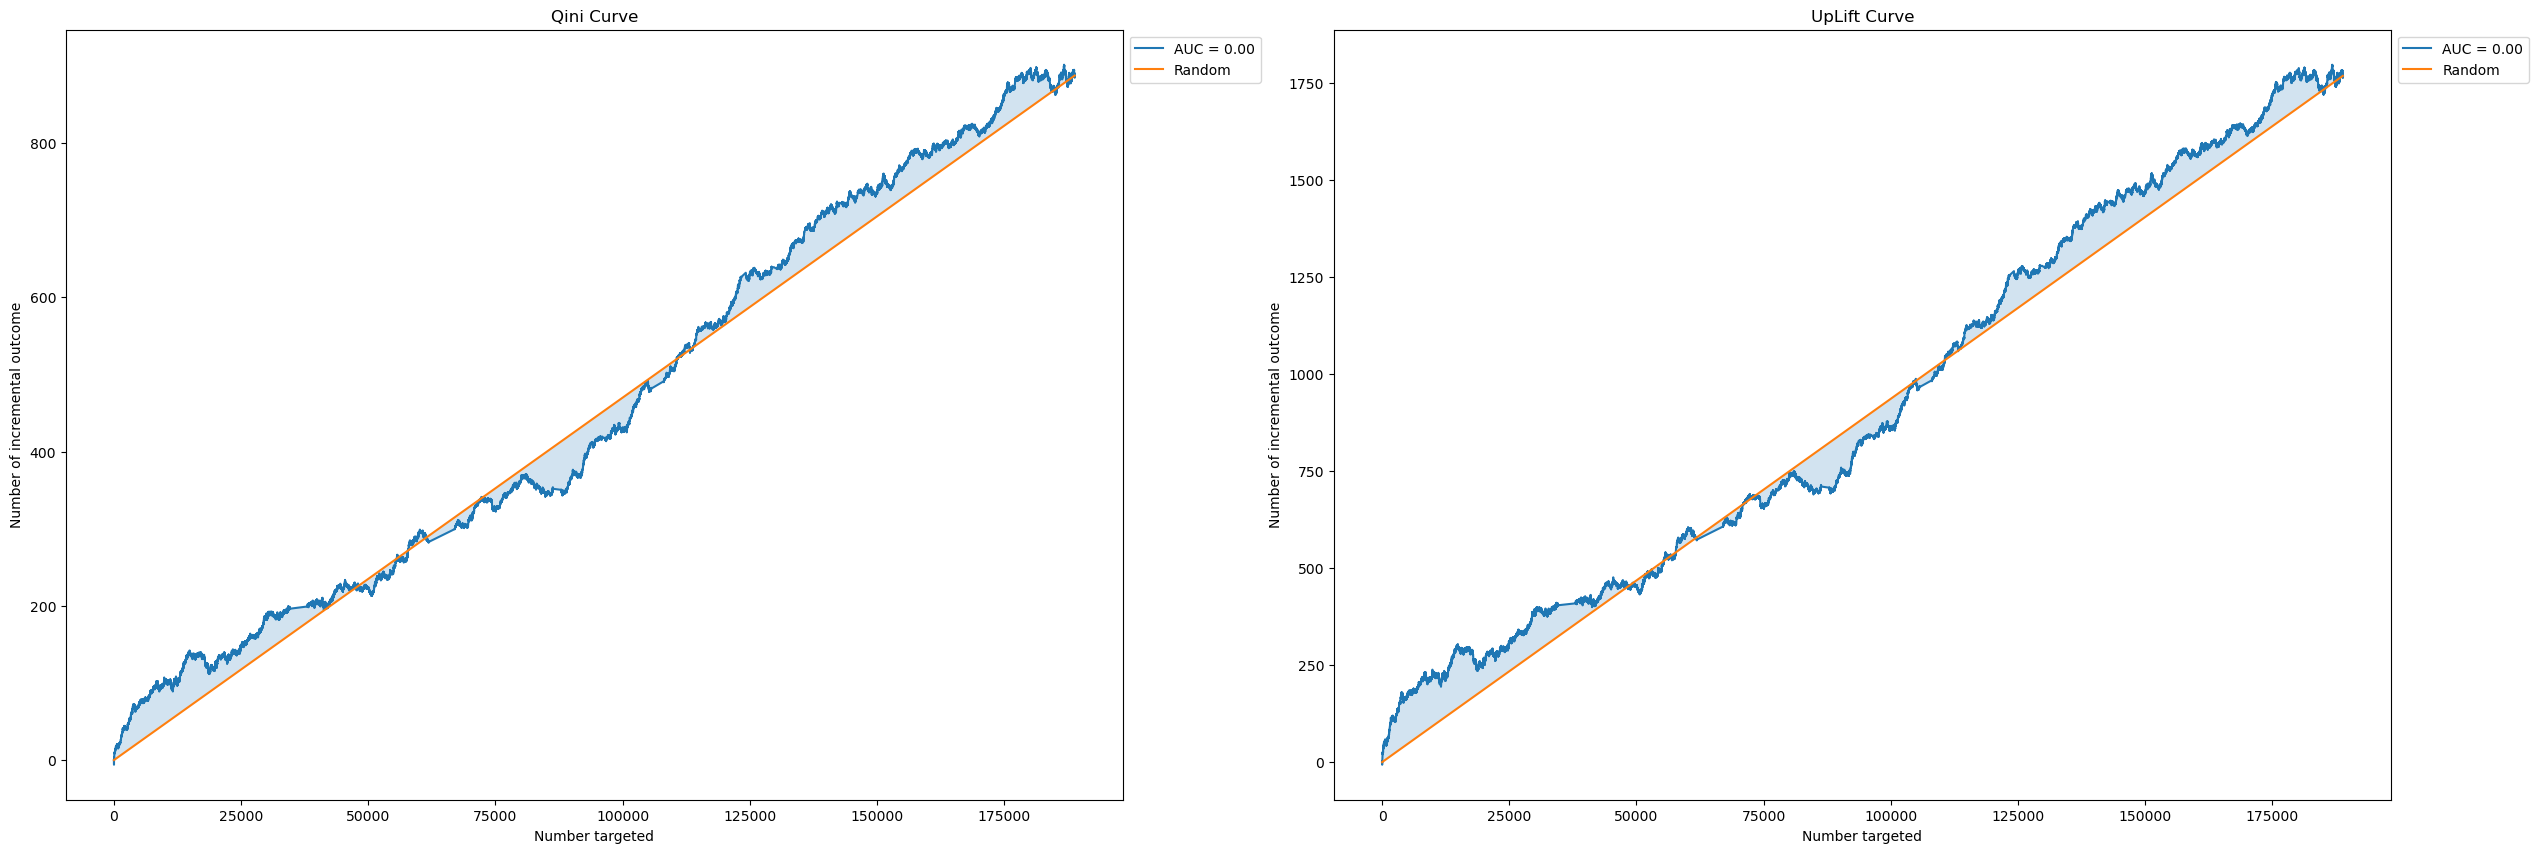

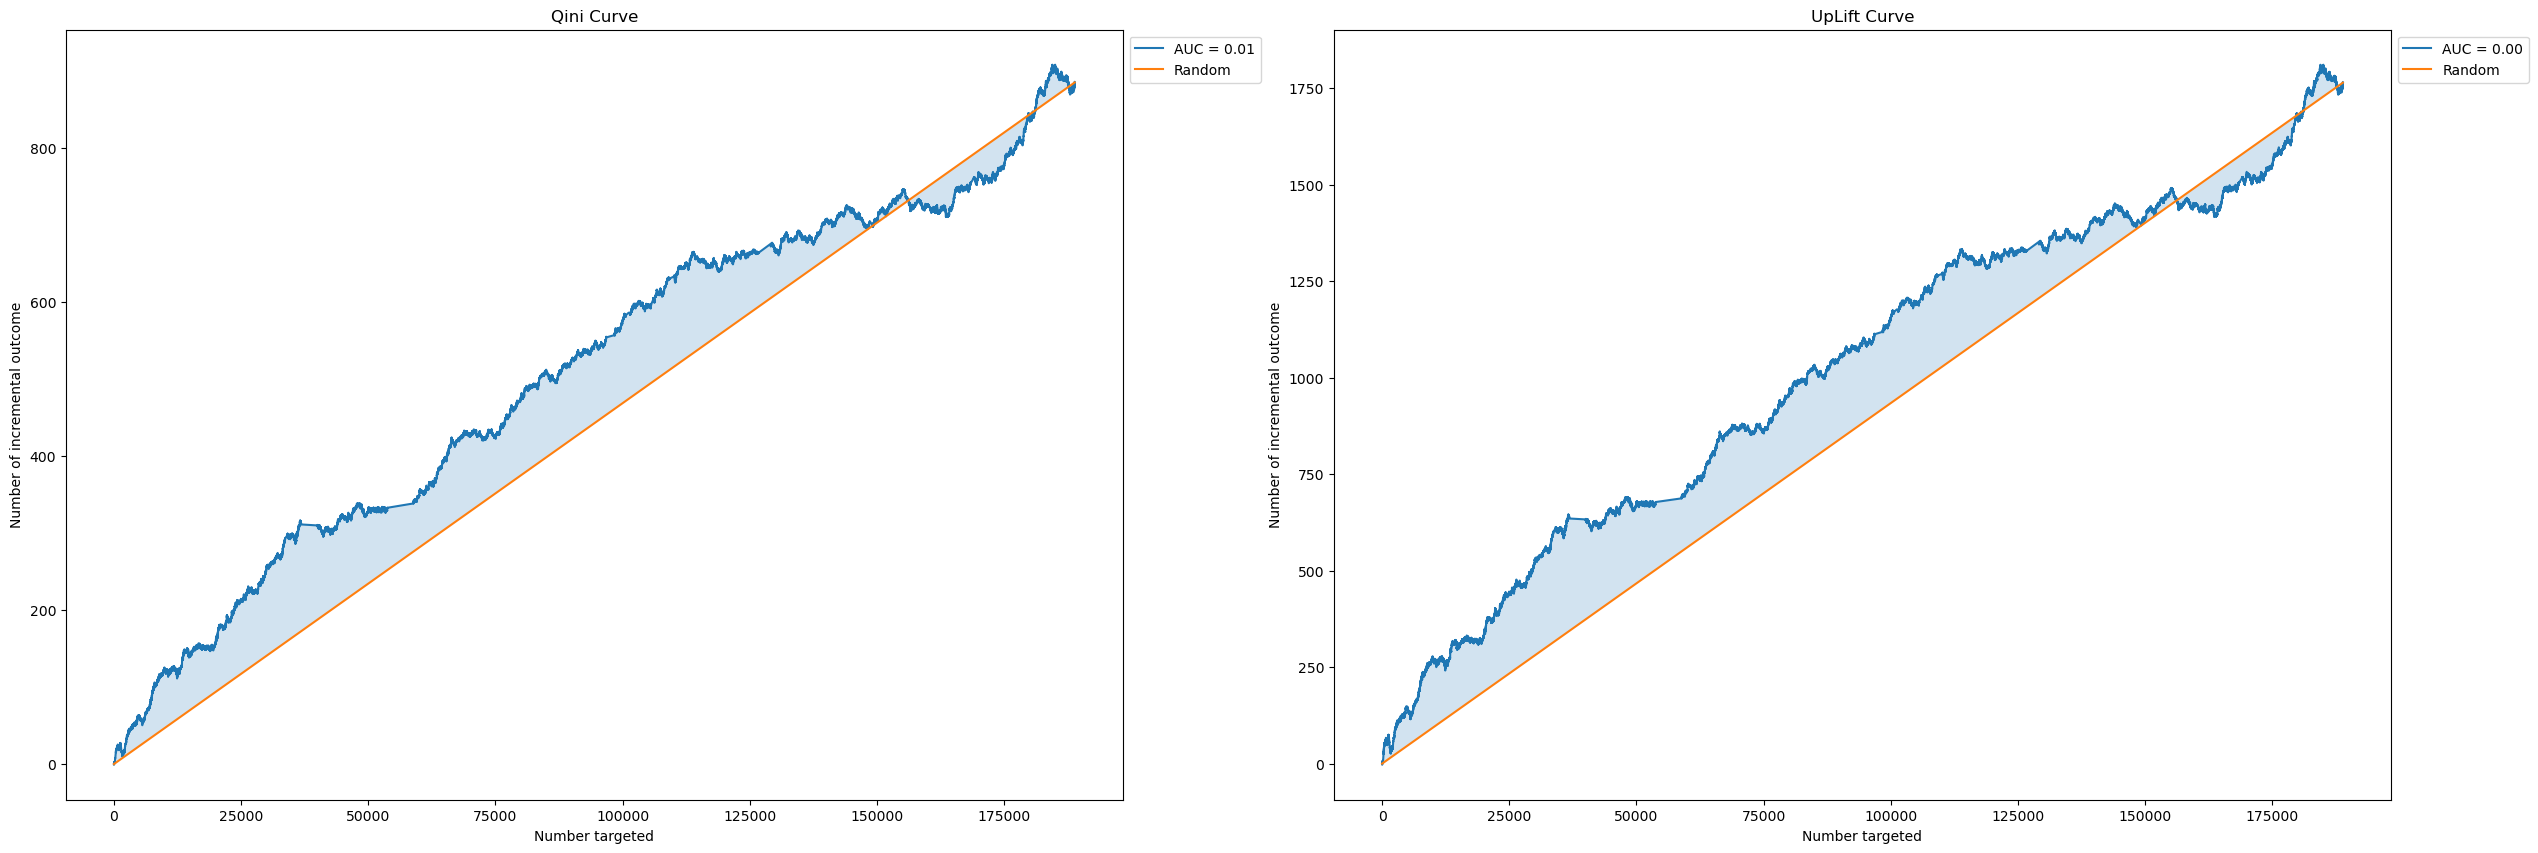

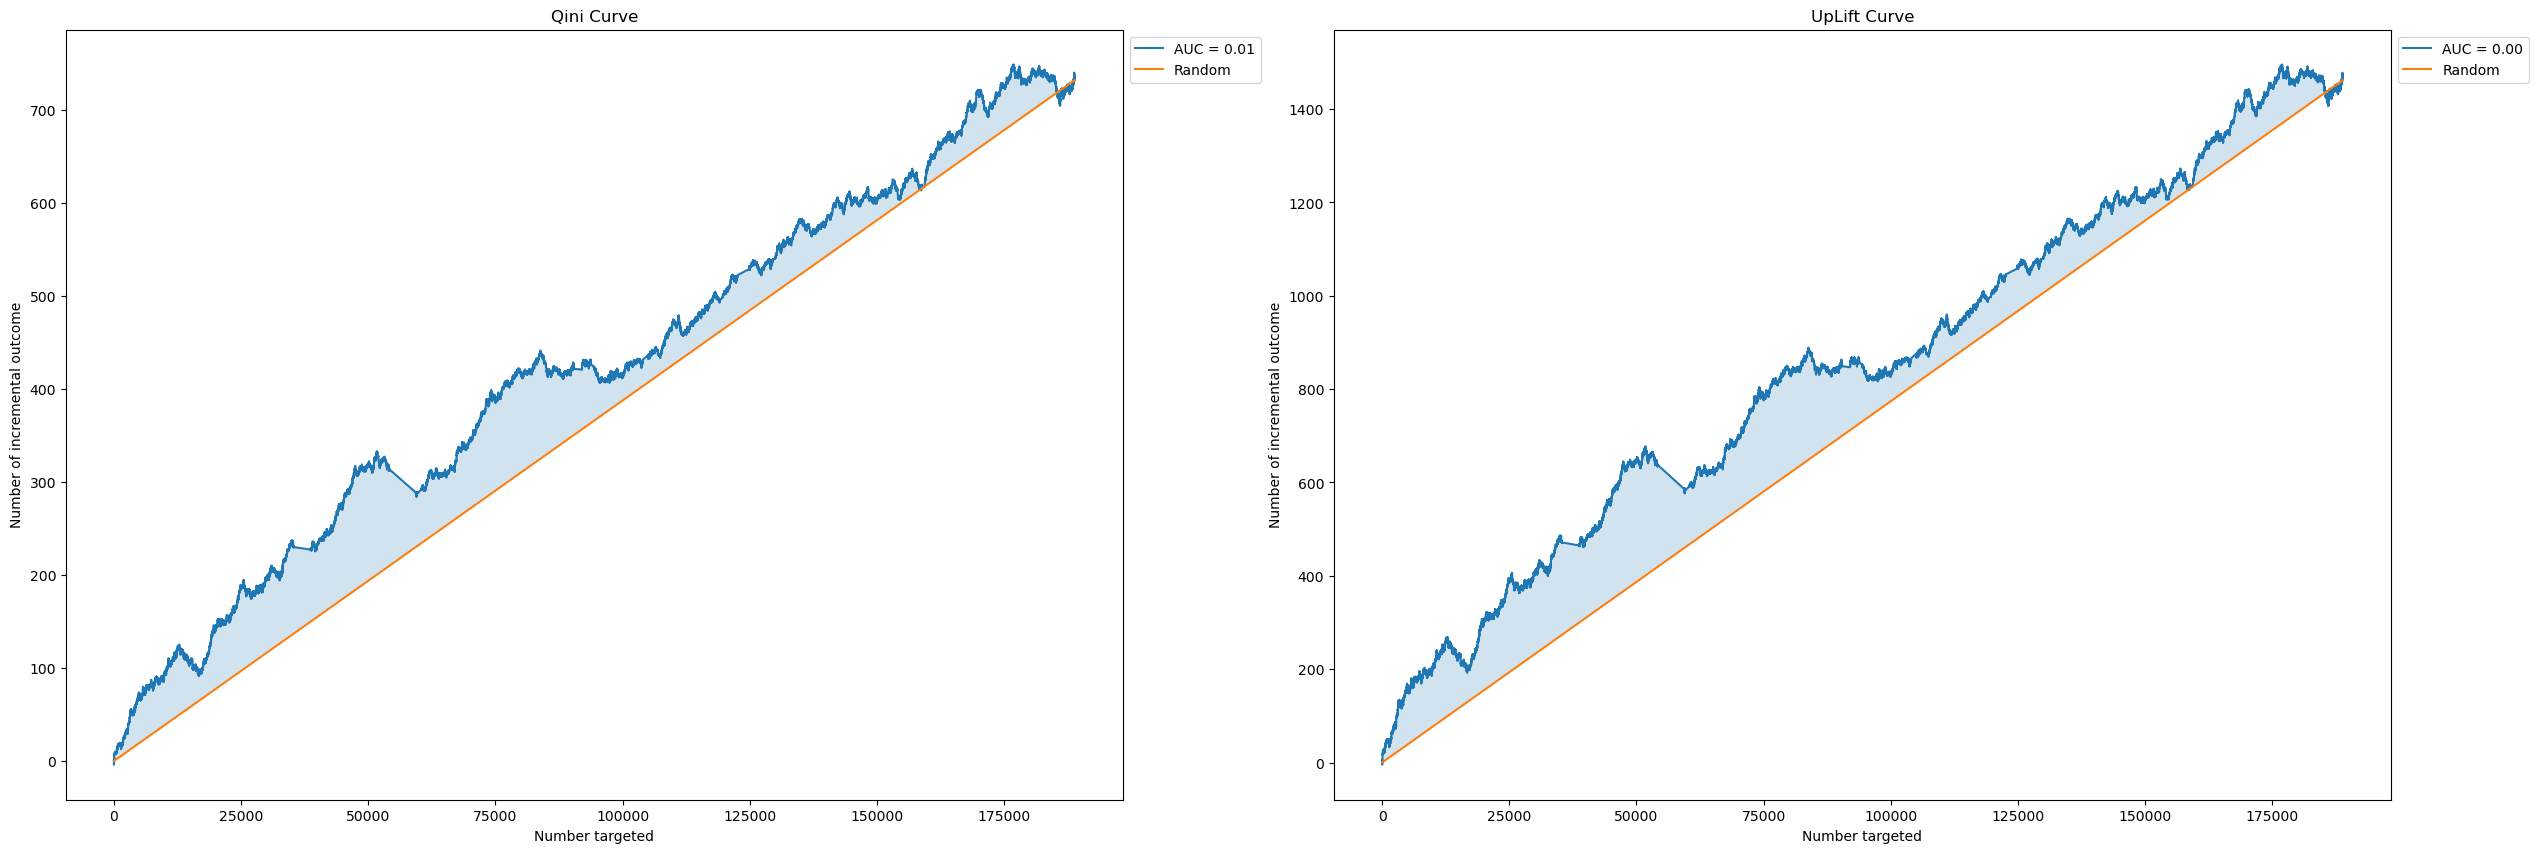

In [27]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_clf = CatBoostClassifier(verbose = 0)
      clf = ClassTransformation(estimator=catboost_clf)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Class model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [28]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0109, grouped - 0.0097.
Qini AUC Score: 0.0055; UpLift AUC Score: 0.0016


In [29]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

40148

# Метод трансформации класса (Регрессия)

In [30]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X)
print(y)
print(p)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[0 0 0 ... 0 0 0]
0.5011176183452472


UpLift at 30%: overall - 0.008709, grouped - 0.009359.
Qini AUC Score: -0.001092; UpLift AUC Score: -0.000356
UpLift at 30%: overall - 0.013688, grouped - 0.014095.
Qini AUC Score: 0.014399; UpLift AUC Score: 0.003541
UpLift at 30%: overall - 0.014561, grouped - 0.01479.
Qini AUC Score: 0.013681; UpLift AUC Score: 0.003395
UpLift at 30%: overall - 0.0133, grouped - 0.014331.
Qini AUC Score: 0.007949; UpLift AUC Score: 0.001893
UpLift at 30%: overall - 0.008938, grouped - 0.009699.
Qini AUC Score: 0.009961; UpLift AUC Score: 0.002432
UpLift at 30%: overall - 0.0118, grouped - 0.0125.
Qini AUC Score: 0.009; UpLift AUC Score: 0.0022


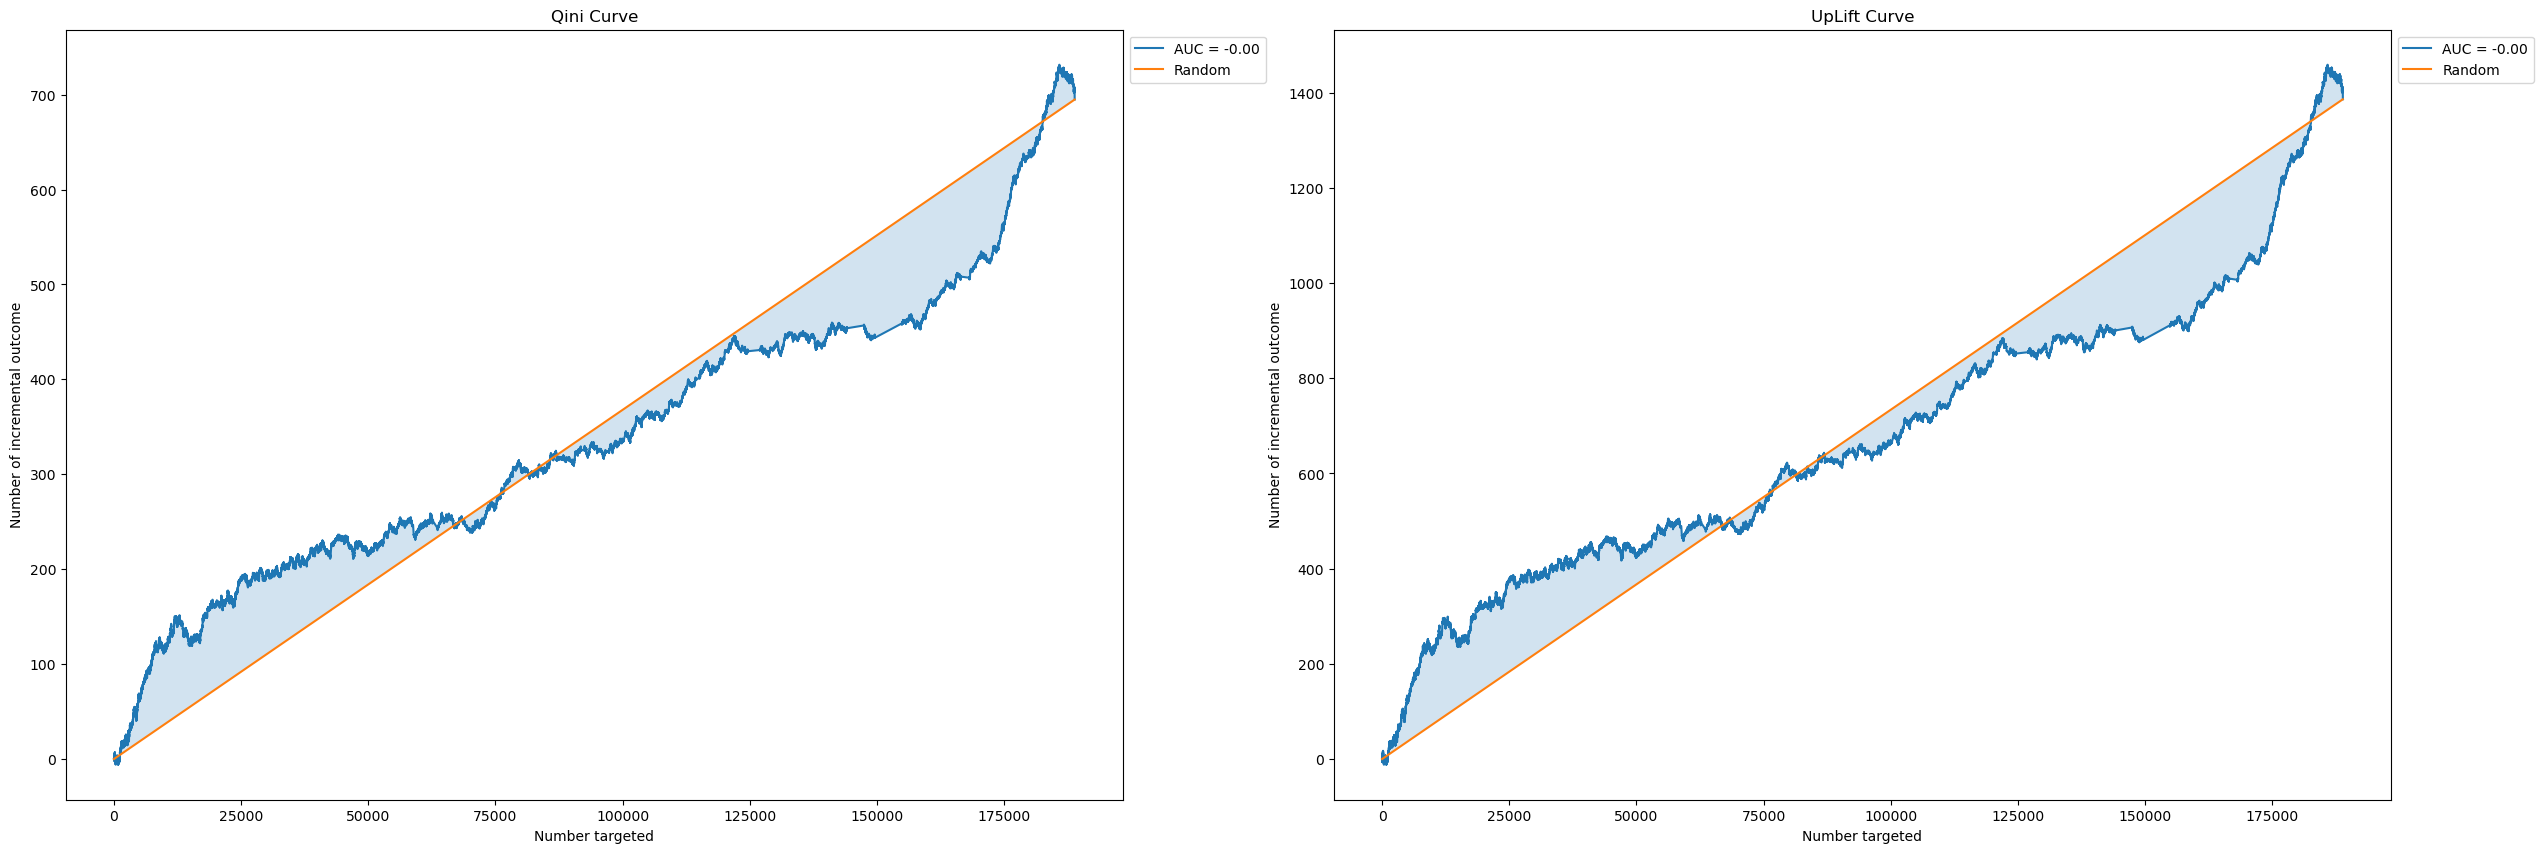

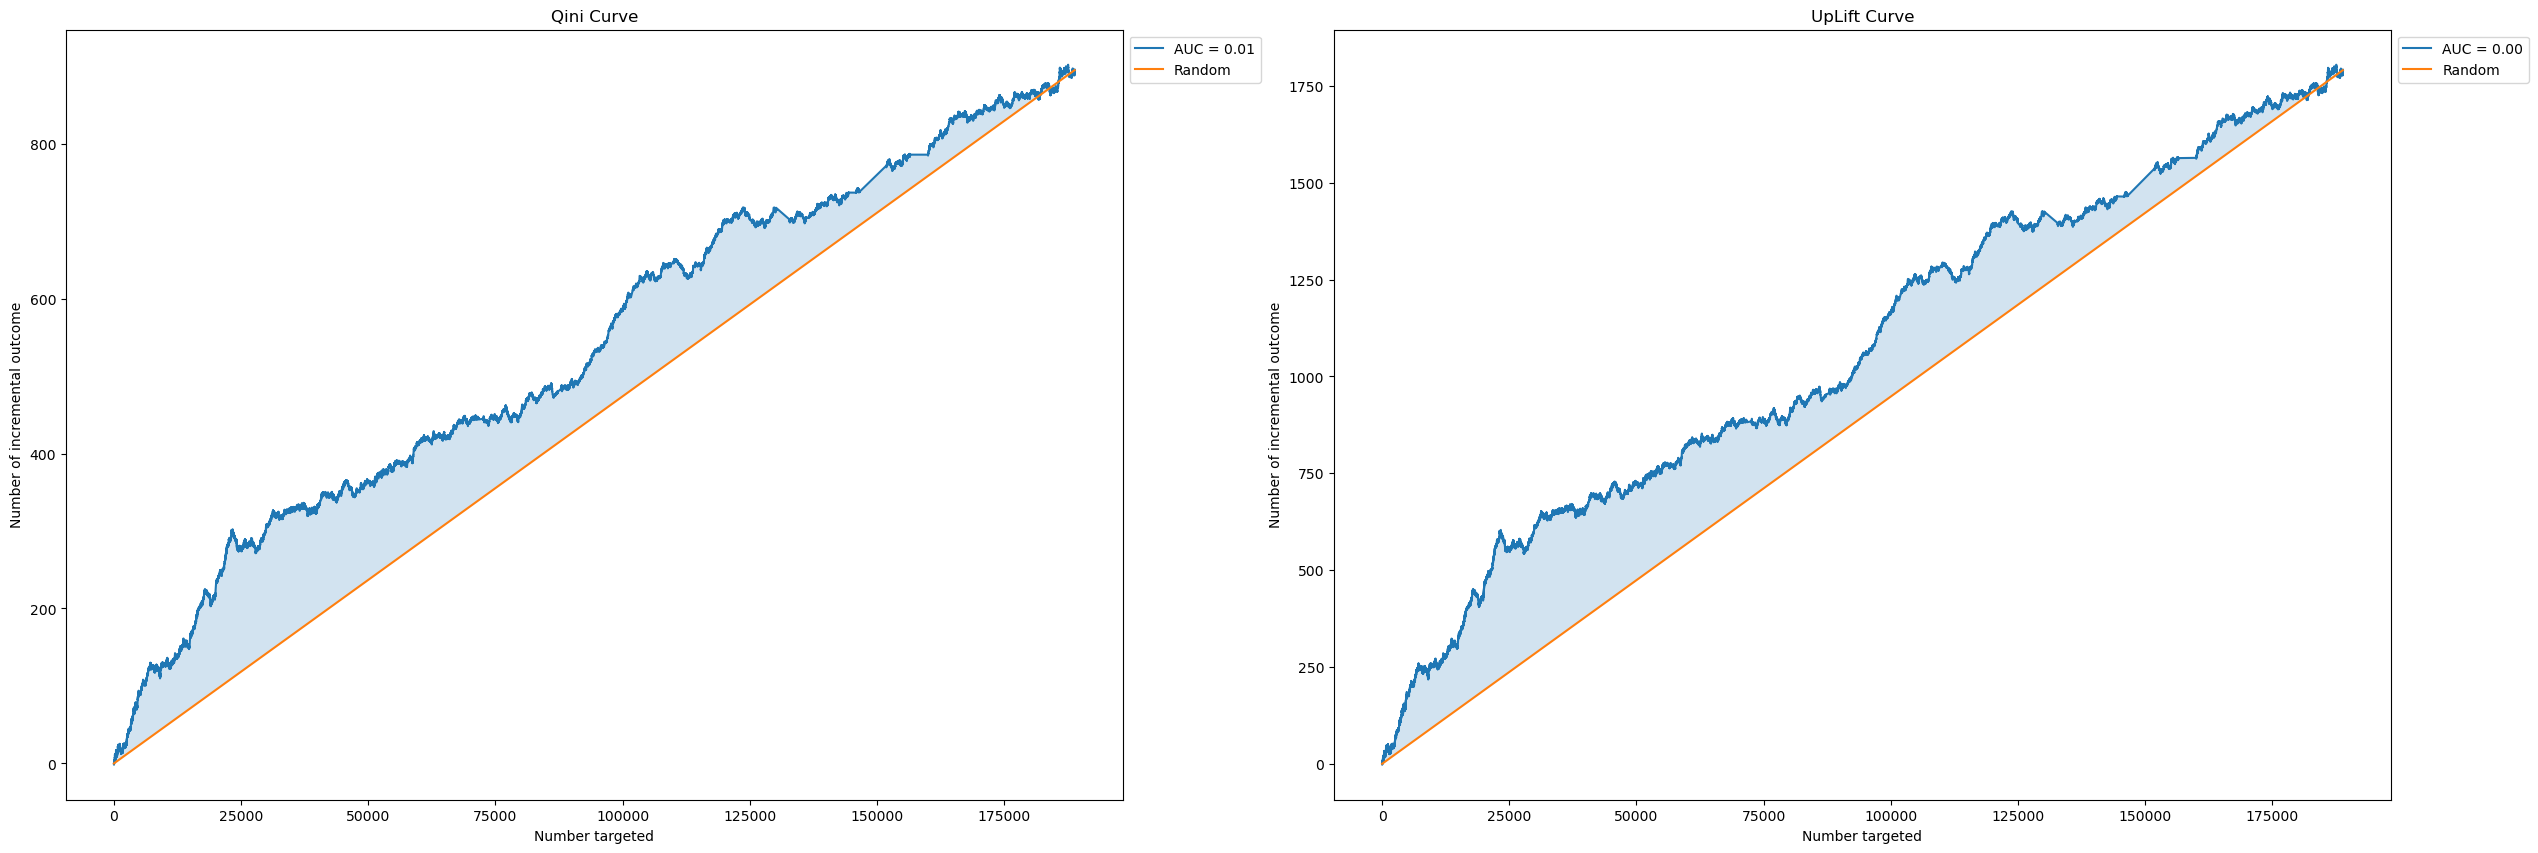

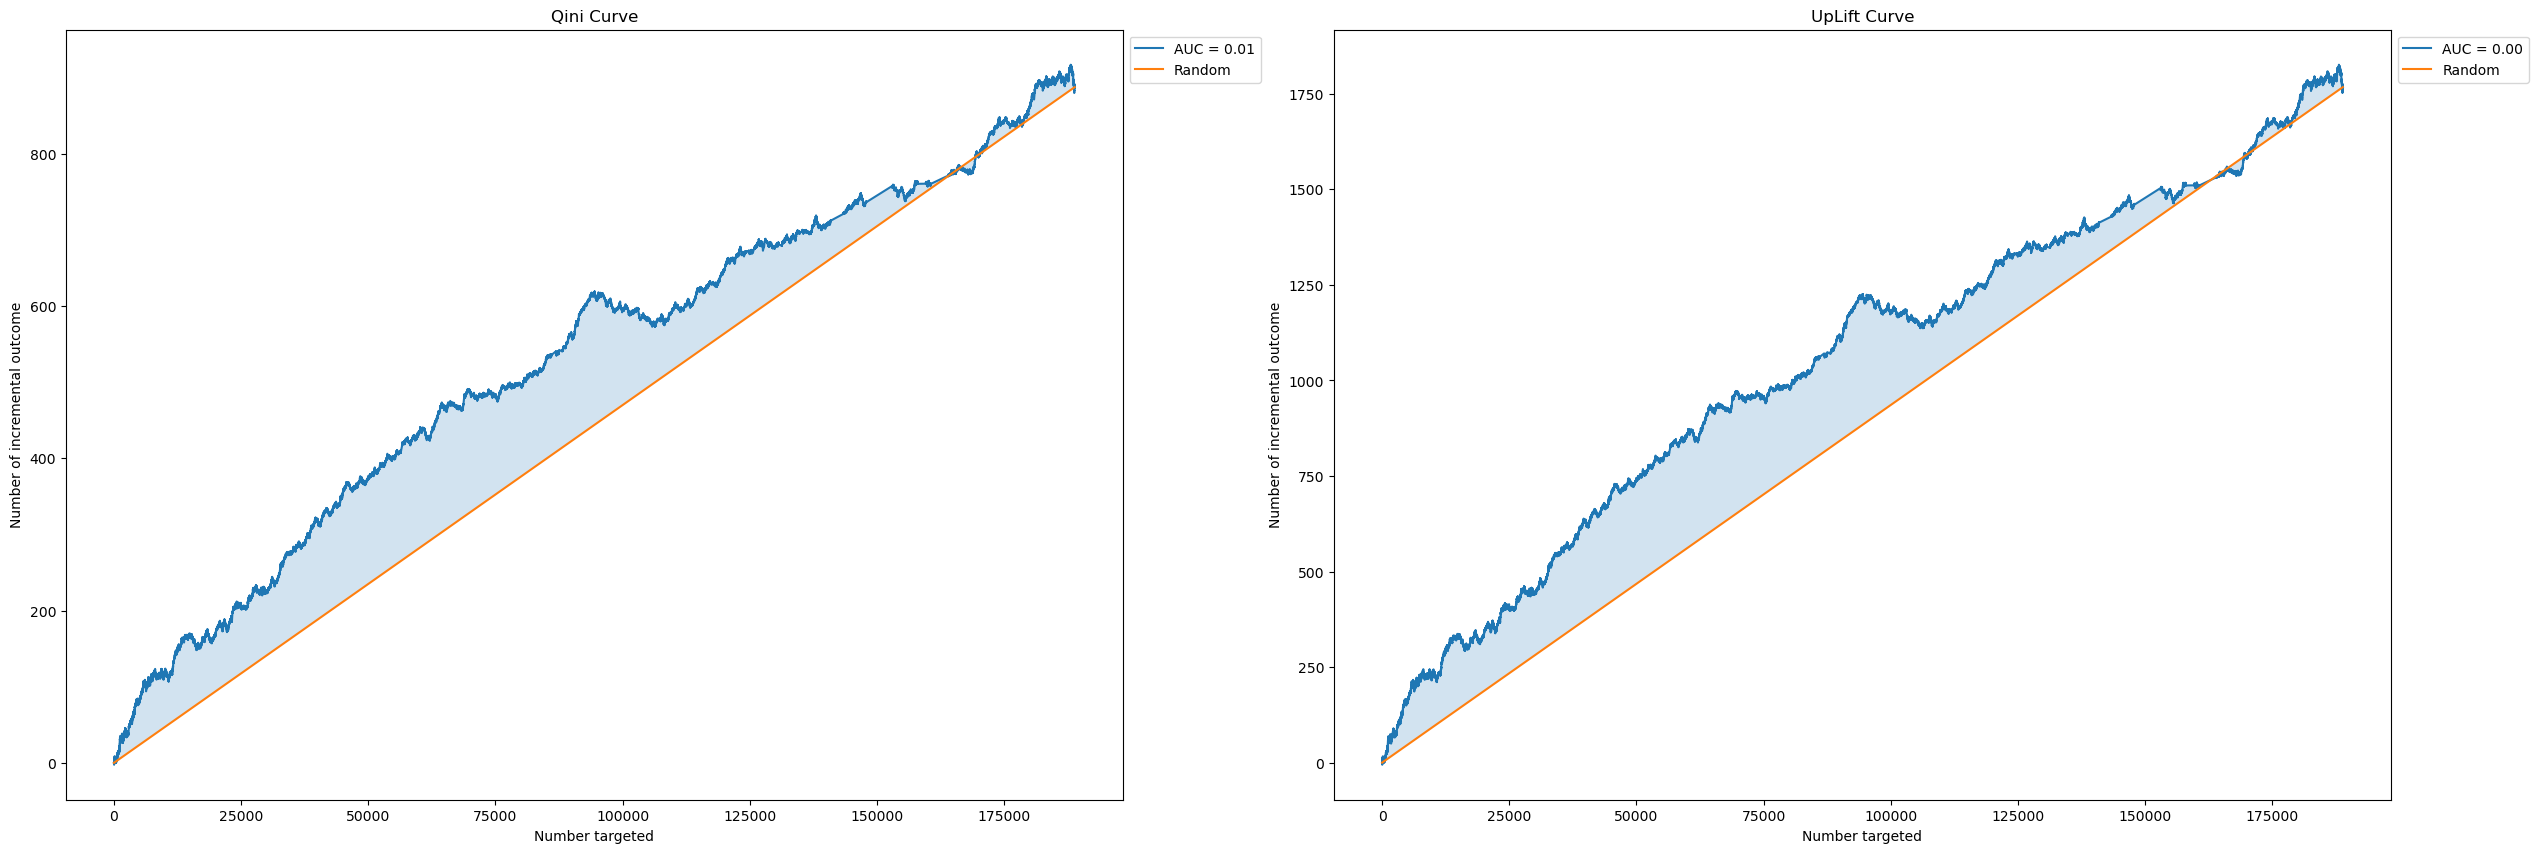

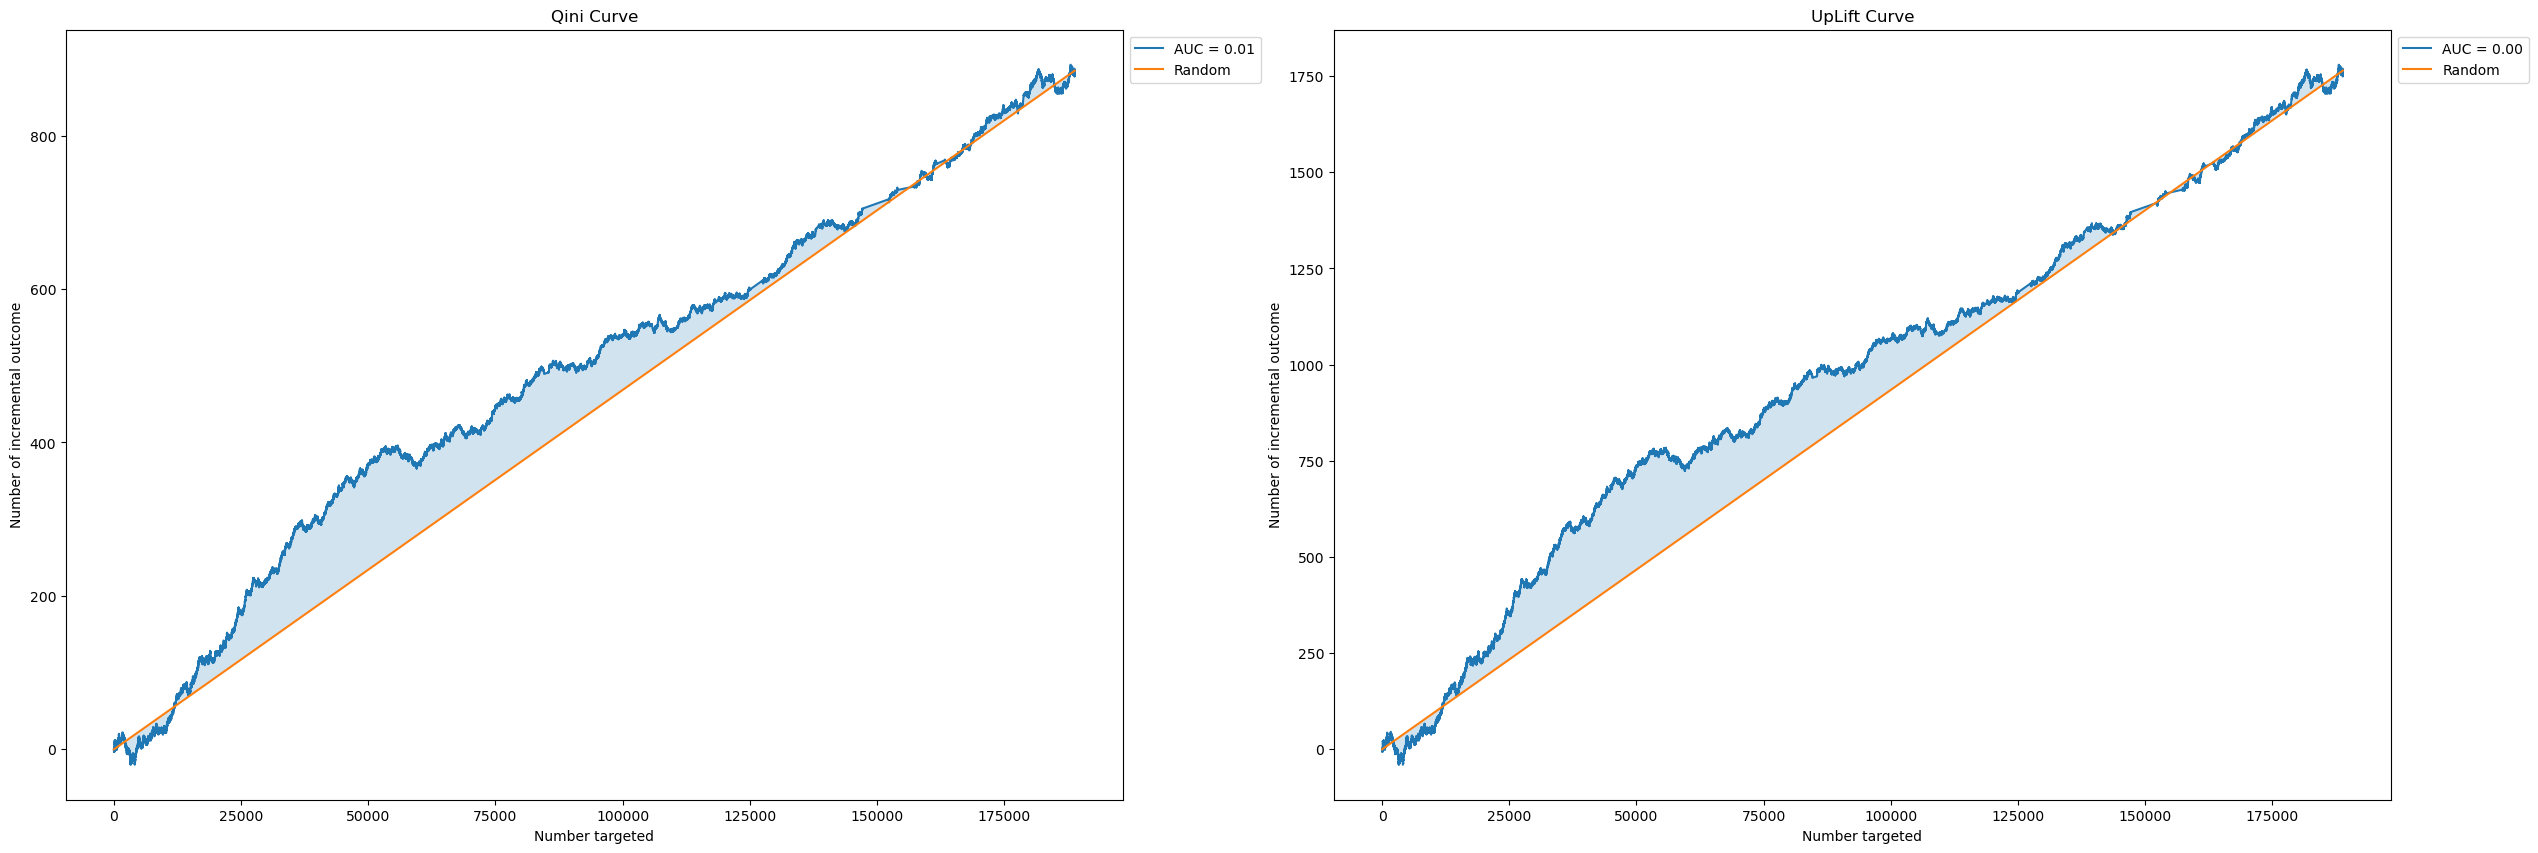

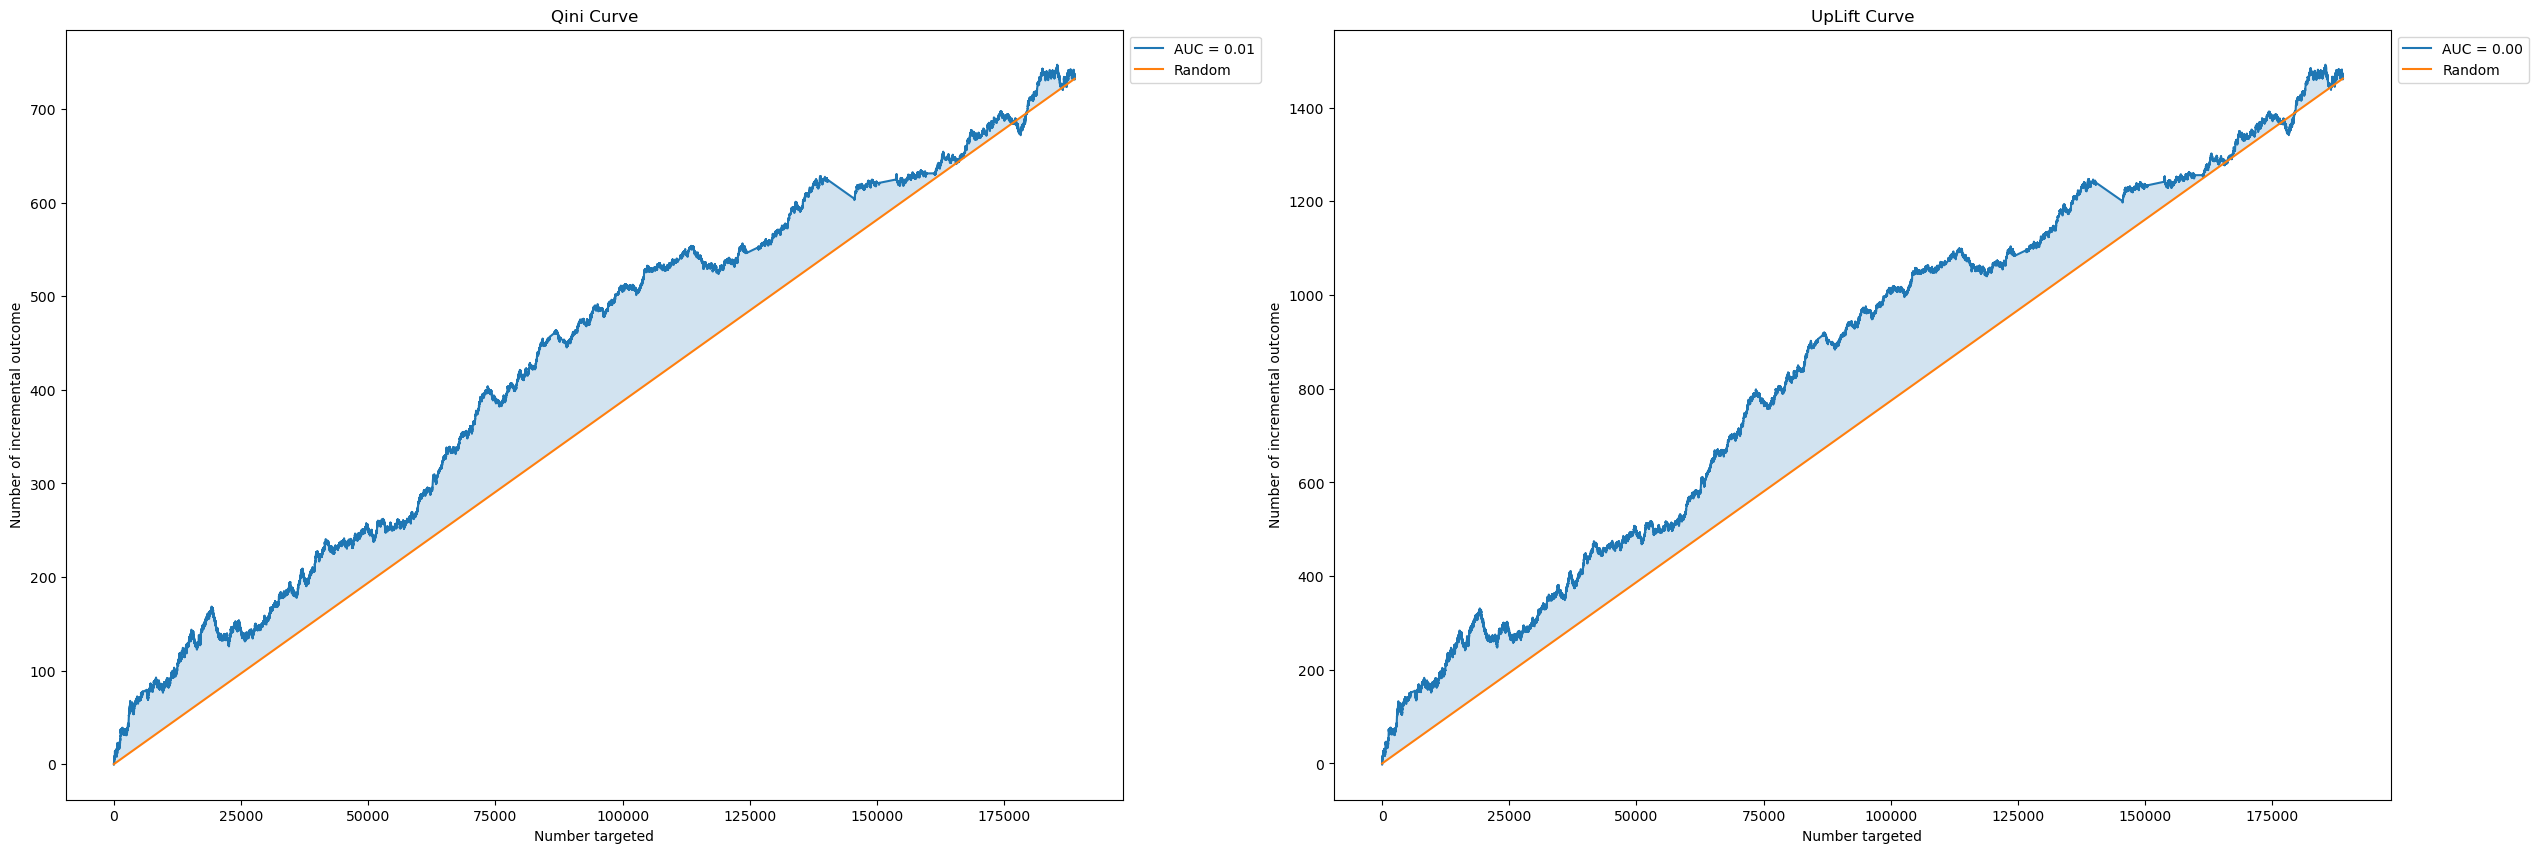

In [31]:
#Default data
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0


for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      catboost_reg = CatBoostRegressor(verbose = 0)
      clf = ClassTransformationReg(estimator=catboost_reg, propensity_val=p)
      clf.fit(X_train_, y_train_, treatment = treat[train_index])
      y_pred = clf.predict(X_test_)
      del clf
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/Trasnform Regression model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [32]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0118, grouped - 0.0125.
Qini AUC Score: 0.009; UpLift AUC Score: 0.0022


In [33]:
del df
del X_data
del Y_data
del treat
del y
gc.collect()

39941

# AutoML Class

## Search PipeLine

In [34]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  \
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788   
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200   
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   

            var_47  var_48  
7727314307     1.0     0.0  
7721696179     1.0     0.0  
7727261180     1.0     0.0  
7725642339     0.0     1.0  
7720389215     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 49)
(944419,)


In [35]:
import evalml
from evalml import AutoMLSearch

In [36]:
from evalml.objectives import get_optimization_objectives
from evalml.problem_types import ProblemTypes

for objective in get_optimization_objectives(ProblemTypes.BINARY):
    print(objective.name)

MCC Binary
Log Loss Binary
Gini
AUC
Precision
F1
Balanced Accuracy Binary
Accuracy Binary


In [37]:
X_train,X_test,y_train,y_test = evalml.preprocessing.utils.split_data(X, y, problem_type="binary")

In [38]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='binary'
                    , patience= 20
                    , verbose = True
                    , tolerance= 1e-12
                    , allow_long_running_models = True
                    , max_batches = 50
                    , objective = 'Gini'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 50
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for Gini. 
Greater score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 50 batches for a total of 50 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mode Baseline Binary Classification Pipeline
Mode Baseline Binary Classification Pipeline:
	Starting cross validation
	Finished cross validation - mean Gini: 0.000

*****************************
* Evaluating Batch Number 1 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.331
Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler:
	Starting cross validation
	Finished cross validation - mean Gini: 0.369

*****************************
* Evaluating Batch Number 2 *
*****************************

Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model:
	Starting cross validation
	Finished cross validation - mean Gini: 0.265
Random

{1: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler': '00:23',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler': '00:12',
  'Total time of batch': '00:35'},
 2: {'Logistic Regression Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Standard Scaler + RF Classifier Select From Model': '00:16',
  'Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + RF Classifier Select From Model': '00:11',
  'Total time of batch': '00:28'},
 3: {'Decision Tree Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:08',
  'LightGBM Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Undersampler + Select Columns Transformer': '00:09',
  'Extra Trees Classifier w/ Label Encoder +

In [39]:
automl.save('automl_big_searching_class.cloudpickle')

## Train Best Pipeline

In [40]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching_class.cloudpickle')


In [41]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [42]:
ranks.to_csv('evalml_class_res.csv', index = False)

In [43]:
ranks.head()

pipeline_name  ranking_score  \
0  LightGBM Classifier w/ Label Encoder + Replace...       0.370528   
1  Random Forest Classifier w/ Label Encoder + Re...       0.368983   
2  XGBoost Classifier w/ Label Encoder + Replace ...       0.367974   
4  Random Forest Classifier w/ Label Encoder + Re...       0.362149   
8           Stacked Ensemble Classification Pipeline       0.358349   

   percent_better_than_baseline  \
0                           inf   
1                           inf   
2                           inf   
4                           inf   
8                           inf   

                                          parameters  
0  {'Label Encoder': {'positive_label': None}, 'I...  
1  {'Label Encoder': {'positive_label': None}, 'I...  
2  {'Label Encoder': {'positive_label': None}, 'I...  
4  {'Label Encoder': {'positive_label': None}, 'I...  
8  {'Label Encoder': {'positive_label': None}, 'L...

In [44]:
ranks.shape

(13, 4)

In [45]:

ranks.head(10).to_excel('class_res.xlsx')

In [46]:
ranks.iloc[0, :].parameters

{'Label Encoder': {'positive_label': None},
 'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Undersampler': {'sampling_ratio': 0.25,
  'min_samples': 100,
  'min_percentage': 0.1,
  'sampling_ratio_dict': None},
 'Select Columns Transformer': {'columns': [14,
   15,
   16,
   17,
   18,
   19,
   20,
   21,
   22,
   23,
   24,
   26,
   29,
   31,
   32,
   33,
   39,
   41,
   42,
   43,
   44,
   45,
   46,
   47,
   48]},
 'LightGBM Classifier': {'boosting_type': 'gbdt',
  'learning_rate': 0.1,
  'n_estimators': 100,
  'max_depth': 0,
  'num_leaves': 31,
  'min_child_samples': 20,
  'n_jobs': -1,
  'bagging_freq': 0,
  'bagging_fraction': 0.9}}

In [47]:
best_clf = automl.best_pipeline
type(best_clf)

evalml.pipelines.binary_classification_pipeline.BinaryClassificationPipeline

In [48]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
proc_data = PrepocessingDataSetLetu()
proc_data.remove_colls(colls_to_drop)
X_data, Y_data = proc_data.preprocessing_data_solomodel(df)
treat = Y_data.treat.values
X = X_data.values
y = Y_data.target.values
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt
print(X.shape)
print(y.shape)






var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  \
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788   
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200   
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000   

            var_47  var_48  
7727314307     1.0     0.0  
7721696179     1.0     0.0  
7727261180     1.0     0.0  
7725642339     0.0     1.0  
7720389215     0.0     1.0

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

(944419, 49)
(944419,)


UpLift at 30%: overall - 0.020084, grouped - 0.020498.
Qini AUC Score: 0.04635; UpLift AUC Score: 0.011725
UpLift at 30%: overall - 0.023322, grouped - 0.023817.
Qini AUC Score: 0.047631; UpLift AUC Score: 0.011864
UpLift at 30%: overall - 0.022455, grouped - 0.02321.
Qini AUC Score: 0.048764; UpLift AUC Score: 0.012275
UpLift at 30%: overall - 0.022465, grouped - 0.022985.
Qini AUC Score: 0.048422; UpLift AUC Score: 0.012124
UpLift at 30%: overall - 0.016288, grouped - 0.017175.
Qini AUC Score: 0.0364; UpLift AUC Score: 0.009228
UpLift at 30%: overall - 0.0209, grouped - 0.0215.
Qini AUC Score: 0.0455; UpLift AUC Score: 0.0114


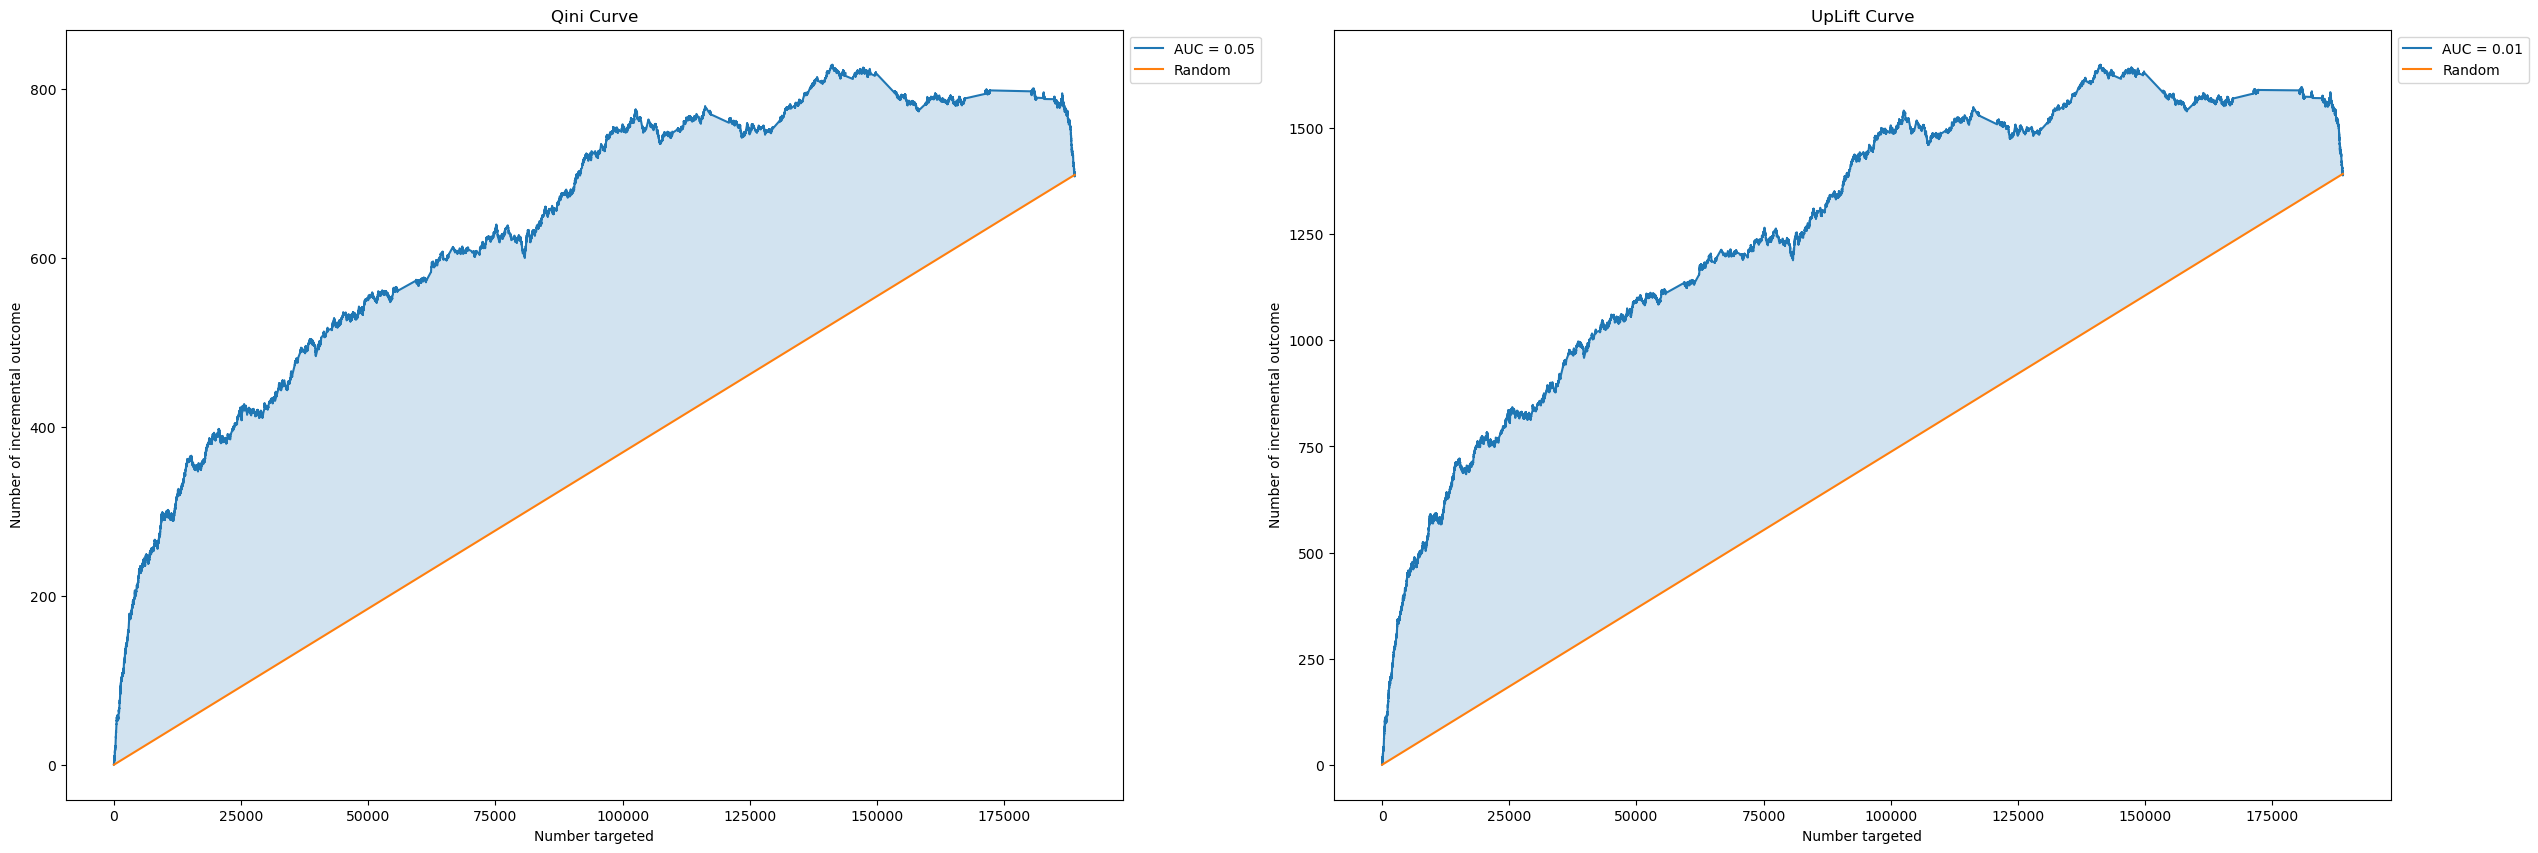

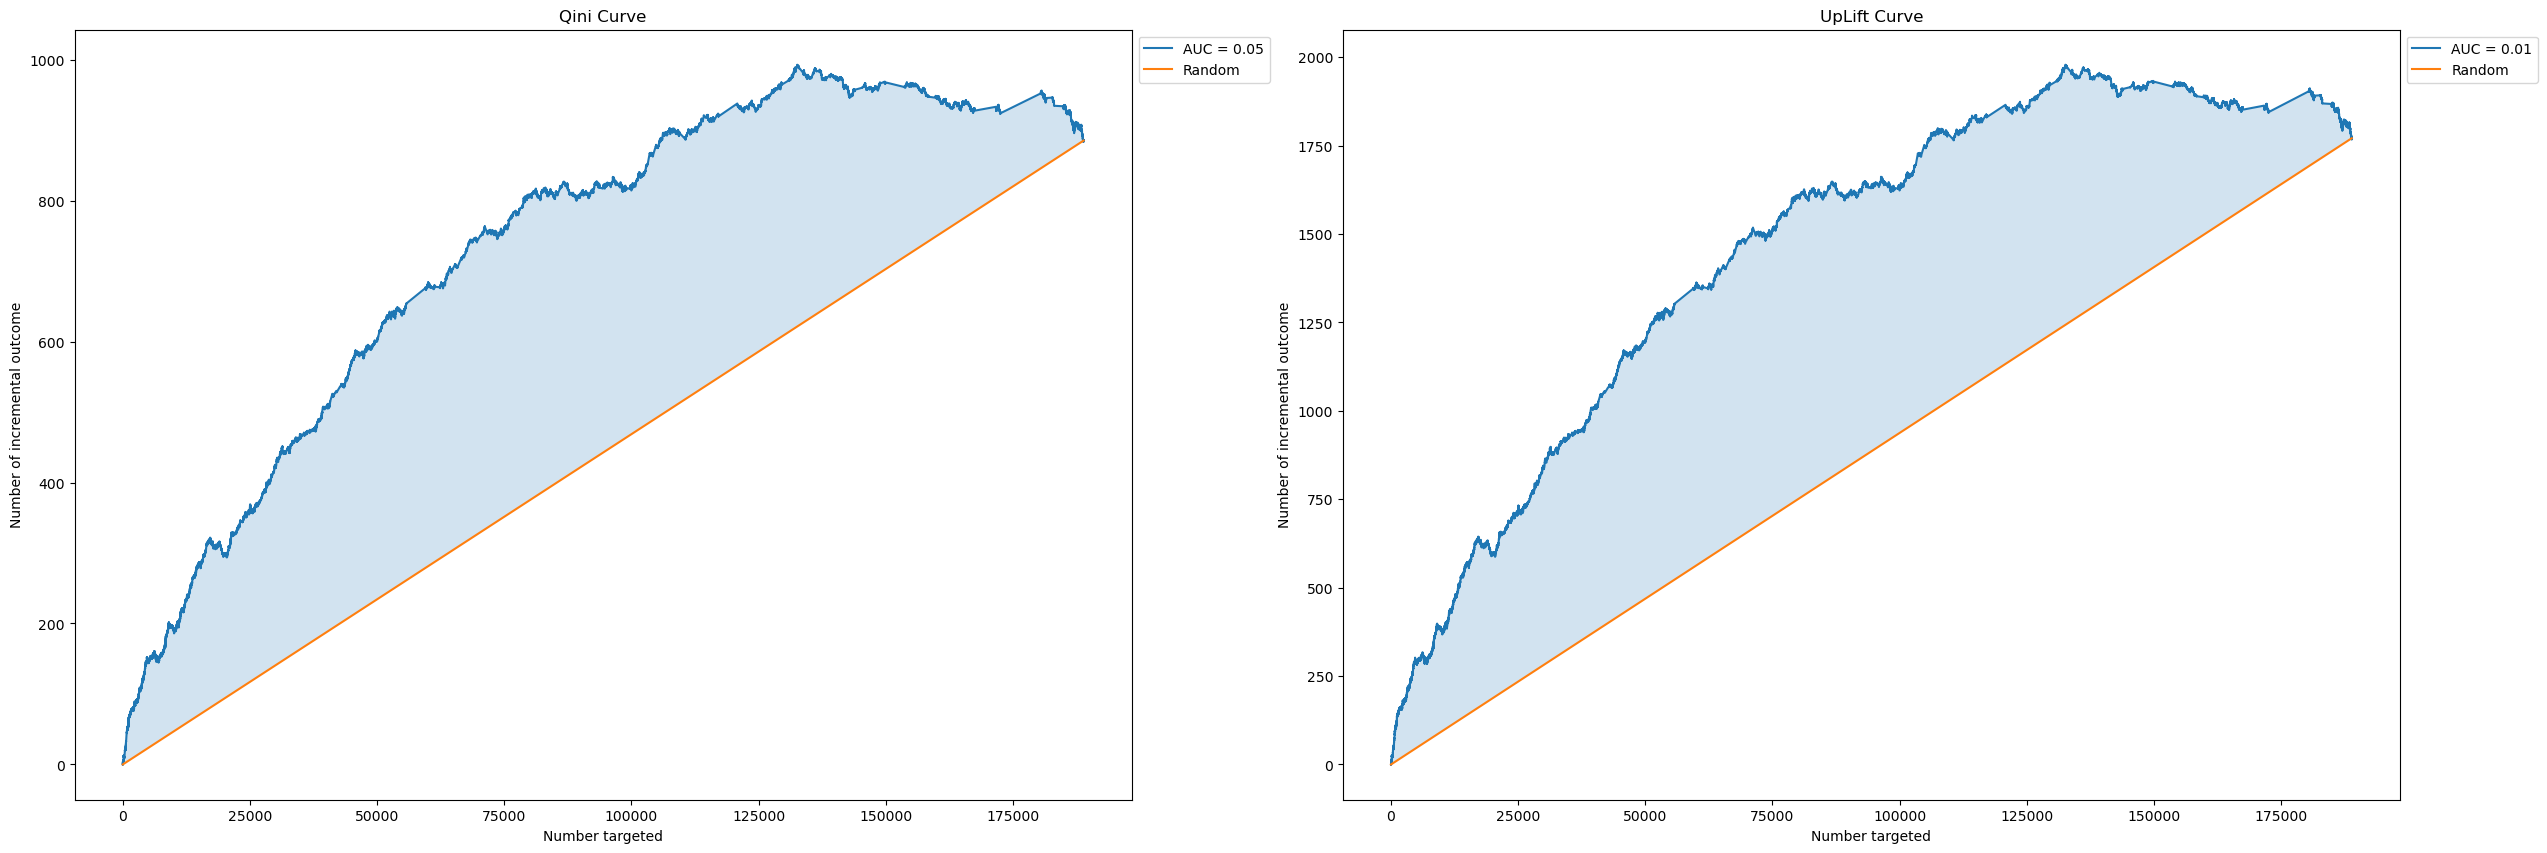

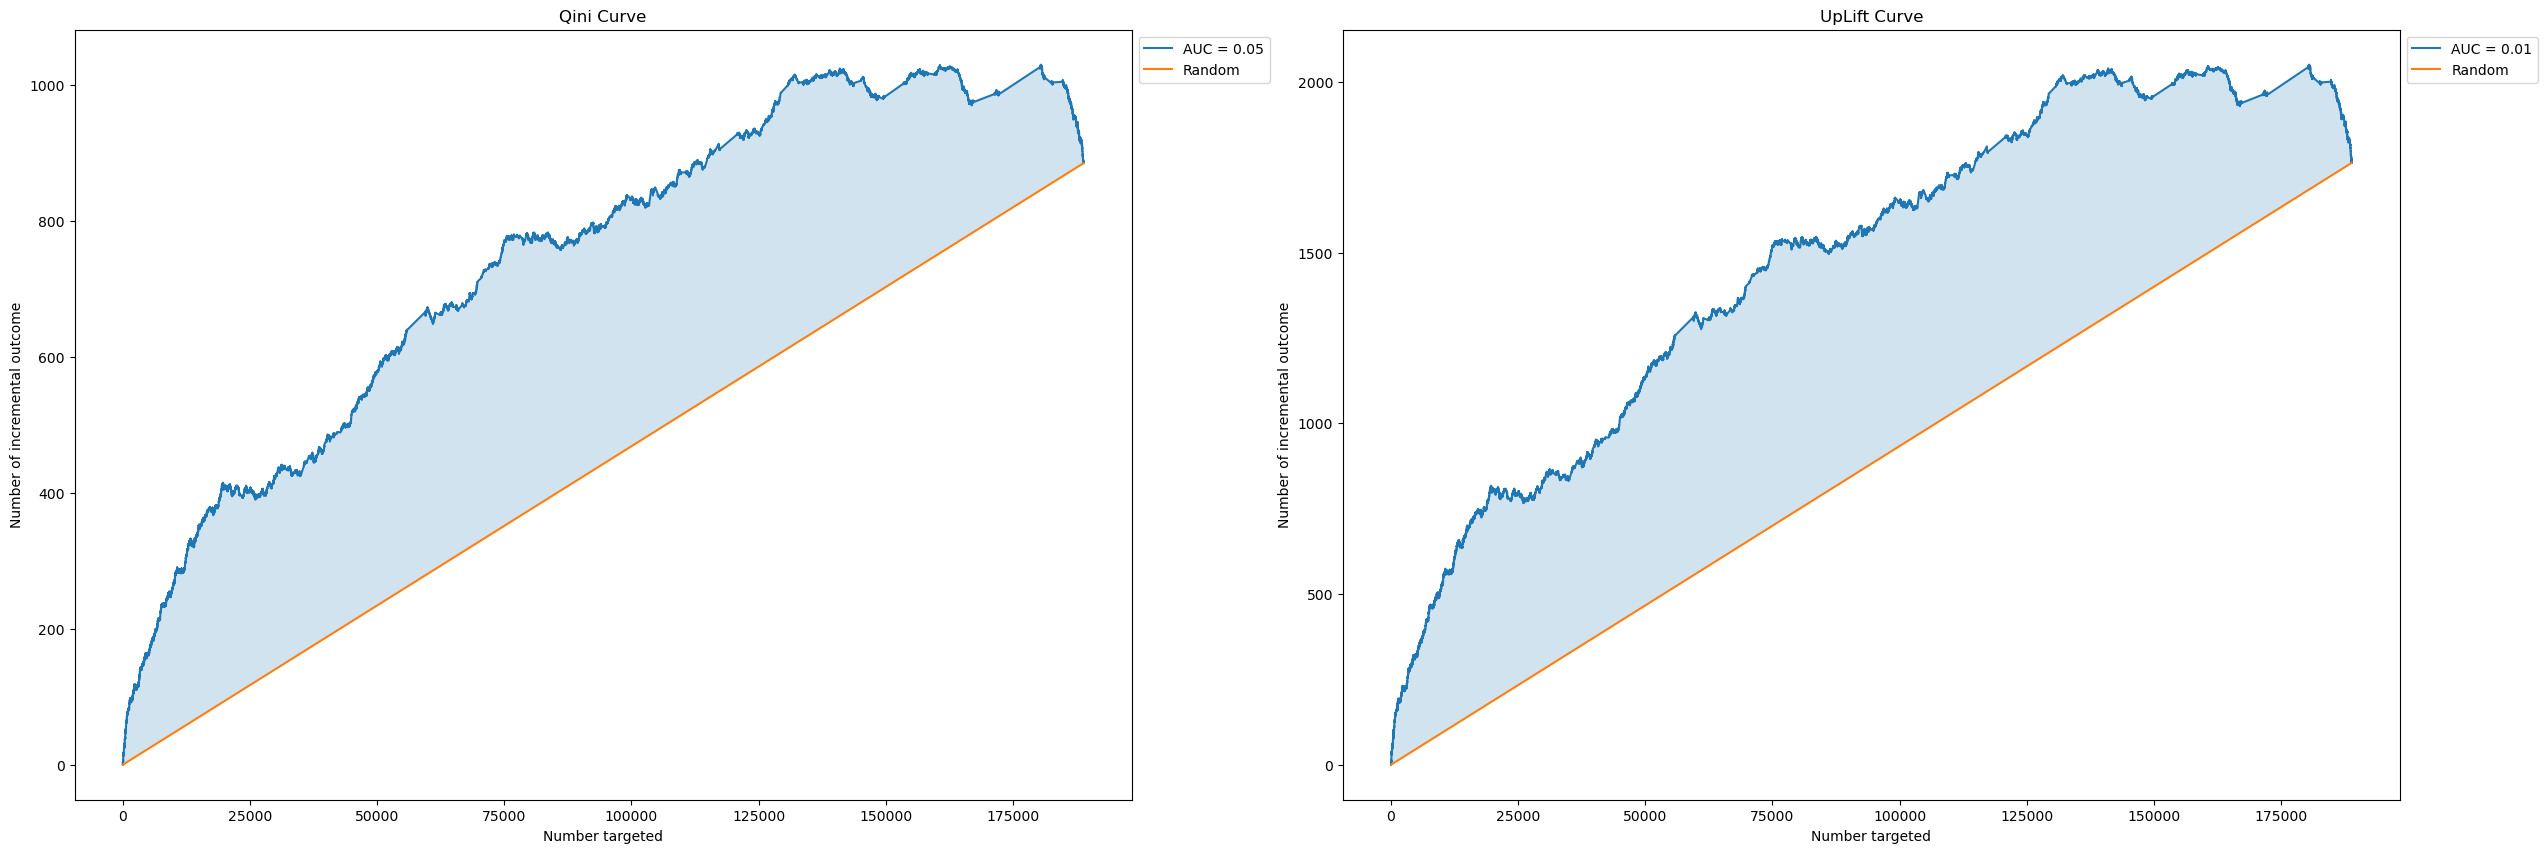

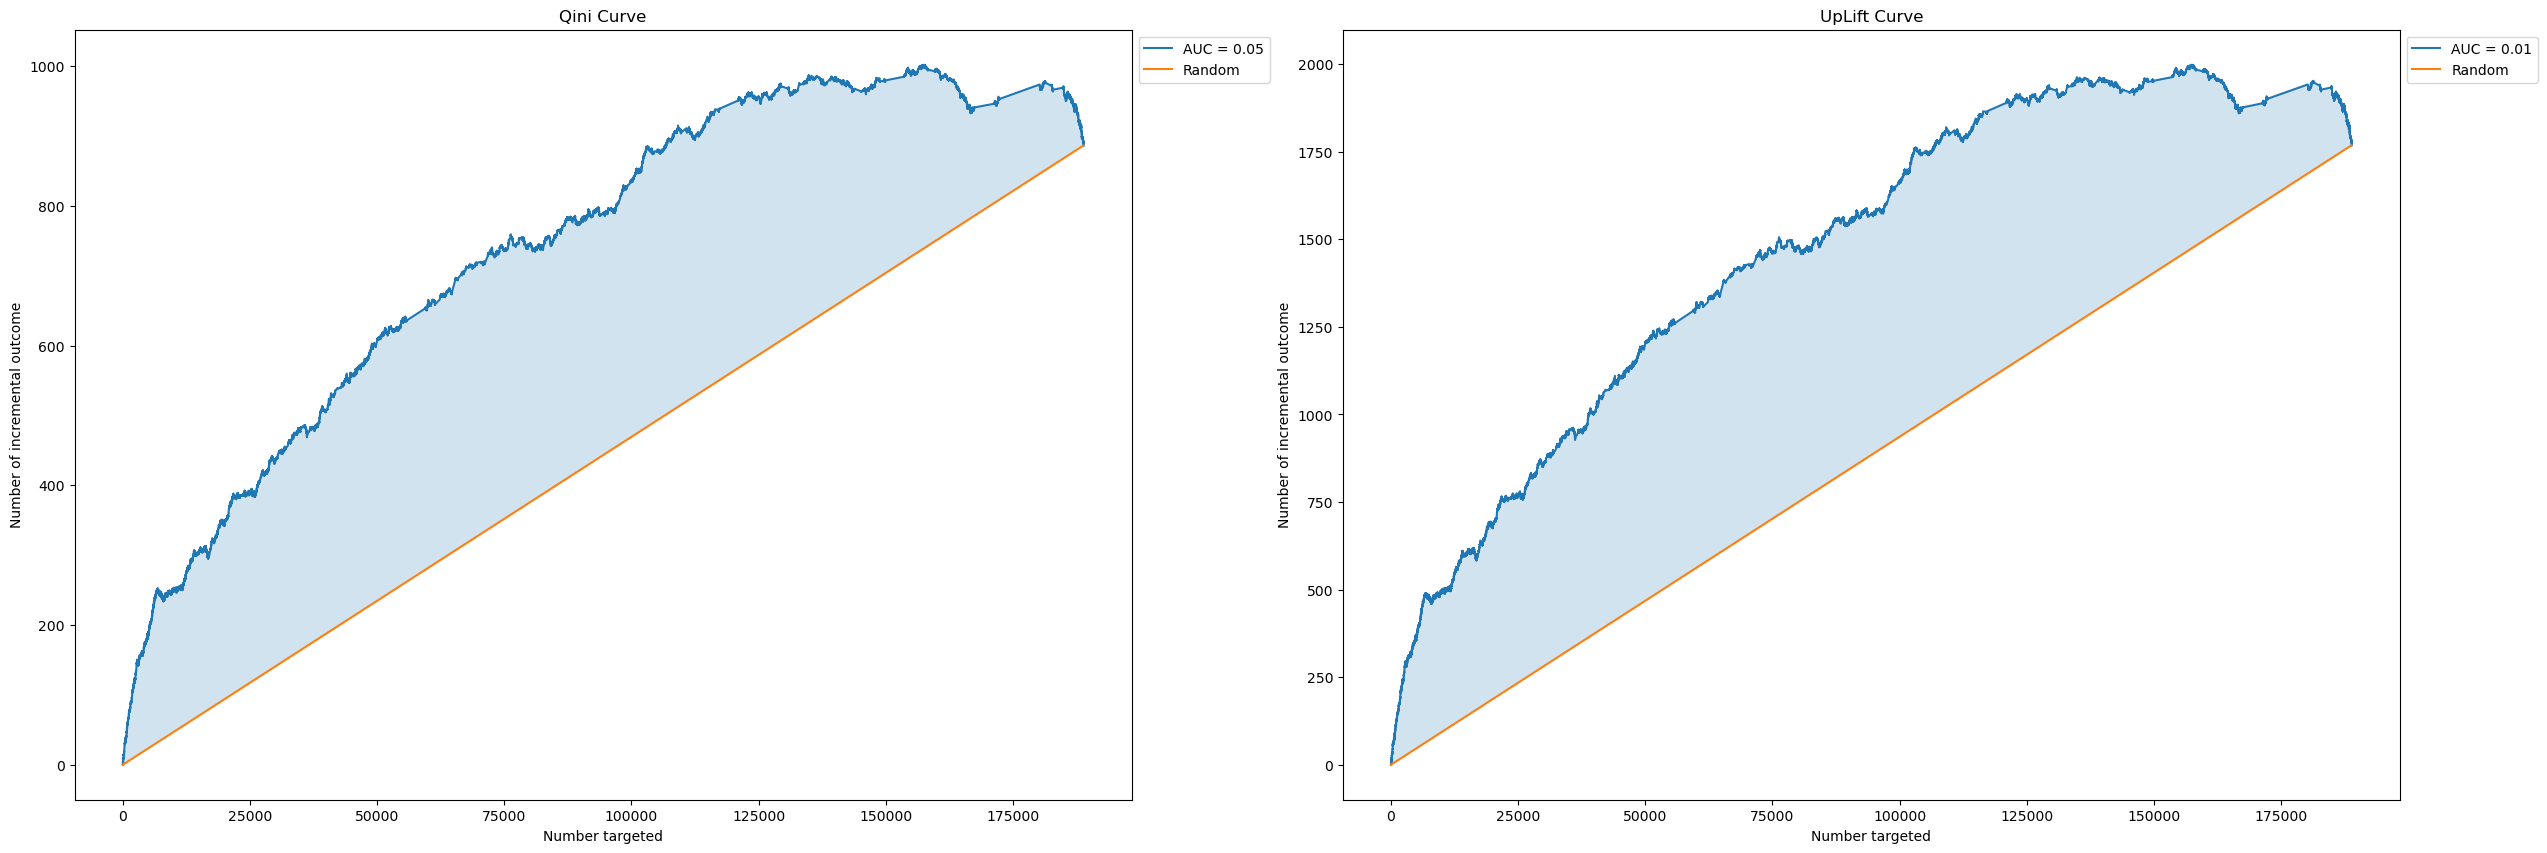

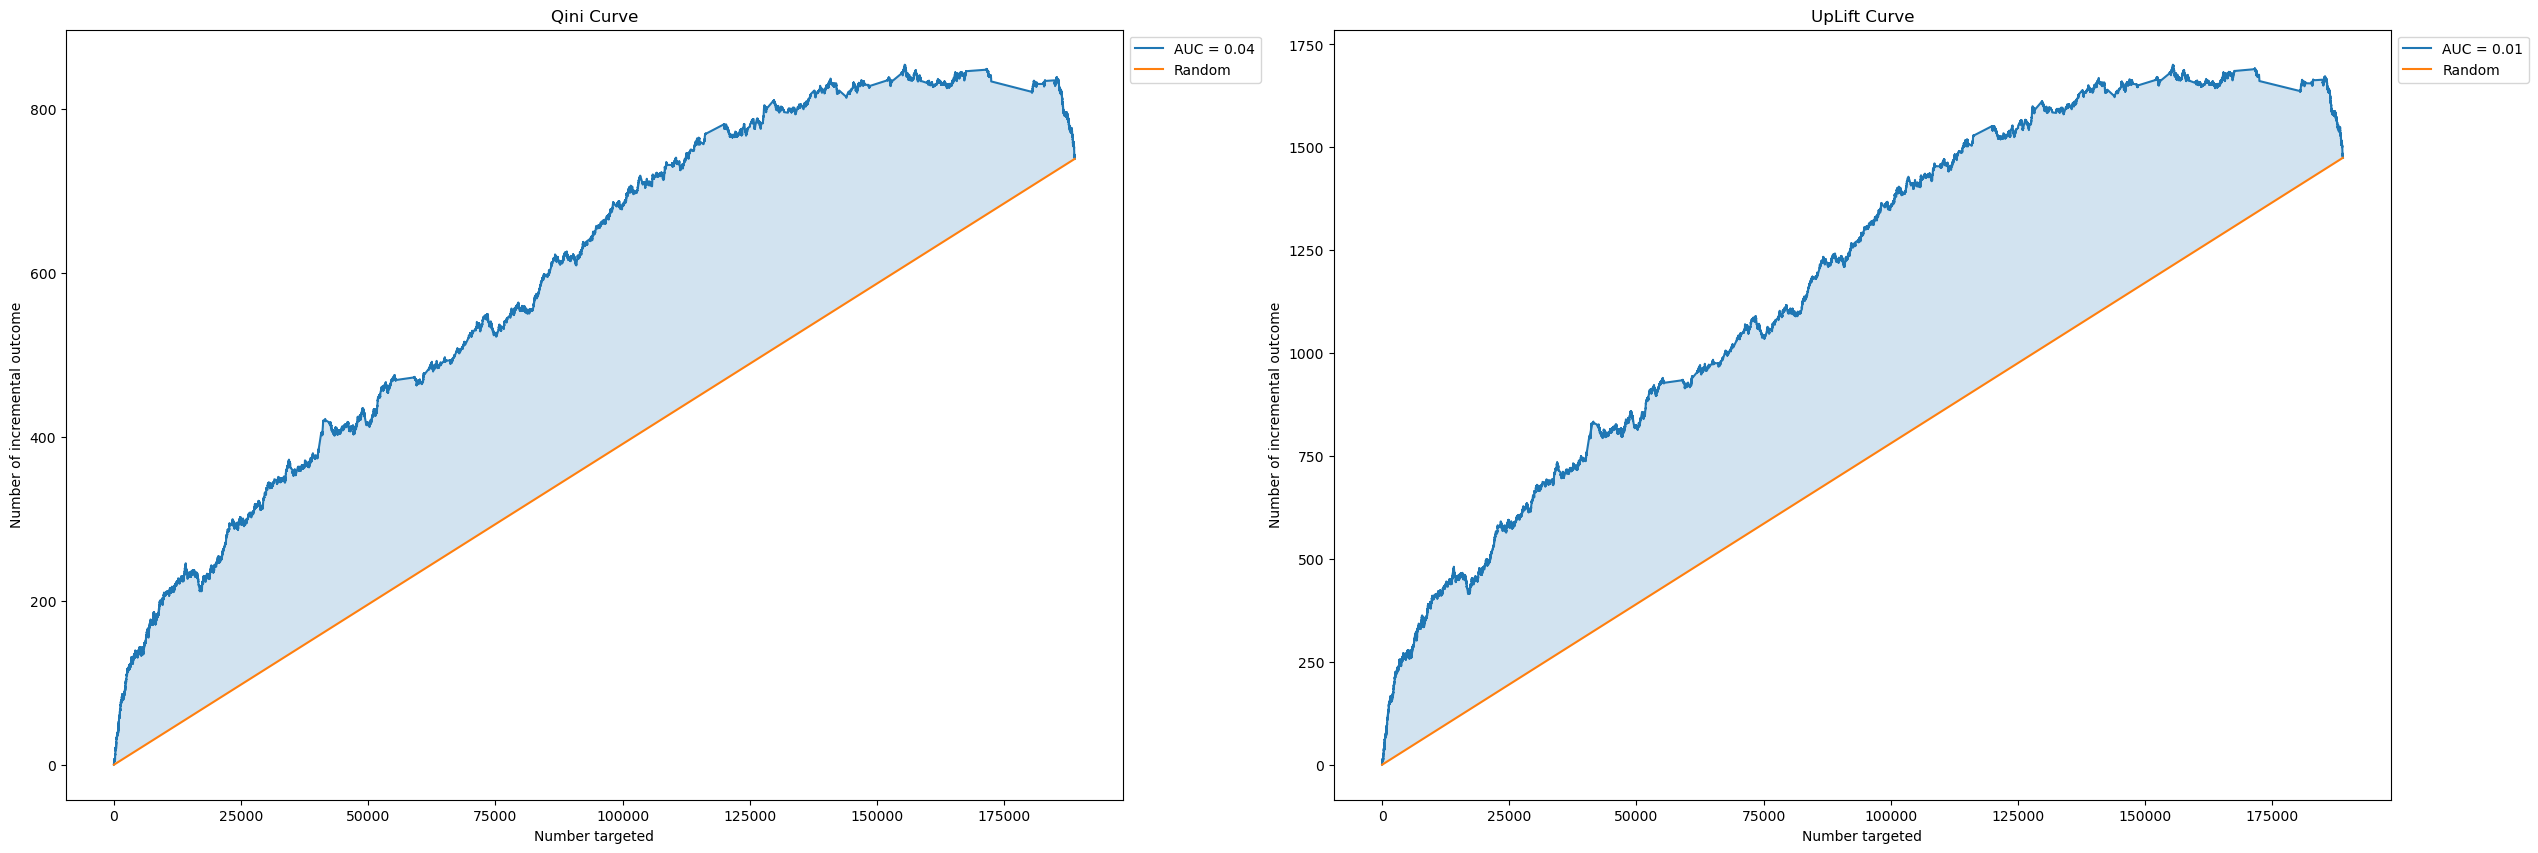

In [49]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      best_clf  = copy.deepcopy(automl.best_pipeline)
      best_clf.fit(X_train_, y_train_)
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.zeros(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred0 = best_clf.predict_proba(X_test_)[[1]]
      X_test_[:, -2:] = proc_data.ohe_solomodel.transform(np.ones(shape = treat[test_index].shape).reshape(-1, 1)).toarray()
      y_pred1 = best_clf.predict_proba(X_test_)[[1]]
      y_pred = np.squeeze(y_pred1 - y_pred0).tolist()
      del X_train_
      del y_train_
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(y_test_, treat[test_index], y_pred, f"Plots/CLassification EvalML model Procentile Split Overall {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics[ 'qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [50]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0209, grouped - 0.0215.
Qini AUC Score: 0.0455; UpLift AUC Score: 0.0114


# AutoML Reg

## Search PipeLine

In [51]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte']  + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values.astype(float)
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


In [52]:
import evalml
from evalml import AutoMLSearch

In [53]:
# from evalml.objectives import get_optimization_objectives
# from evalml.problem_types import ProblemTypes

# for objective in get_optimization_objectives(ProblemTypes.REGRESSION):
#     print(objective.name)

In [54]:
X_train,X_test,y_train,y_test= evalml.preprocessing.utils.split_data(X, y, problem_type="regression")

In [55]:
automl=AutoMLSearch(X_train = X_train
                    , y_train = y_train
                    , n_jobs = -1
                    , problem_type='regression'
                    , patience= 20
                    , verbose = True
                    , allow_long_running_models = True
                    , max_batches = 20
                    , objective = 'MSE'
                    , optimize_thresholds=True
                    , train_best_pipeline= True
                    , ensembling=True
                    , max_iterations = 20
                    , holdout_set_size= 0
                    #, allowed_model_families = evalml.pipelines.components.utils.allowed_model_families('binary')
                    )


automl.search()

AutoMLSearch will use mean CV score to rank pipelines.

*****************************
* Beginning pipeline search *
*****************************

Optimizing for MSE. 
Lower score is better.

Using SequentialEngine to train and score pipelines.
Searching up to 20 batches for a total of 20 pipelines. 
Allowed model families: 



FigureWidget({
    'data': [{'mode': 'lines+markers',
              'name': 'Best Score',
              'type'…

Evaluating Baseline Pipeline: Mean Baseline Regression Pipeline
Mean Baseline Regression Pipeline:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 1 *
*****************************



c:\Users\Kirill\.conda\envs\automl\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.222e+03, tolerance: 5.104e+00



Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 2 *
*****************************

Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271
Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model:
	Starting cross validation
	Finished cross validation - mean MSE: 0.271

*****************************
* Evaluating Batch Number 3 *
*****************************

Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer:
	Starting cross validation
	Finished

{1: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler': '00:17',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer': '00:47',
  'Total time of batch': '01:05'},
 2: {'Elastic Net Regressor w/ Replace Nullable Types Transformer + Imputer + Standard Scaler + RF Regressor Select From Model': '00:41',
  'Random Forest Regressor w/ Replace Nullable Types Transformer + Imputer + RF Regressor Select From Model': '00:55',
  'Total time of batch': '01:37'},
 3: {'Decision Tree Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:08',
  'Extra Trees Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:22',
  'XGBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:18',
  'CatBoost Regressor w/ Replace Nullable Types Transformer + Imputer + Select Columns Transformer': '00:09',
  'LightGBM Regressor w/ Replace

In [56]:
automl.save('automl_big_searching.cloudpickle')

## Train Best Pipeline

In [57]:
import evalml
from evalml import AutoMLSearch
automl = AutoMLSearch.load('automl_big_searching.cloudpickle')


In [58]:
ranks = automl.rankings
ranks = ranks.drop(['id', 'search_order'	,'mean_cv_score'	,'standard_deviation_cv_score', 'high_variance_cv'], axis = 1)

In [59]:
ranks.to_csv('evalml_res.csv', index = False)

In [60]:
ranks.head()

pipeline_name  ranking_score  \
0  CatBoost Regressor w/ Replace Nullable Types T...       0.270923   
1                  Mean Baseline Regression Pipeline       0.270931   
2  Elastic Net Regressor w/ Replace Nullable Type...       0.270931   
5  Elastic Net Regressor w/ Replace Nullable Type...       0.270933   
6  Random Forest Regressor w/ Replace Nullable Ty...       0.270956   

   percent_better_than_baseline  \
0                      0.002916   
1                      0.000000   
2                      0.000000   
5                     -0.000715   
6                     -0.009150   

                                          parameters  
0  {'Imputer': {'categorical_impute_strategy': 'm...  
1       {'Baseline Regressor': {'strategy': 'mean'}}  
2  {'Imputer': {'categorical_impute_strategy': 'm...  
5  {'Imputer': {'categorical_impute_strategy': 'm...  
6  {'Imputer': {'categorical_impute_strategy': 'm...

In [61]:
ranks.shape

(13, 4)

In [62]:

ranks.head(10).to_excel('res.xlsx')

In [63]:
ranks.iloc[0, :].parameters

{'Imputer': {'categorical_impute_strategy': 'most_frequent',
  'numeric_impute_strategy': 'mean',
  'boolean_impute_strategy': 'most_frequent',
  'categorical_fill_value': None,
  'numeric_fill_value': None,
  'boolean_fill_value': None},
 'Select Columns Transformer': {'columns': [3,
   5,
   14,
   15,
   16,
   18,
   19,
   21,
   22,
   23,
   24,
   26,
   29,
   31,
   32,
   33,
   36,
   39,
   41,
   42,
   43,
   44,
   45,
   46]},
 'CatBoost Regressor': {'n_estimators': 10,
  'eta': 0.03,
  'max_depth': 6,
  'bootstrap_type': None,
  'silent': False,
  'allow_writing_files': False,
  'n_jobs': -1}}

In [64]:
ctbst  = automl.best_pipeline
type(ctbst)

evalml.pipelines.regression_pipeline.RegressionPipeline

In [65]:
df= pd.read_csv(r'uplift_dataset.zip'
                    , sep = ';'
                    , encoding = 'ANSI'
                    , dtype = {'NPL':str
                            , 'SEGMENT_N':str}, index_col=['NPL']).drop(['FEDERAL_DATE', 'Group', 'Send_DAte'] + colls_to_drop, axis = 1)#.set_index('NPL')
df.index.name = None
X_data, Y_data = proc_data.preprocessing_data(df)
display(X_data.head()) 
display(Y_data.head()) 
gc.collect()
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt

treat = Y_data.treat.values
targ = Y_data.target.values

p = Y_data[Y_data.treat == 1].shape[0] / Y_data.shape[0]
X = X_data.values
#X = (X - X.mean()) / X.std()
y = Y_data.target * (Y_data.treat - p) / (1- p) / p
y = y.values
features = X_data.columns.tolist()
gc.collect()
print(X)
print(y)
print(p)
from sklift.metrics import (
    uplift_at_k, uplift_auc_score, qini_auc_score, weighted_average_uplift
)

from sklift.viz import plot_qini_curve, plot_uplift_curve, plot_uplift_by_percentile
import matplotlib.pyplot as plt


var_0  var_1  var_2  var_3  var_4  var_5  var_6  var_7  var_8  \
7727314307    1.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   
7721696179    1.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
7727261180    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   
7725642339    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   
7720389215    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0   

            var_9  var_10  var_11  var_12  var_13  var_14    var_15    var_16  \
7727314307    0.0     0.0     1.0     0.0     1.0    0.36  0.375158  0.061079   
7721696179    0.0     1.0     0.0     1.0     0.0    0.51 -1.139324 -0.596416   
7727261180    0.0     1.0     0.0     0.0     1.0    0.32 -0.897007 -0.596416   
7725642339    0.0     1.0     0.0     1.0     0.0    0.36  0.920371 -0.411111   
7720389215    0.0     0.0     1.0     1.0     0.0    0.36  2.041088 -0.286736   

              var_17    var_18    var_19    var_20    var_21    var_22  \
7727314307  0.485123 -0.117576  0.061079  0.485123 -0.366343  1.189951   
7721696179 -0.959642 -0.688107 -0.596416 -0.959642  1.809404 -0.578192   
7727261180  1.929889 -0.688107 -0.596416  1.929889  9.498559  8.227301   
7725642339 -0.237259 -0.366515 -0.411111 -0.237259 -0.440387 -0.578192   
7720389215 -0.237259 -0.150667 -0.286736 -0.237259 -0.420452 -0.578192   

              var_23    var_24    var_25     var_26    var_27    var_28  \
7727314307 -0.350021 -0.044128 -0.101755  -0.372036  1.315213 -0.079914   
7721696179 -0.497771 -0.401348 -0.130310   2.024490 -0.591057 -0.079914   
7727261180  6.020620 -0.401348 -0.130310  10.112767  8.940291 -0.079914   
7725642339 -0.497771 -0.302121 -0.130310  -0.372036 -0.591057 -0.079914   
7720389215 -0.497771 -0.232661 -0.130310  -0.372036 -0.591057 -0.079914   

              var_29    var_30    var_31    var_32    var_33    var_34  \
7727314307  0.079069 -0.079914  0.079069  1.770311  0.832397  0.715997   
7721696179 -0.607844 -0.079914 -0.607844 -0.643915 -0.376713 -0.608174   
7727261180 -0.607844 -0.079914 -0.607844  5.367603 -0.376713  2.040167   
7725642339 -0.417034 -0.079914 -0.417034 -0.643915 -0.376713 -0.608174   
7720389215 -0.283468 -0.079914 -0.283468 -0.643915 -0.376713 -0.608174   

              var_35    var_36    var_37    var_38    var_39    var_40  \
7727314307 -0.104949  1.869892  2.017748  1.705137  1.068648  0.979353   
7721696179 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7727261180 -0.150001 -0.176325 -0.285620  5.236338 -0.387464  2.593746   
7725642339 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   
7720389215 -0.150001 -0.176325 -0.285620 -0.648998 -0.387464 -0.635040   

              var_41    var_42    var_43    var_44    var_45    var_46  
7727314307  0.161937 -0.010406  0.077401  0.133248  0.000612  0.132788  
7721696179  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7727261180 -1.620882  0.332533 -0.376318  0.999200  0.000000  0.999200  
7725642339  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000  
7720389215  0.432061  0.332533  0.401486  0.000000  0.000000  0.000000

target  treat
7727314307       0      0
7721696179       0      0
7727261180       0      0
7725642339       0      1
7720389215       0      1

[[1.00000e+00 0.00000e+00 0.00000e+00 ... 1.33248e-01 6.12000e-04
  1.32788e-01]
 [1.00000e+00 0.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [1.00000e+00 0.00000e+00 1.00000e+00 ... 9.99200e-01 0.00000e+00
  9.99200e-01]
 ...
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]
 [0.00000e+00 1.00000e+00 0.00000e+00 ... 0.00000e+00 0.00000e+00
  0.00000e+00]]
[-0. -0. -0. ...  0. -0.  0.]
0.5011176183452472


UpLift at 30%: overall - 0.013656, grouped - 0.014861.
Qini AUC Score: 0.02732; UpLift AUC Score: 0.006777
UpLift at 30%: overall - 0.019905, grouped - 0.020651.
Qini AUC Score: 0.036219; UpLift AUC Score: 0.008831
UpLift at 30%: overall - 0.017859, grouped - 0.019792.
Qini AUC Score: 0.031715; UpLift AUC Score: 0.007805
UpLift at 30%: overall - 0.017031, grouped - 0.018584.
Qini AUC Score: 0.022038; UpLift AUC Score: 0.005358
UpLift at 30%: overall - 0.013949, grouped - 0.014658.
Qini AUC Score: 0.023474; UpLift AUC Score: 0.005808
UpLift at 30%: overall - 0.0165, grouped - 0.0177.
Qini AUC Score: 0.0282; UpLift AUC Score: 0.0069


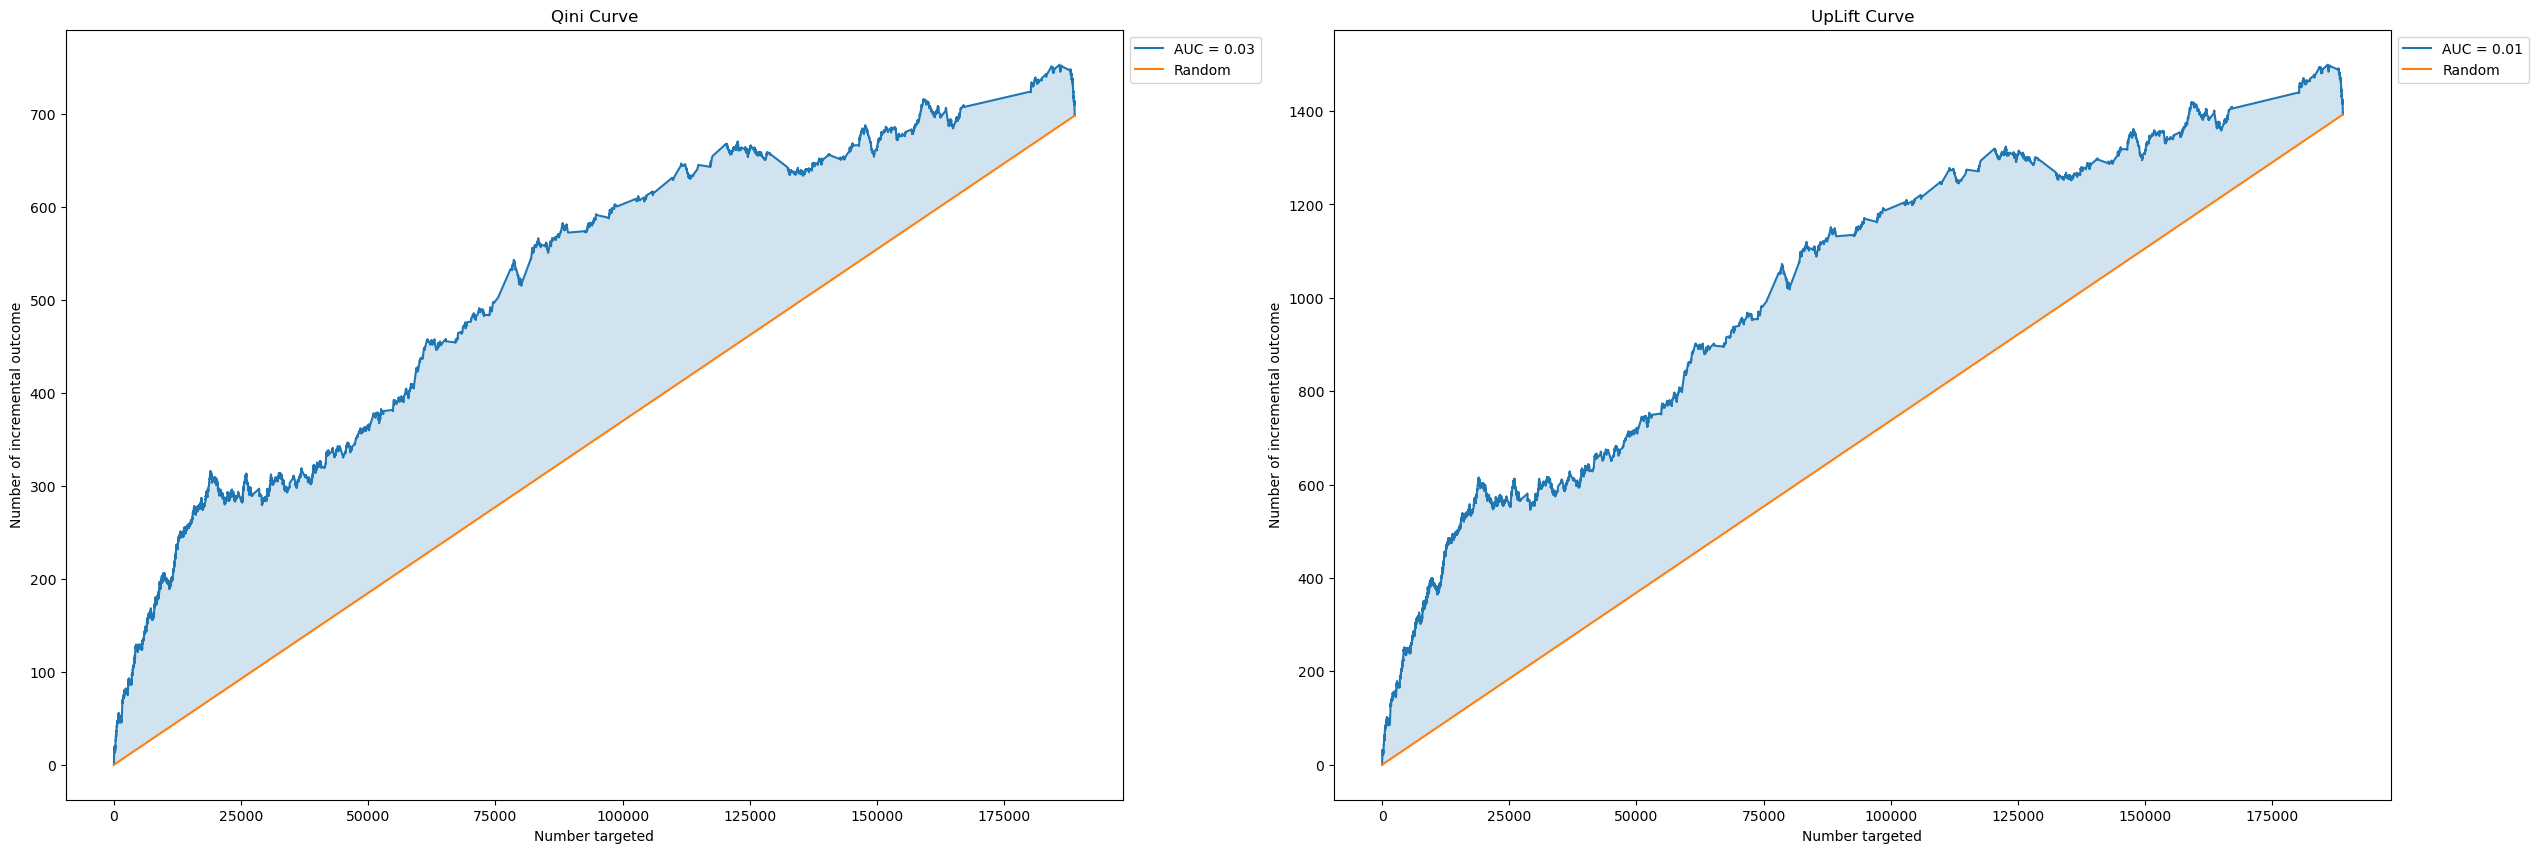

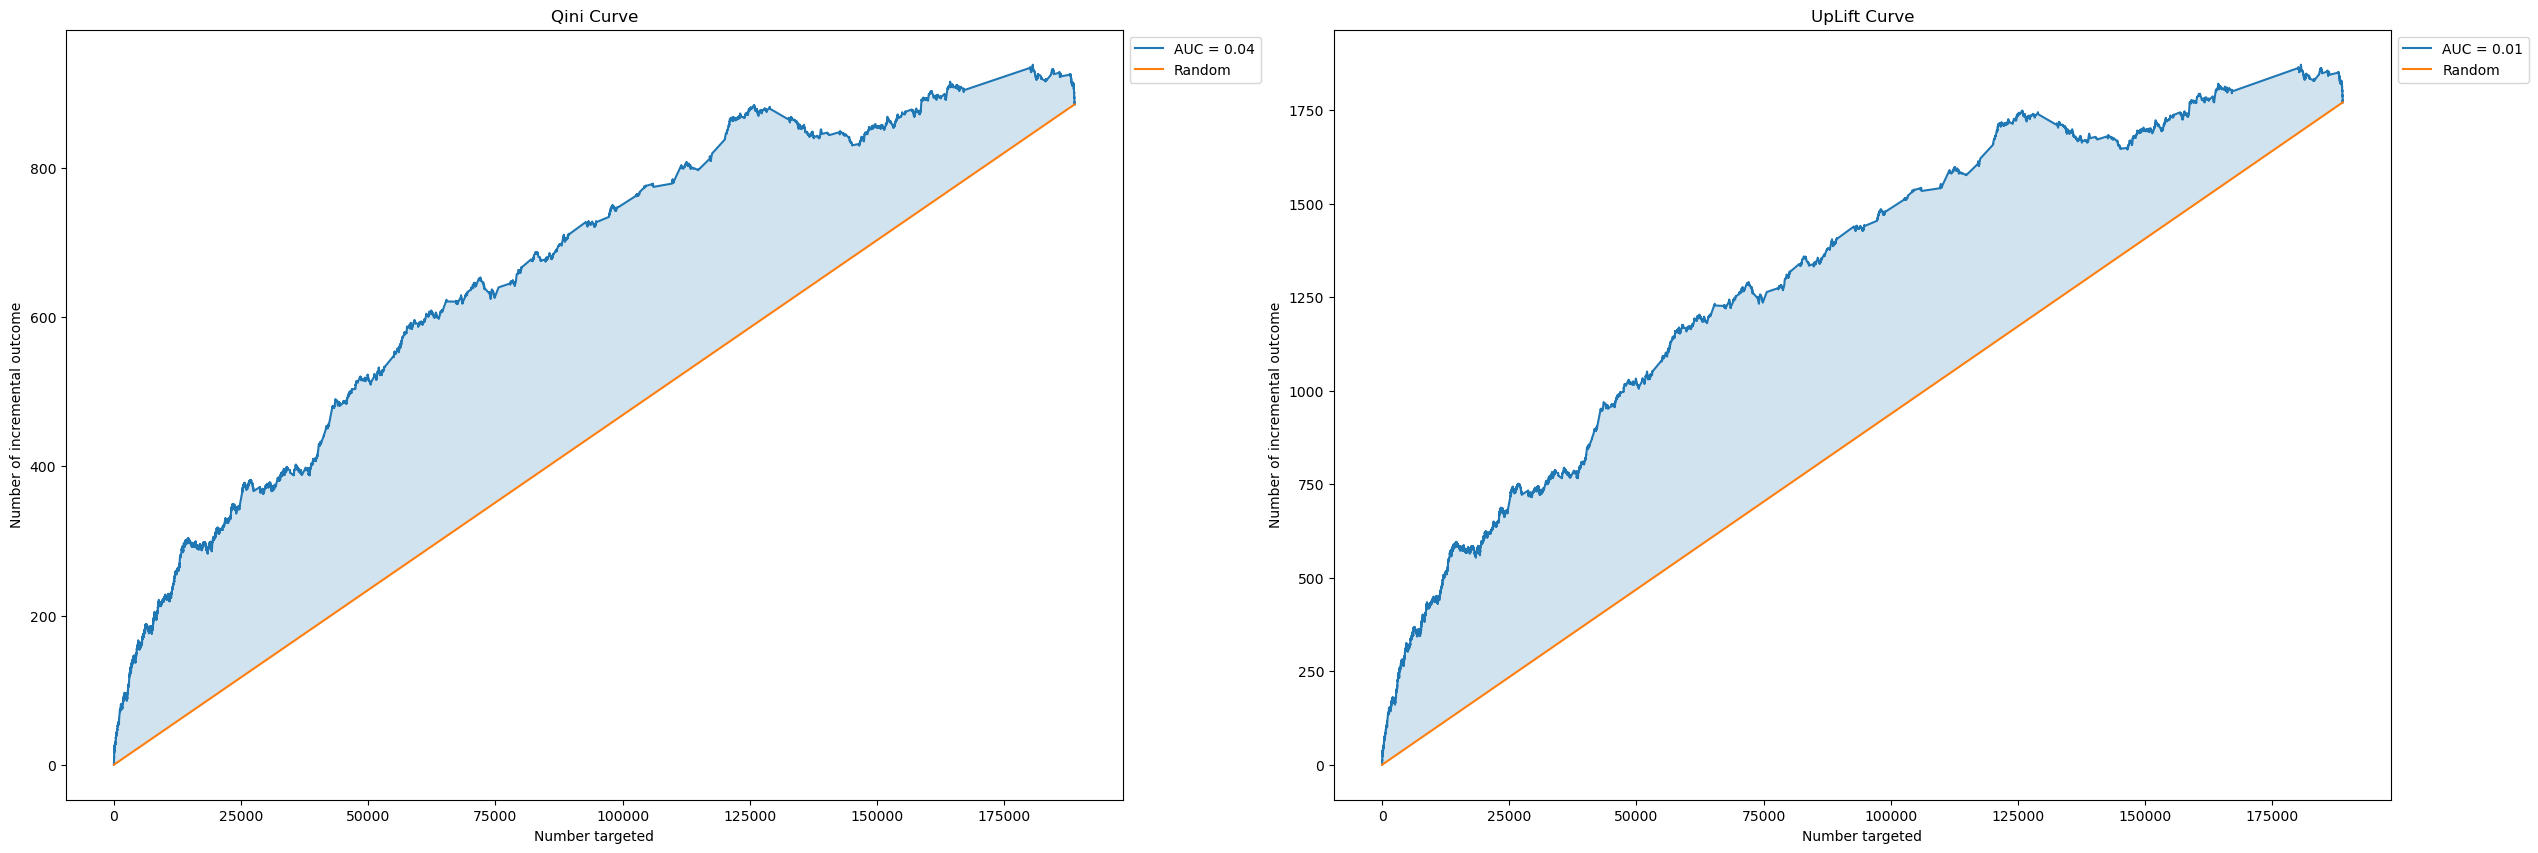

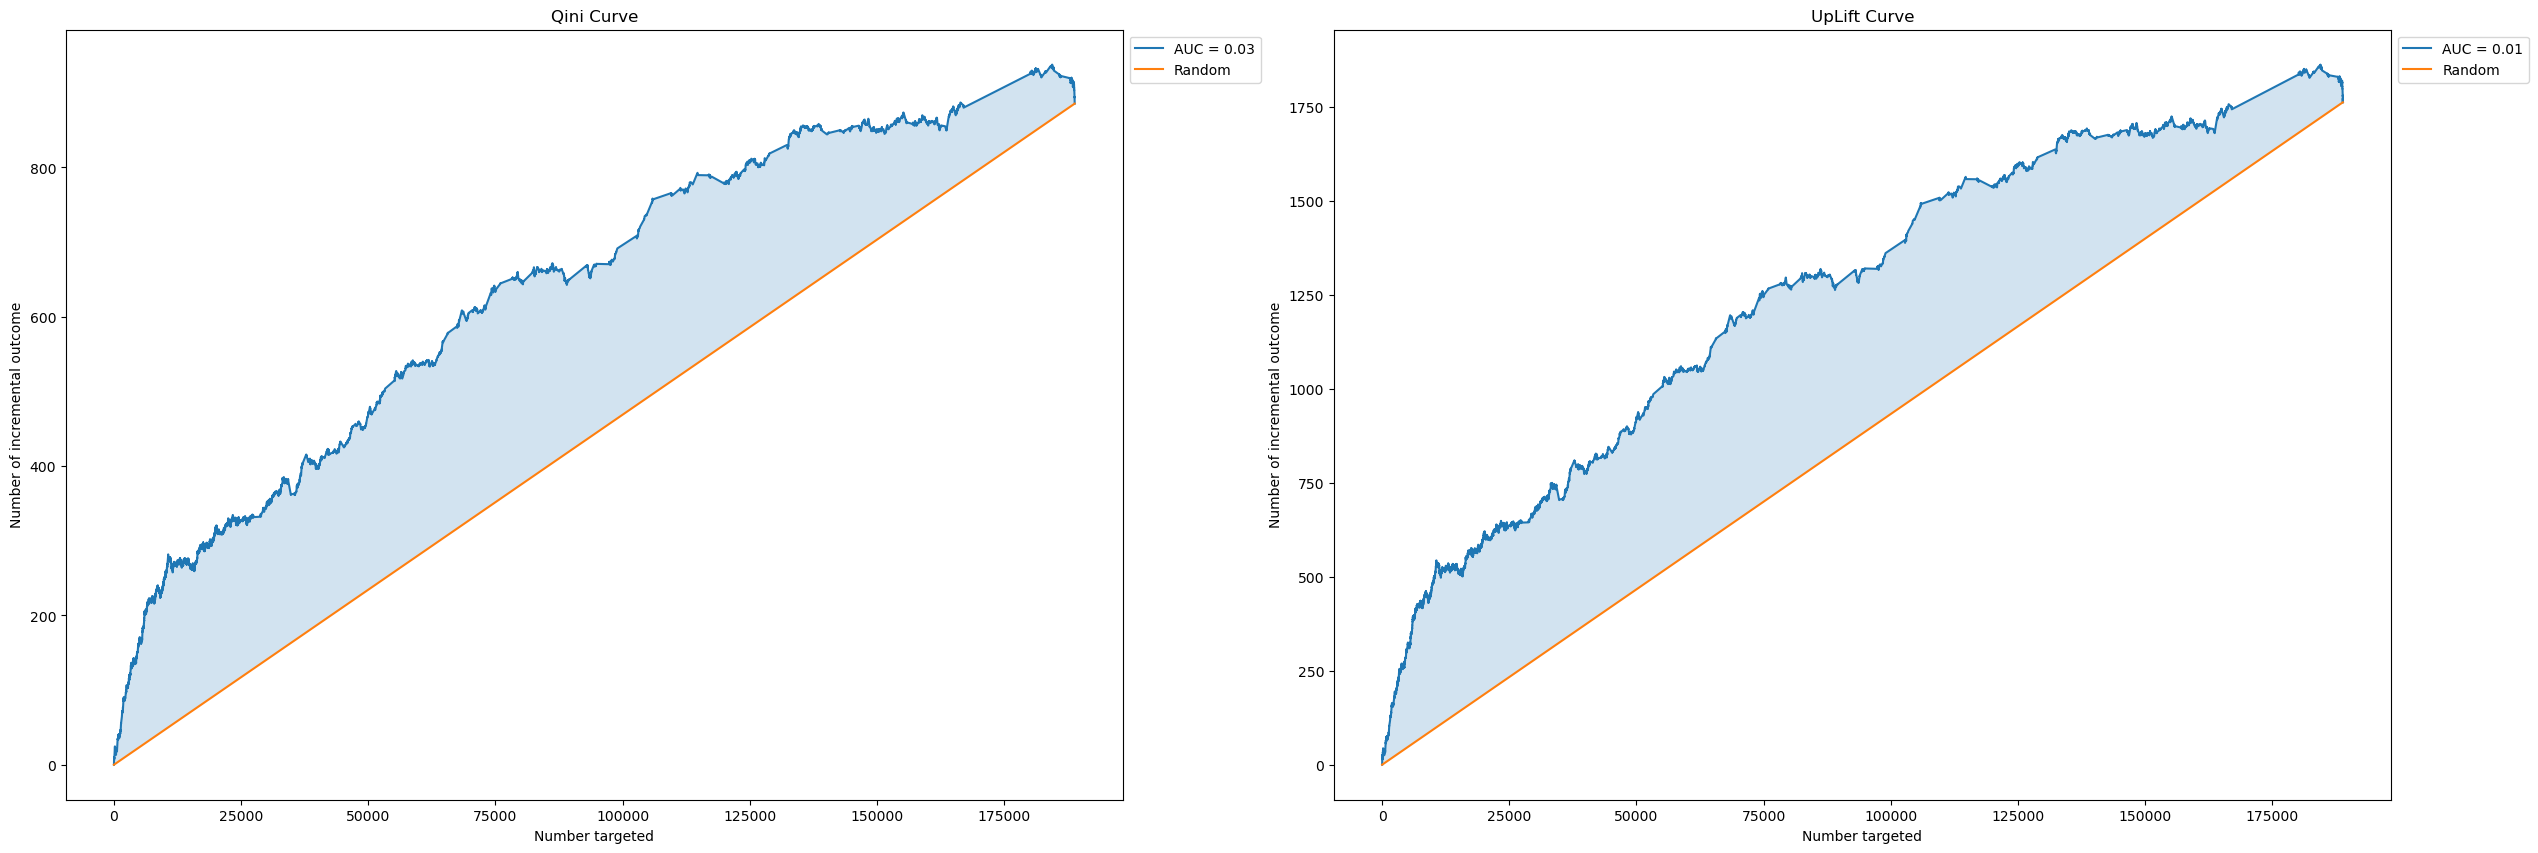

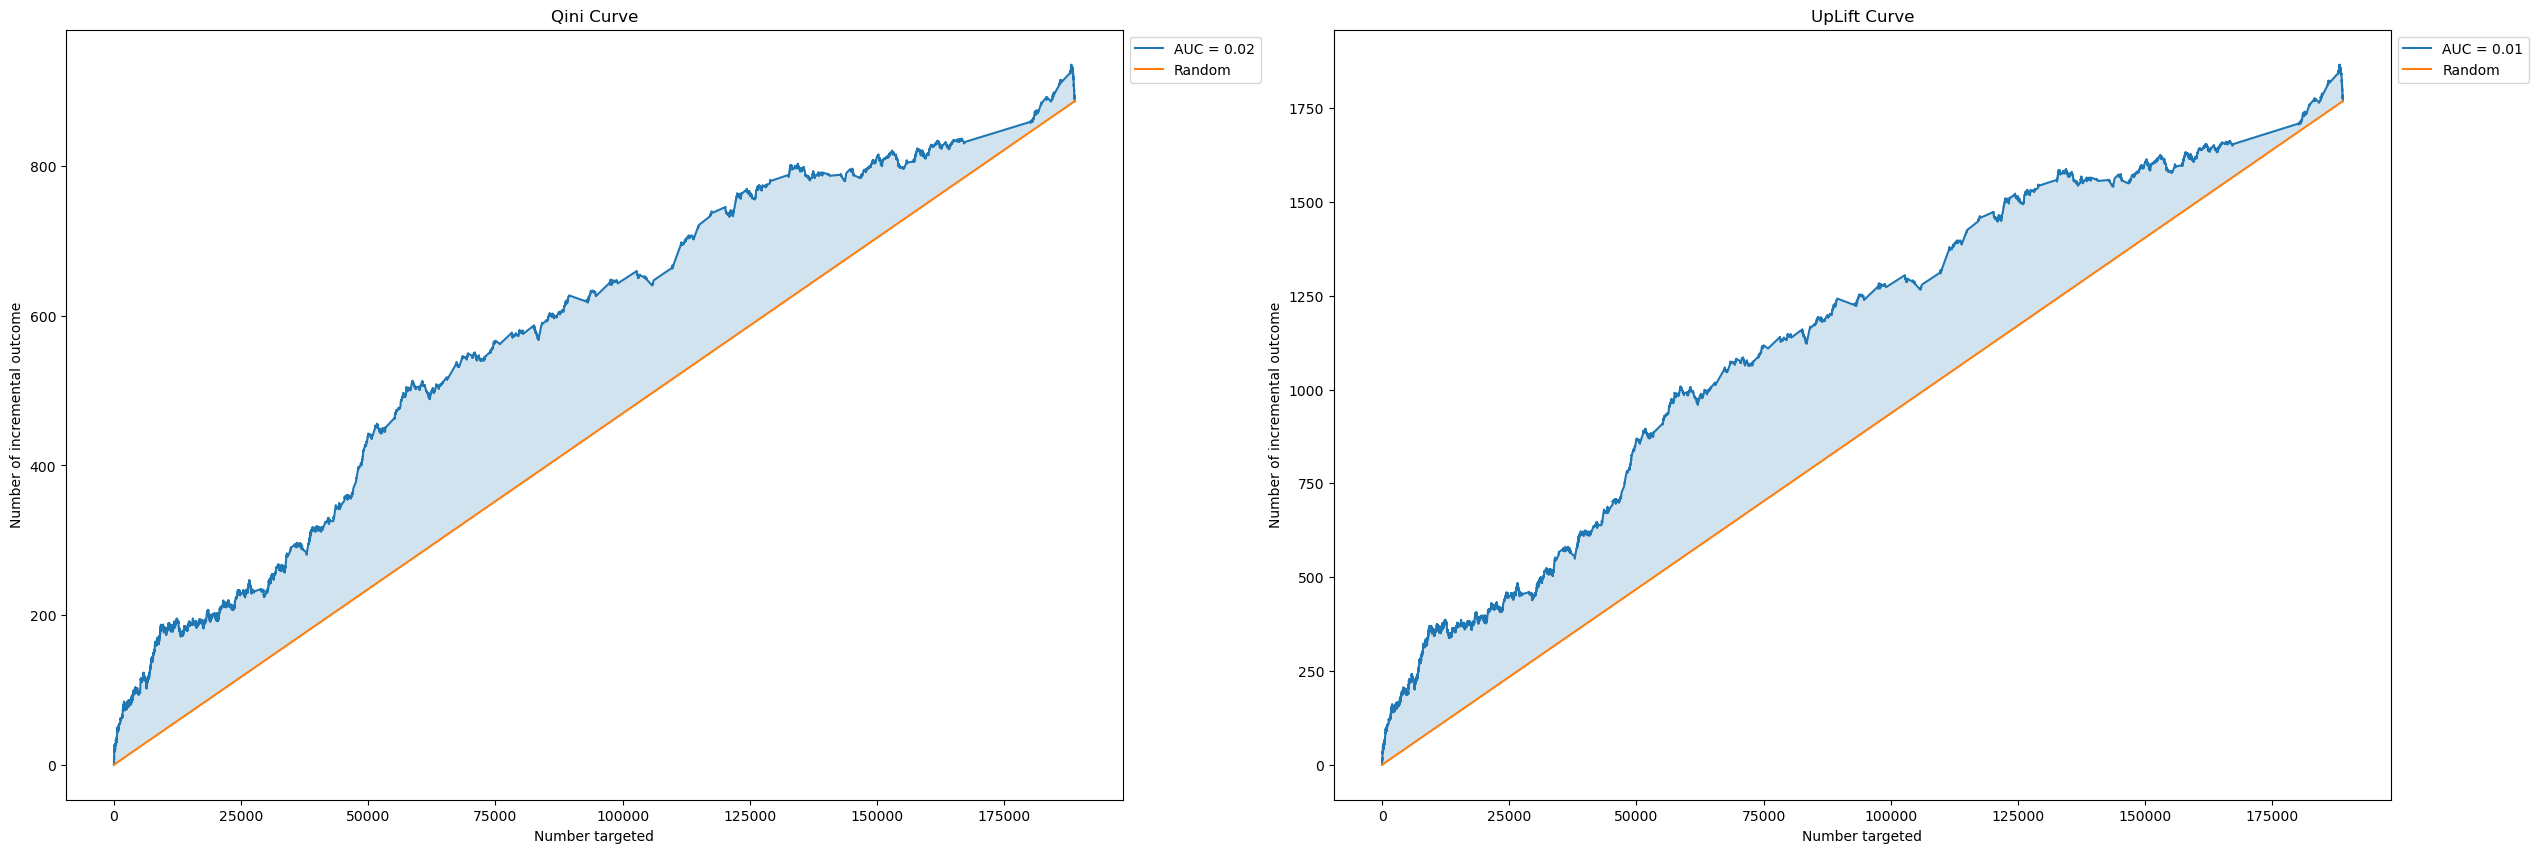

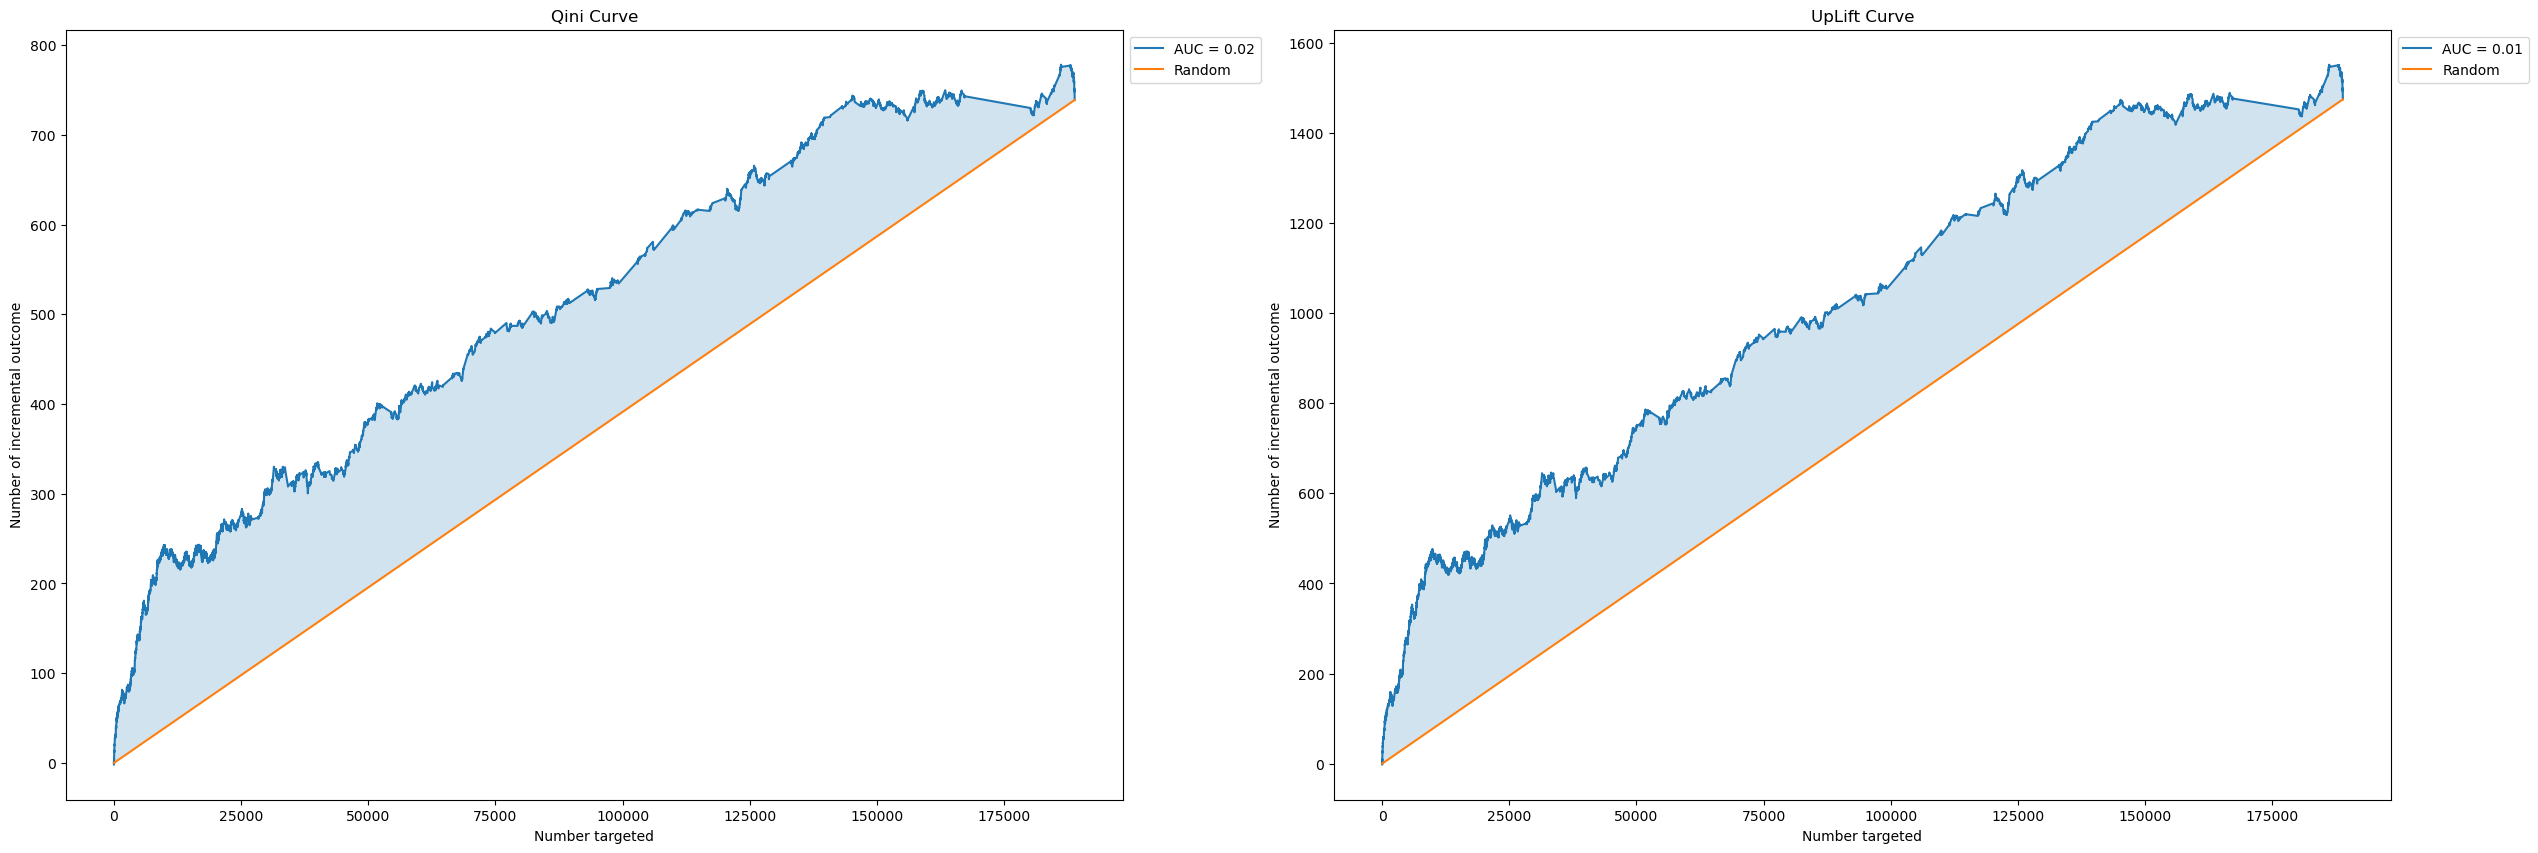

In [66]:
import copy
skf = KFold(n_splits=5)
skf.get_n_splits(X, y)
metrics = {'uplift_k_group':[],  'uplift_k_overall':[], 'qini_score':[], 'uplift_score':[]}
i = 0

for train_index, test_index in skf.split(X, y):
      gc.collect()
      X_train_, X_test_ = X[train_index], X[test_index]
      y_train_, y_test_ = y[train_index], y[test_index]
      ctbst  = copy.deepcopy(automl.best_pipeline)
      ctbst.fit(X_train_, y_train_)
      y_pred = ctbst.predict(X_test_)
      del X_train_
      del y_train_ 
      del X_test_
      gc.collect()
      uplift_overall, uplift_group, qini_score, uplift_score = get_report(targ[test_index], treat[test_index], y_pred, f"Plots/Trasnform Regression EvalML model Split {i}.png")
      metrics['uplift_k_group'].append(uplift_group)
      metrics['uplift_k_overall'].append(uplift_overall)
      metrics['qini_score'].append(qini_score)
      metrics['uplift_score'].append(uplift_score)
      i += 1
      gc.collect()


uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

In [67]:
uplift_overall = np.round(np.mean(metrics['uplift_k_overall']), 4)
uplift_group = np.round(np.mean(metrics['uplift_k_group']), 4)
qini_score = np.round(np.mean(metrics['qini_score']), 4)
uplift_score= np.round(np.mean(metrics['uplift_score']), 4)
print(f'UpLift at 30%: overall - {uplift_overall}, grouped - {uplift_group}.\nQini AUC Score: {qini_score}; UpLift AUC Score: {uplift_score}')

UpLift at 30%: overall - 0.0165, grouped - 0.0177.
Qini AUC Score: 0.0282; UpLift AUC Score: 0.0069
